## Import Libraries

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import json
import ast
import os
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold

from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from transformers import DataCollatorForTokenClassification

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt
from tqdm import tqdm

# from torchsummary import summary

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


## Define NER Label

In [4]:
# Info: Transformers (huggingface) is quite different from pytorch
label_names = ["SBJ", "MDL", "ACT", "OBJ", "QTY", "QVA",
               "O"]
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

## Download Model

In [5]:
# # Use a pipeline as a high-level helper
# from transformers import pipeline

# pipe = pipeline("token-classification", model="kiipliwooke/KIPBERT")

# Load model directly
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
model = AutoModelForTokenClassification.from_pretrained("indolem/indobert-base-uncased", label2id=label2id, id2label=id2label)

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
pipe("Bagaimana bunyi Pasal 23 dalam Peraturan Pemerintah Republik Indonesia Nomor 87 Tahun 2013")

NameError: name 'pipe' is not defined

## Save Model to local - Example

In [ ]:
# save_path = 'model/'

# model_ner_path = os.path.join(save_path, "indobert_ner"+".pth")

# torch.save(model_ner, model_ner_path)

## Load Model - Example

In [6]:
# save_path = 'model/'
# model_ner_path = os.path.join(save_path, "indobert_ner"+".pth")

# bert_ner = torch.load(model_ner_path)

# bert_ner = pipe
bert_ner = model

In [7]:
bert_ner

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31923, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [8]:
bert_ner.config.num_labels

7

In [9]:
bert_ner.config.id2label

{0: 'SBJ', 1: 'MDL', 2: 'ACT', 3: 'OBJ', 4: 'QTY', 5: 'QVA', 6: 'O'}

In [10]:
print(bert_ner)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31923, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

# LexID QA 2 Using BERT

## Dataset Class

In [15]:
class Lexidqa2Dataset(Dataset):
  """LexID QA2 Dataset"""

  def __init__(self, dataframe, tokenizer):
    """
      dataframe (Pandas DataFrame): Dataset in DataFrame format
      tokenizer (Tokenizer) : Sentence to Vector
    """
    self.qa_frame = dataframe
    self.tokenizer = tokenizer

    self.id2label = {
        0: "SBJ", 1: "MDL", 2: "ACT", 3: "OBJ", 4: "QTY", 5: "QVA",
        6: "O"
    }
    self.label2id = {
        "B-SBJ": 0, "B-MDL": 1, "B-ACT": 2, "B-OBJ": 3, "B-QTY": 4, "B-QVA": 5,
        "I-SBJ": 0, "I-MDL": 1, "I-ACT": 2, "I-OBJ": 3, "I-QTY": 4, "I-QVA": 5,
        "O": 6,
        "SBJ": 0, "MDL": 1, "ACT": 2, "OBJ": 3, "QTY": 4, "QVA": 5,
    }

  def __len__(self):
    return len(self.qa_frame)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    question = self.qa_frame.loc[idx, "question"]
    question_tokenized = tokenizer(question, truncation=True)
    question_input_ids = torch.tensor(question_tokenized['input_ids'])
    question_token_type_ids = torch.tensor(question_tokenized['token_type_ids'])
    question_attention_masks = torch.tensor(question_tokenized['attention_mask'])

    answer = self.qa_frame.loc[idx, "answer"]
    ner = torch.tensor([self.label2id[id] for id in ast.literal_eval(self.qa_frame.loc[idx, "ner"])])
    ner = self.align_labels_with_tokens(ner, question_tokenized.word_ids(), question_tokenized.tokens(), question).long()
    # ner = torch.stack([self.one_hot(label, self.label2id) for label in ner if label != -100])

    sample = (question,
              question_input_ids,
              question_token_type_ids,
              question_attention_masks,
              answer,
              ner)

    return sample

  def align_labels_with_tokens(self, labels, word_ids, tokens, question):
    for index, token in enumerate(tokens):
      if token == '-':
        for i in range(index, len(word_ids)):
          if word_ids[i] is not None:
            word_ids[i] -= 1
      elif token == '/':
        for i in range(index, len(word_ids)):
          if word_ids[i] is not None:
            word_ids[i] -= 1
      elif token == ',':
        for i in range(index, len(word_ids)):
          if word_ids[i] is not None:
            word_ids[i] -= 1
      elif token == '?':
        for i in range(index, len(word_ids)):
          if word_ids[i] is not None:
            word_ids[i] -= 1
      elif token == '.':
        for i in range(index, len(word_ids)):
          if word_ids[i] is not None:
            word_ids[i] -= 1
      elif tokens[index-1] == '-':  # Because the '-' have been deleted
        id = word_ids[index-1]
        if question.split(' ')[id][-1] != '-': # Check if the gold question concatenated between the special character or not
          for i in range(index, len(word_ids)):
            if word_ids[i] is not None:
              word_ids[i] -= 1
      elif tokens[index-1] == '/':  # Because the '/' have been deleted
        id = word_ids[index-1]
        if question.split(' ')[id][-1] != '/': # Check if the gold question concatenated between the special character or not
          for i in range(index, len(word_ids)):
            if word_ids[i] is not None:
              word_ids[i] -= 1
      elif tokens[index-1] == ',':  # Because the ',' have been deleted
        id = word_ids[index-1]
        if question.split(' ')[id][-1] != ',': # Check if the gold question concatenated between the special character or not
          for i in range(index, len(word_ids)):
            if word_ids[i] is not None:
              word_ids[i] -= 1

    new_labels = []
    current_word = None
    for word_id in word_ids:
      if word_id != current_word:
        # Start of a new word!
        current_word = word_id
        label = -100 if word_id is None else labels[word_id]
        new_labels.append(label)
      elif word_id is None:
        # Special token
        new_labels.append(-100)
      else:
        # Same word as previous token
        label = labels[word_id]
        new_labels.append(label)

    return torch.Tensor(new_labels)

  def one_hot(self, label, label2id):
    one_hot_label = torch.zeros(len(label2id))
    one_hot_label[int(label)] = 1

    return one_hot_label

## Dataset

In [16]:
train_semantic_df = pd.read_csv('semantic/dataset/train_semantic.csv')
test_semantic_df = pd.read_csv('semantic/dataset/test_semantic.csv')

qa_dataset = Lexidqa2Dataset(train_semantic_df, tokenizer)

In [17]:
train_semantic_df.loc[151]['question'], train_semantic_df.loc[151]['ner']

('Apakah orang yang melakukan penyuluhan pertanian, perikanan, kehutanan yang menimbulkan kerugian sosial ekonomi dapat dipidana?',
 "['O', 'B-SBJ', 'O', 'B-ACT', 'B-OBJ', 'I-OBJ', 'I-OBJ', 'I-OBJ', 'O', 'B-ACT', 'B-OBJ', 'I-OBJ', 'I-OBJ', 'B-MDL', 'B-ACT']")

In [18]:
qa_dataset[0]

('Sebagai Bank Accd, apakah Prinsip Umum Perizinan Dapat Berkondisi Pembawaan Uka',
 tensor([    3,  1624,  2747, 11215,   933,    16,  2811,  4174,  2047, 22155,
          1708, 11178,  2510,  9115,  1476,  3360,   936,     4]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'Ya',
 tensor([-100,    4,    5,    5,    5,    5,    6,    0,    0,    0,    1,    2,
            2,    3,    3,    3,    3, -100]))

Sample

In [ ]:
tokenizer("Undang-Undang Republik Indonesia Nomor 7 Tahun 1967 dibuat dengan menimbang-nimbang apa").tokens()

['[CLS]',
 'undang',
 '-',
 'undang',
 'republik',
 'indonesia',
 'nomor',
 '7',
 'tahun',
 '1967',
 'dibuat',
 'dengan',
 'menimbang',
 '-',
 'nim',
 '##bang',
 'apa',
 '[SEP]']

In [ ]:
tokenizer("Apakah Peraturan Menteri Keuangan Republik Indonesia Nomor 218 Tahun 2014 ini pernah diameliorasi").tokens()

['[CLS]',
 'apakah',
 'peraturan',
 'menteri',
 'keuangan',
 'republik',
 'indonesia',
 'nomor',
 '21',
 '##8',
 'tahun',
 '2014',
 'ini',
 'pernah',
 'diam',
 '##eli',
 '##orasi',
 '[SEP]']

In [ ]:
print(qa_dataset[7179])

Undang-Undang Republik Indonesia Nomor 7 Tahun 1967 dibuat dengan menimbang-nimbang apa
['[CLS]', 'undang', '-', 'undang', 'republik', 'indonesia', 'nomor', '7', 'tahun', '1967', 'dibuat', 'dengan', 'menimbang', '-', 'nim', '##bang', 'apa', '[SEP]']
('Undang-Undang Republik Indonesia Nomor 7 Tahun 1967 dibuat dengan menimbang-nimbang apa', tensor([3.0000e+00, 2.6130e+03, 1.7000e+01, 2.6130e+03, 3.4890e+03, 1.7180e+03,
        3.2860e+03, 2.7000e+01, 1.6200e+03, 8.9900e+03, 3.2300e+03, 1.5450e+03,
        1.7572e+04, 1.7000e+01, 1.8615e+04, 2.0960e+03, 2.0640e+03, 4.0000e+00]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), '1. Bahwa dipandang perlu memberikan penghargaan kepada mereka yang telah menyumbangkan tenaganya secara aktif atas dasar sukarela dalam ikatan kesatuan bersenjata (resmi maupun kelaskaran) dalam memperjuangkan, membela dan mempertahankan Kemerdekaan N

In [ ]:
for i in range(len(qa_dataset)):
  sample = qa_dataset[i]

  print(i, sample[0])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
np.random.seed(12345)
random_indices = np.random.choice(range(len(qa_dataset)), size=5, replace=False)

for i in random_indices:
  sample = qa_dataset[i]

  print(i, sample[0])

  if i == 5:
    break

5710 Kapan terjadinya pengukugannya Peraturan Menteri Keuangan Republik Indonesia Nomor 204 Tahun 2015 ini keluar
21038 Apakah isi Pasal 2 dalam Peraturan Menteri Kelautan Dan Perikanan Republik Indonesia Nomor 25 Tahun 2012 itu
19978 Berapa jumlah pasal yang tersusun di Peraturan Pemerintah Republik Indonesia Nomor 26 Tahun 2016 tersebut
29131 Sudahkah Peraturan Menteri Perhubungan Republik Indonesia Nomor 41 Tahun 2012 tersebut dilakukan penyempurnaan
26026 Peraturan Komisi Pemilihan Umum Republik Indonesia Nomor 10 Tahun 2015 tersebut terjadi penganuliran pasal-pasal mana saja


## Split, DataLoader

In [19]:
def collate_fn_class(data):
    """
       data: is a list of tuples with (example, label, length)
             where 'example' is a tensor of arbitrary shape
             and label/length are scalars
    """
    _, input_ids, _, attentions, _, ner_labels = zip(*data)
    features = pad_sequence(input_ids, batch_first=True)
    masks = pad_sequence(attentions, batch_first=True)
    targets = pad_sequence(ner_labels, batch_first=True, padding_value=-100)
    return features, masks, targets

    # max_len = max(lengths)
    # n_ftrs = data[0][0].size(1)
    # features = torch.zeros((len(data), max_len, n_ftrs))
    # labels = torch.tensor(labels)
    # lengths = torch.tensor(lengths)

    # for i in range(len(data)):
    #     j, k = data[i][0].size(0), data[i][0].size(1)
    #     features[i] = torch.cat([data[i][0], torch.zeros((max_len - j, k))])

    # return features.float(), labels.long(), lengths.long()

In [20]:
torch.manual_seed(0)
BATCH_SIZE = 64

train_df = pd.read_csv('semantic/dataset/train_semantic.csv')
test_df = pd.read_csv('semantic/dataset/test_semantic.csv')

qa_dataset_train = Lexidqa2Dataset(train_df, tokenizer)
qa_dataset_test = Lexidqa2Dataset(test_df, tokenizer)

train_size = len(qa_dataset_train)
test_size = len(qa_dataset_test)

test_instances = DataLoader(qa_dataset_test, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)

In [ ]:
# torch.manual_seed(0)
# BATCH_SIZE = 64

# train_instances = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_class)
# valid_instances = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)
# test_instances = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)

# # train_instances = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# # valid_instances = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
# # test_instances = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Loss Function

> Loss Function Multi-Class Classification: CrossEntropyLoss

In [21]:
loss_func = torch.nn.CrossEntropyLoss(reduction='mean')

# Extract Entity

In [22]:
# prediction in the form: list of dictionary
def extract_entity(prediction, tokens):
  sequence_length = len(tokens)

  current_index = -1
  last_label = -1
  sentence = ''
  ner = []
  entities = []

  for index, (entity_token, entity_word) in enumerate(zip(prediction, tokens)):
    if entity_word in ['[CLS]', '[SEP]', '[PAD]']:
      ner.append(-100)
      continue

    for i in range(6):
      if entity_token == i:
        ner.append(i)
        if sentence != '':
          entities.append(sentence)
          sentence = ''
        current_index = index
        if last_label == i:
          sentence += ' ' + entity_word
        else:
          sentence = entity_word
          last_label = i
        break
    if entity_token == 6: # 6 is O
      last_label = 6
      ner.append(0)

  if sentence != '':
    entities.append(sentence)
    sentence = ''

  if len(ner) < sequence_length:
    ner.append([0 for i in range(sequence_length - len(ner))])

  return entities, ner

# Evaluation Function

Evaluation based on exact match of entity

I.E. If start and till the end tokens exactly cover the chunk of entity

In [23]:
# pred and gold expected in torch in batch, in ner format, only 0 and 1
def confusion_matrix(pred, gold, conf_matrix):
  for p, g in zip(pred, gold):
    p = p.tolist()
    g = g.tolist()
    conf_matrix = compute_confusion_matrix_unit(p, g, conf_matrix)

  return conf_matrix

def compute_confusion_matrix_unit(pred, gold, conf_matrix):
  for i, (p, g) in reversed(list(enumerate(zip(pred, gold)))):
    if g == -100:
      del pred[i], gold[i]

  current_index = -1
  current_ner_label = -1
  start_index = -1

  for g in gold:
    if g != current_ner_label:
      if current_index == -1:
        current_index = 0
        start_index = 0
        current_ner_label = g
      else:
        complete_cycle = False
        for i in range(start_index, current_index + 1):
          if pred[i] != current_ner_label:
            conf_matrix[current_ner_label, pred[i]] += 1
            complete_cycle = True
            break
        if not complete_cycle:
          conf_matrix[current_ner_label, current_ner_label] += 1
        current_index += 1
        start_index = current_index
        current_ner_label = g
    else:
      current_index += 1

  complete_cycle = False
  for i in range(start_index, current_index + 1):
    if pred[i] != current_ner_label:
      conf_matrix[current_ner_label, pred[i]] += 1
      complete_cycle = True
      break
  if not complete_cycle:
    conf_matrix[current_ner_label, current_ner_label] += 1

  return conf_matrix

In [24]:
def evaluation_metric(conf_matrix):
  nb_classes = 7
  display_labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']

  amt = amount(conf_matrix)
  print(f"Debug Amount: {amt}")
  acc = accuracy(conf_matrix)
  prec = precision(conf_matrix)
  rec = recall(conf_matrix)
  f1 = fone(prec, rec)

  return amt, acc, prec, rec, f1

def amount(conf_matrix):
  return conf_matrix.sum(1)

def accuracy(conf_matrix):
  return conf_matrix.diag()/conf_matrix.sum(1)

def precision(conf_matrix):
  nb_classes = 7

  prec = torch.zeros(nb_classes)
  for index in range(nb_classes):
    true_positive = 0
    false_positive = 0
    for col in range(nb_classes):
      if index == col:
        true_positive = conf_matrix[index, col]
      else:
        false_positive += conf_matrix[index, col]
    prec[index] = true_positive / (true_positive + false_positive)

  return prec

def recall(conf_matrix):
  nb_classes = 7

  rec = torch.zeros(nb_classes)
  for index in range(nb_classes):
    true_positive = 0
    false_negative = 0
    for col in range(nb_classes):
      if index == col:
        true_positive = conf_matrix[col, index]
      else:
        false_negative += conf_matrix[col, index]
    rec[index] = true_positive / (true_positive + false_negative)

  return rec

def fone(prec, rec):
  nb_classes = 7

  f1 = torch.zeros(nb_classes)
  for index in range(nb_classes):
    f1[index] = 2 * (prec[index] * rec[index]) / (prec[index] + rec[index])

  return f1

# Training

0it [00:00, ?it/s]

=====:=====:=====:=====:===== Fold 1 =====:=====:=====:=====:=====


Some weights of BertForTokenClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:07, ?it/s]

Fold 1 Ready


0it [00:07, ?it/s]

Epoch 1 / 30


==:==:==Train==:==:==: 30it [00:03,  9.84it/s]


Average Loss Train: 0.6339934865633646


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:11, ?it/s]

Average Loss Validation: 0.5686312648985121
Time 3.6974692344665527

Epoch 2 / 30


==:==:==Train==:==:==: 30it [00:02, 10.06it/s]


Average Loss Train: 0.5626899083455403


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:14, ?it/s]

Average Loss Validation: 0.48476899994744194
Time 3.6729438304901123

Epoch 3 / 30


==:==:==Train==:==:==: 30it [00:03,  9.90it/s]


Average Loss Train: 0.49686241149902344


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:18, ?it/s]

Average Loss Validation: 0.40564142333136666
Time 3.685011386871338

Epoch 4 / 30


==:==:==Train==:==:==: 30it [00:02, 10.07it/s]


Average Loss Train: 0.4333240071932475


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:22, ?it/s]

Average Loss Validation: 0.3364724251959059
Time 3.642408847808838

Epoch 5 / 30


==:==:==Train==:==:==: 30it [00:02, 10.23it/s]


Average Loss Train: 0.37514514525731407


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.27929482857386273
Time 3.586244821548462

Debug Amount: tensor([123., 134., 159., 118., 138., 103., 128.])


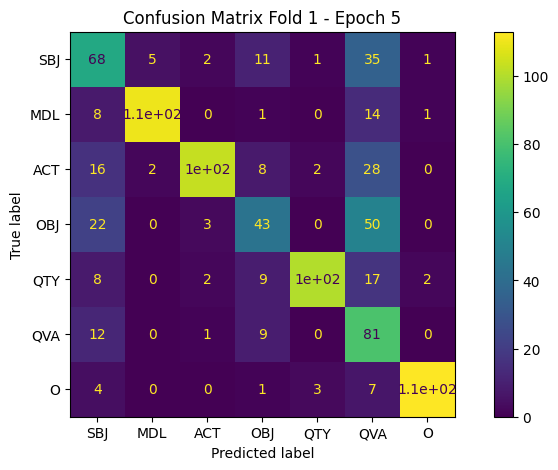

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,123.0,0.552846,0.552846,0.492754,0.521073
MDL,134.0,0.820895,0.820895,0.940171,0.876494
ACT,159.0,0.647799,0.647799,0.927928,0.762963
OBJ,118.0,0.364407,0.364407,0.524390,0.430000
QTY,138.0,0.724638,0.724638,0.943396,0.819672
QVA,103.0,0.786408,0.786408,0.349138,0.483582
O,128.0,0.882812,0.882812,0.965812,0.922449


0it [00:27, ?it/s]

Epoch 6 / 30


==:==:==Train==:==:==: 30it [00:02, 10.14it/s]


Average Loss Train: 0.32068482637405393


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:31, ?it/s]

Average Loss Validation: 0.23258021805021498
Time 3.6362357139587402

Epoch 7 / 30


==:==:==Train==:==:==: 30it [00:02, 10.17it/s]


Average Loss Train: 0.2752301235993703


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:34, ?it/s]

Average Loss Validation: 0.1969518396589491
Time 3.6250667572021484

Epoch 8 / 30


==:==:==Train==:==:==: 30it [00:03,  9.98it/s]


Average Loss Train: 0.24653897086779278


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:38, ?it/s]

Average Loss Validation: 0.16863523920377096
Time 3.7120254039764404

Epoch 9 / 30


==:==:==Train==:==:==: 30it [00:02, 10.08it/s]


Average Loss Train: 0.22005524436632792


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:42, ?it/s]

Average Loss Validation: 0.15054637524816725
Time 3.6633400917053223

Epoch 10 / 30


==:==:==Train==:==:==: 30it [00:03,  9.93it/s]


Average Loss Train: 0.20383140643437703


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.13462850782606336
Time 3.683568000793457

Debug Amount: tensor([123., 134., 159., 118., 138., 103., 128.])


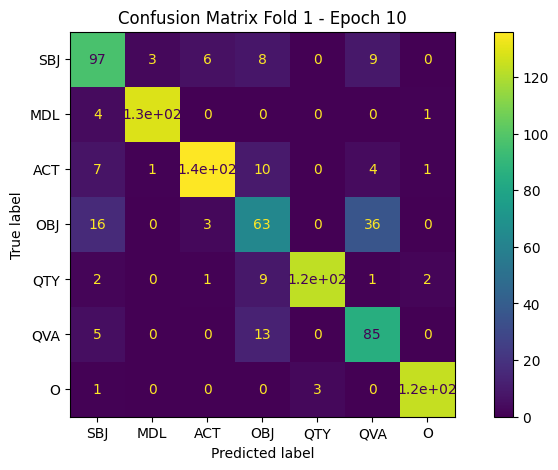

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,123.0,0.788618,0.788618,0.734848,0.760784
MDL,134.0,0.962687,0.962687,0.969925,0.966292
ACT,159.0,0.855346,0.855346,0.931507,0.891803
OBJ,118.0,0.533898,0.533898,0.611650,0.570136
QTY,138.0,0.891304,0.891304,0.976190,0.931818
QVA,103.0,0.825243,0.825243,0.629630,0.714286
O,128.0,0.968750,0.968750,0.968750,0.968750


0it [00:48, ?it/s]

Epoch 11 / 30


==:==:==Train==:==:==: 30it [00:02, 10.01it/s]


Average Loss Train: 0.1882608115673065


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:52, ?it/s]

Average Loss Validation: 0.1256134808063507
Time 3.6525917053222656

Epoch 12 / 30


==:==:==Train==:==:==: 30it [00:02, 10.00it/s]


Average Loss Train: 0.17889295121033985


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:55, ?it/s]

Average Loss Validation: 0.11691893140474956
Time 3.6797595024108887

Epoch 13 / 30


==:==:==Train==:==:==: 30it [00:03,  9.97it/s]


Average Loss Train: 0.16734872063000997


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:59, ?it/s]

Average Loss Validation: 0.11016867227024502
Time 3.6755001544952393

Epoch 14 / 30


==:==:==Train==:==:==: 30it [00:03,  9.79it/s]


Average Loss Train: 0.16157947679360707


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [01:03, ?it/s]

Average Loss Validation: 0.10355174210336474
Time 3.7607665061950684

Epoch 15 / 30


==:==:==Train==:==:==: 30it [00:02, 10.07it/s]


Average Loss Train: 0.15776101052761077


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.10213432047102186
Time 3.6953108310699463

Debug Amount: tensor([123., 134., 159., 118., 138., 103., 128.])


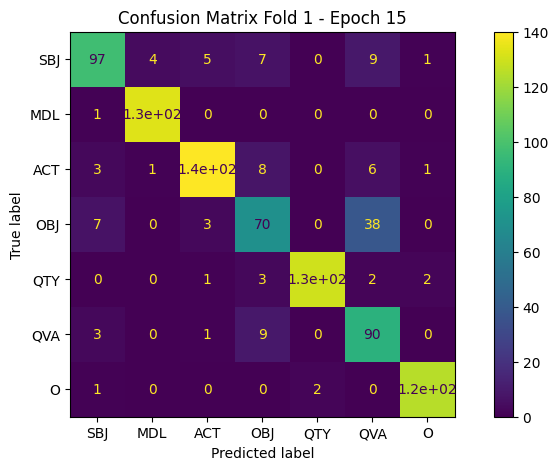

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,123.0,0.788618,0.788618,0.866071,0.825532
MDL,134.0,0.992537,0.992537,0.963768,0.977941
ACT,159.0,0.880503,0.880503,0.933333,0.906149
OBJ,118.0,0.593220,0.593220,0.721649,0.651163
QTY,138.0,0.942029,0.942029,0.984848,0.962963
QVA,103.0,0.873786,0.873786,0.620690,0.725806
O,128.0,0.976562,0.976562,0.968992,0.972763


0it [01:09, ?it/s]

Epoch 16 / 30


==:==:==Train==:==:==: 30it [00:02, 10.03it/s]


Average Loss Train: 0.1462558368841807


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [01:12, ?it/s]

Average Loss Validation: 0.10265830490324232
Time 3.6612370014190674

Epoch 17 / 30


==:==:==Train==:==:==: 30it [00:03,  9.95it/s]


Average Loss Train: 0.14860675732294717


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [01:16, ?it/s]

Average Loss Validation: 0.0942269182867474
Time 3.7070534229278564

Epoch 18 / 30


==:==:==Train==:==:==: 30it [00:03,  9.83it/s]


Average Loss Train: 0.1385740280151367


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [01:20, ?it/s]

Average Loss Validation: 0.09059855010774401
Time 3.6994149684906006

Epoch 19 / 30


==:==:==Train==:==:==: 30it [00:03,  9.99it/s]


Average Loss Train: 0.13449568152427674


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [01:24, ?it/s]

Average Loss Validation: 0.09095485674010383
Time 3.6816444396972656

Epoch 20 / 30


==:==:==Train==:==:==: 30it [00:02, 10.09it/s]


Average Loss Train: 0.13106105327606202


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.0847348968187968
Time 3.5792980194091797

Debug Amount: tensor([123., 134., 159., 118., 138., 103., 128.])


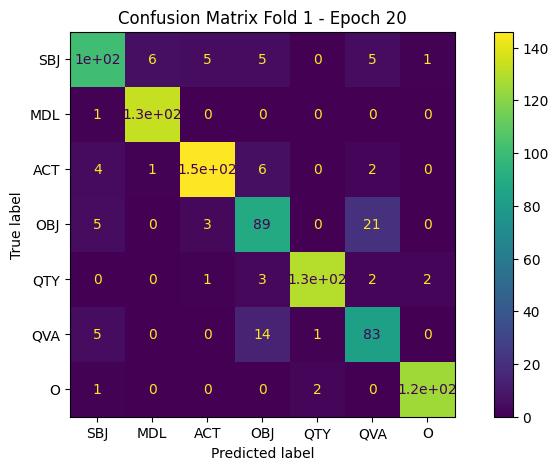

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,123.0,0.821138,0.821138,0.863248,0.841667
MDL,134.0,0.992537,0.992537,0.950000,0.970803
ACT,159.0,0.918239,0.918239,0.941935,0.929936
OBJ,118.0,0.754237,0.754237,0.760684,0.757447
QTY,138.0,0.942029,0.942029,0.977444,0.959410
QVA,103.0,0.805825,0.805825,0.734513,0.768519
O,128.0,0.976562,0.976562,0.976562,0.976562


0it [01:29, ?it/s]

Epoch 21 / 30


==:==:==Train==:==:==: 30it [00:02, 10.09it/s]


Average Loss Train: 0.1254095772902171


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [01:33, ?it/s]

Average Loss Validation: 0.0834993024667104
Time 3.5910146236419678

Epoch 22 / 30


==:==:==Train==:==:==: 30it [00:02, 10.07it/s]


Average Loss Train: 0.12598350246747334


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [01:37, ?it/s]

Average Loss Validation: 0.08286573323938581
Time 3.650890350341797

Epoch 23 / 30


==:==:==Train==:==:==: 30it [00:02, 10.08it/s]


Average Loss Train: 0.12180692752202352


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [01:40, ?it/s]

Average Loss Validation: 0.080318550268809
Time 3.669172525405884

Epoch 24 / 30


==:==:==Train==:==:==: 30it [00:02, 10.06it/s]


Average Loss Train: 0.12113838692506154


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [01:44, ?it/s]

Average Loss Validation: 0.07933364477422503
Time 3.662703037261963

Epoch 25 / 30


==:==:==Train==:==:==: 30it [00:02, 10.09it/s]


Average Loss Train: 0.11566751996676126


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.07624862094720204
Time 3.6546523571014404

Debug Amount: tensor([123., 134., 159., 118., 138., 103., 128.])


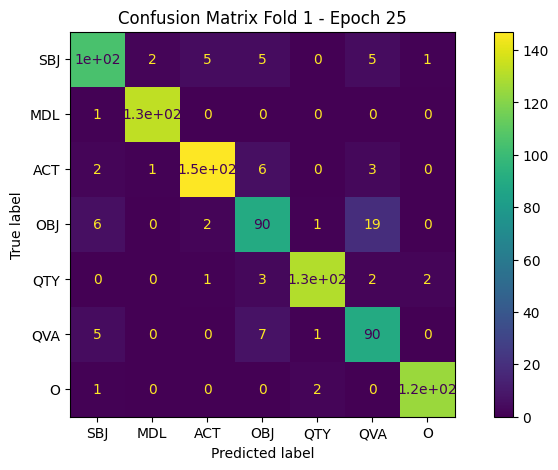

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,123.0,0.853659,0.853659,0.875000,0.864198
MDL,134.0,0.992537,0.992537,0.977941,0.985185
ACT,159.0,0.924528,0.924528,0.948387,0.936306
OBJ,118.0,0.762712,0.762712,0.810811,0.786026
QTY,138.0,0.942029,0.942029,0.970149,0.955882
QVA,103.0,0.873786,0.873786,0.756303,0.810811
O,128.0,0.976562,0.976562,0.976562,0.976562


0it [01:50, ?it/s]

Epoch 26 / 30


==:==:==Train==:==:==: 30it [00:02, 10.02it/s]


Average Loss Train: 0.11635344425837199


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [01:54, ?it/s]

Average Loss Validation: 0.07540595200326708
Time 3.6508421897888184

Epoch 27 / 30


==:==:==Train==:==:==: 30it [00:02, 10.10it/s]


Average Loss Train: 0.10979971686999003


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [01:57, ?it/s]

Average Loss Validation: 0.07487593756781684
Time 3.646045446395874

Epoch 28 / 30


==:==:==Train==:==:==: 30it [00:02, 10.19it/s]


Average Loss Train: 0.10736392935117085


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [02:01, ?it/s]

Average Loss Validation: 0.07538712190257178
Time 3.6062519550323486

Epoch 29 / 30


==:==:==Train==:==:==: 30it [00:02, 10.12it/s]


Average Loss Train: 0.1087406466404597


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [02:04, ?it/s]

Average Loss Validation: 0.07245711816681756
Time 3.5938456058502197

Epoch 30 / 30


==:==:==Train==:==:==: 30it [00:03,  9.43it/s]


Average Loss Train: 0.1039439857006073


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.07107042769591014
Time 3.8554680347442627

Debug Amount: tensor([123., 134., 159., 118., 138., 103., 128.])


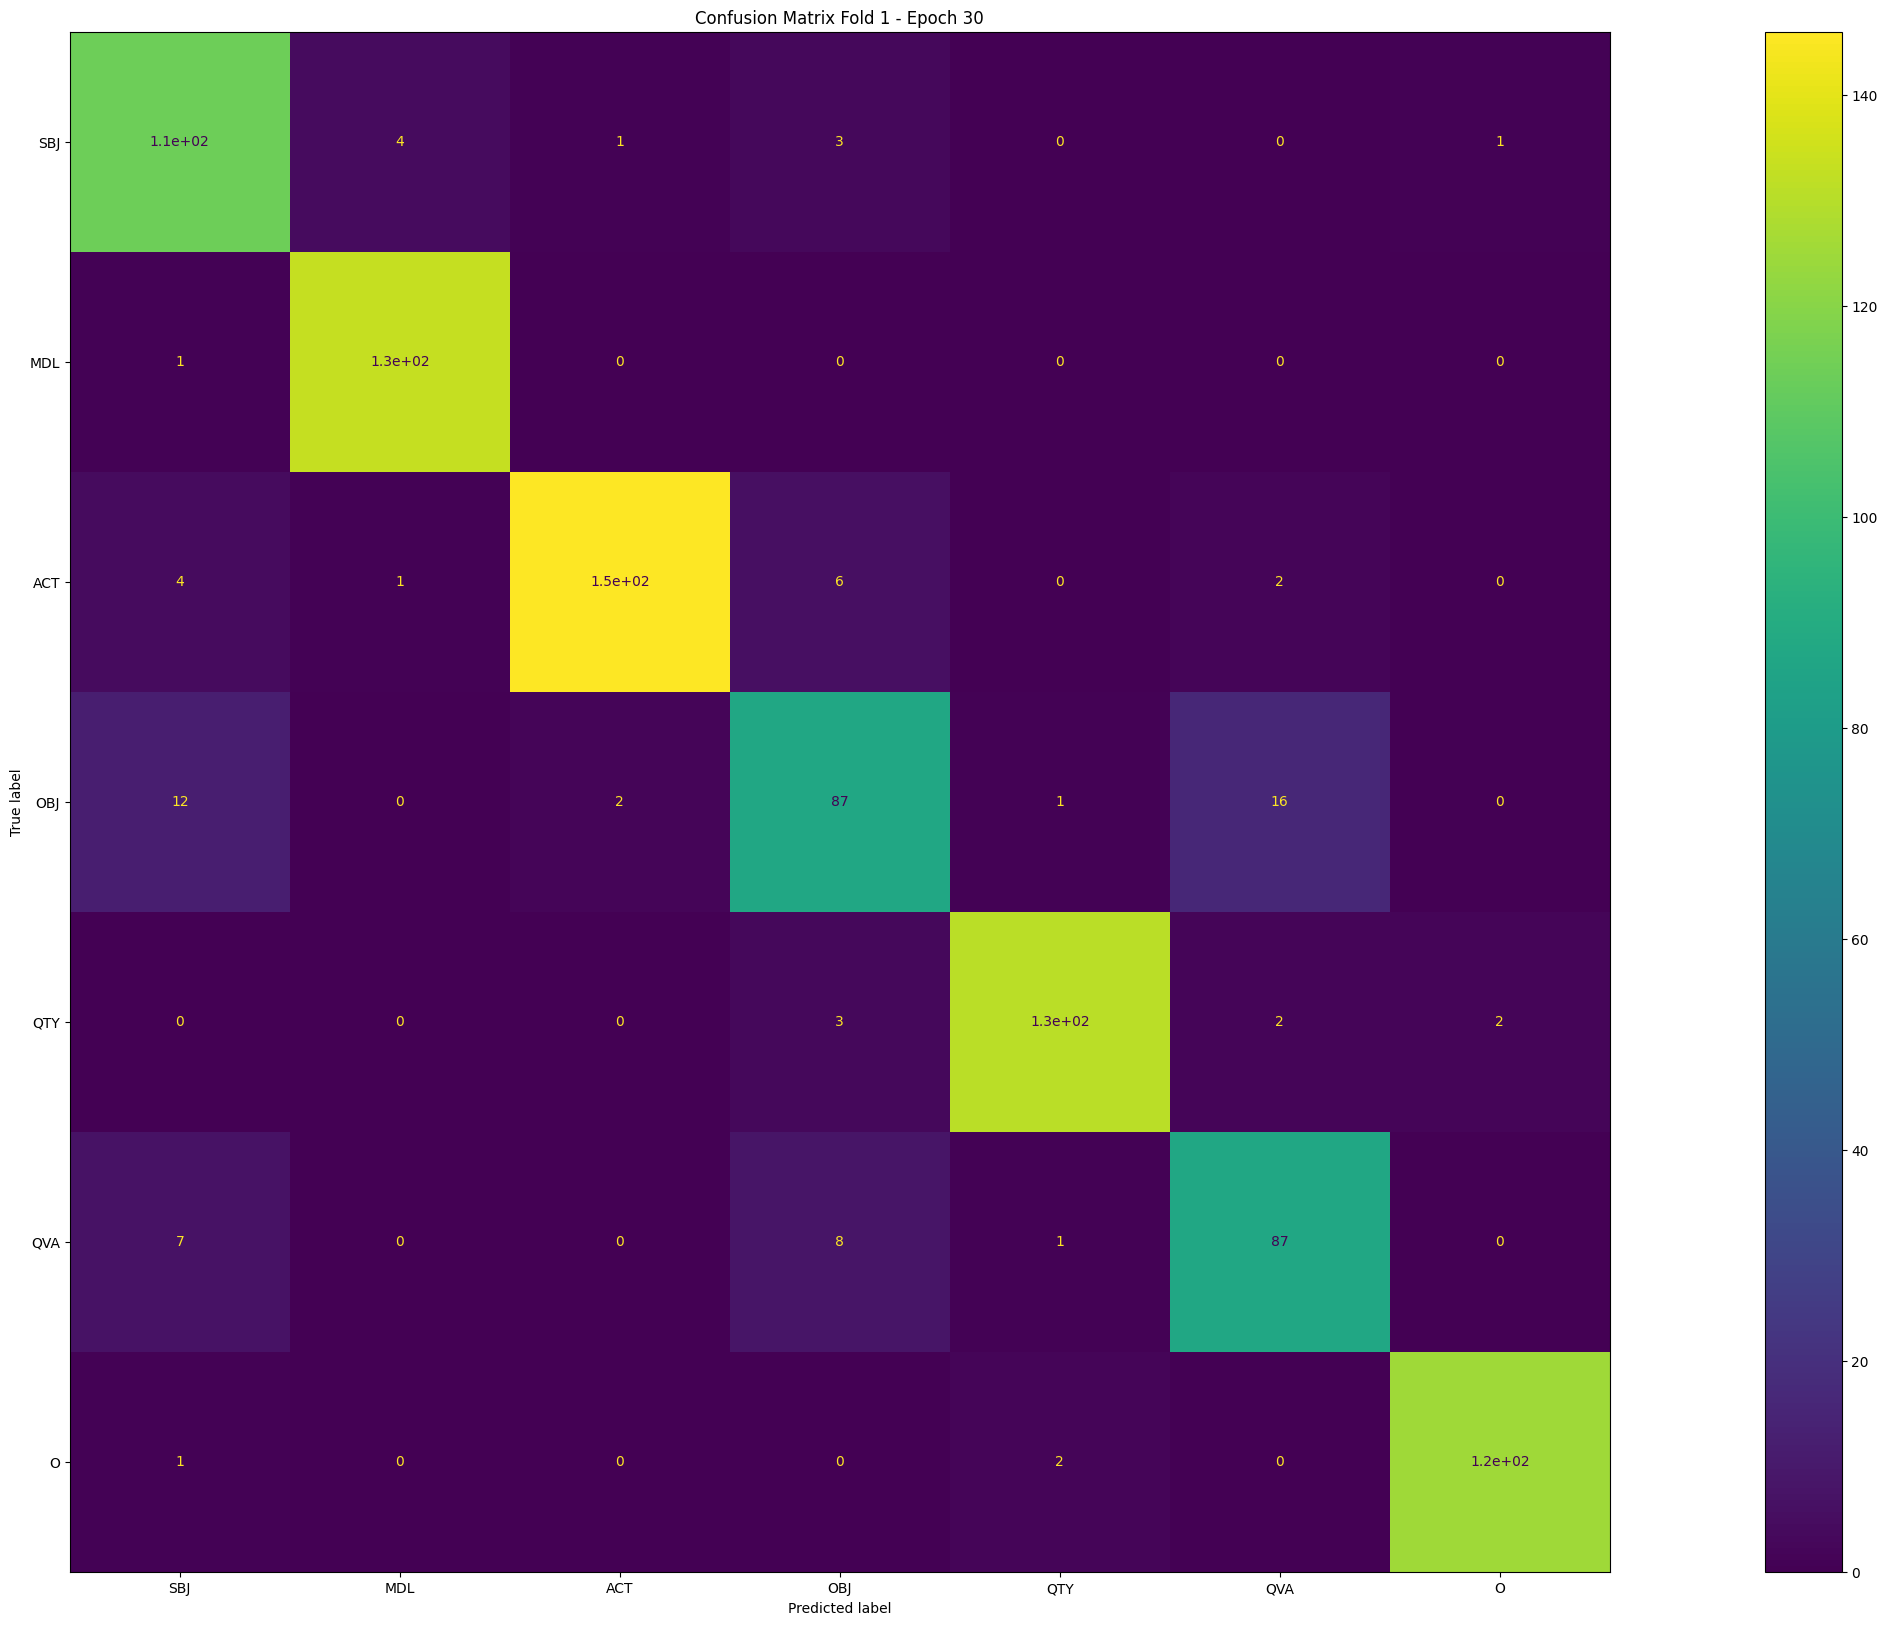

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,123.0,0.926829,0.926829,0.820144,0.870229
MDL,134.0,0.992537,0.992537,0.963768,0.977941
ACT,159.0,0.918239,0.918239,0.979866,0.948052
OBJ,118.0,0.737288,0.737288,0.813084,0.773333
QTY,138.0,0.949275,0.949275,0.970370,0.959707
QVA,103.0,0.844660,0.844660,0.813084,0.828571
O,128.0,0.976562,0.976562,0.976562,0.976562


100%|███████████████████████████████████████████| 30/30 [02:03<00:00,  4.13s/it]
1it [02:11, 131.32s/it]

=====:=====:=====:=====:===== Fold 2 =====:=====:=====:=====:=====


Some weights of BertForTokenClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
1it [02:17, 131.32s/it]

Fold 2 Ready


1it [02:17, 131.32s/it]

Epoch 1 / 30


==:==:==Train==:==:==: 30it [00:03,  9.92it/s]


Average Loss Train: 0.6280853112538656


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [02:21, 131.32s/it]

Average Loss Validation: 0.5561262634065416
Time 3.6982204914093018

Epoch 2 / 30


==:==:==Train==:==:==: 30it [00:02, 10.10it/s]


Average Loss Train: 0.5584025502204895


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [02:25, 131.32s/it]

Average Loss Validation: 0.46736011240217423
Time 3.6496129035949707

Epoch 3 / 30


==:==:==Train==:==:==: 30it [00:02, 10.16it/s]


Average Loss Train: 0.5043325026830038


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [02:28, 131.32s/it]

Average Loss Validation: 0.38781068060133195
Time 3.6256792545318604

Epoch 4 / 30


==:==:==Train==:==:==: 30it [00:03,  9.97it/s]


Average Loss Train: 0.4413077433904012


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [02:32, 131.32s/it]

Average Loss Validation: 0.32002641757329303
Time 3.669466733932495

Epoch 5 / 30


==:==:==Train==:==:==: 30it [00:02, 10.65it/s]


Average Loss Train: 0.38266103665033974


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.25601239336861503
Time 3.5037155151367188

Debug Amount: tensor([113., 135., 154., 123., 143., 107., 134.])


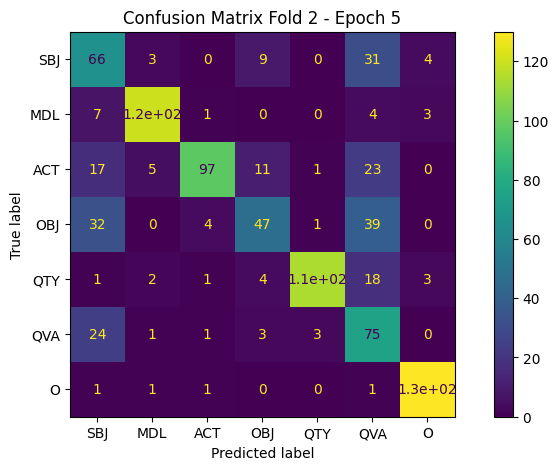

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,113.0,0.584071,0.584071,0.445946,0.505747
MDL,135.0,0.888889,0.888889,0.909091,0.898876
ACT,154.0,0.629870,0.629870,0.923810,0.749035
OBJ,123.0,0.382114,0.382114,0.635135,0.477157
QTY,143.0,0.797203,0.797203,0.957983,0.870229
QVA,107.0,0.700935,0.700935,0.392670,0.503356
O,134.0,0.970149,0.970149,0.928571,0.948905


1it [02:37, 131.32s/it]

Epoch 6 / 30


==:==:==Train==:==:==: 30it [00:02, 10.31it/s]


Average Loss Train: 0.32940908074378966


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [02:41, 131.32s/it]

Average Loss Validation: 0.20902646912468803
Time 3.5666911602020264

Epoch 7 / 30


==:==:==Train==:==:==: 30it [00:02, 10.25it/s]


Average Loss Train: 0.29178702235221865


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [02:44, 131.32s/it]

Average Loss Validation: 0.1737934880786472
Time 3.5818746089935303

Epoch 8 / 30


==:==:==Train==:==:==: 30it [00:02, 10.47it/s]


Average Loss Train: 0.2512198070685069


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [02:48, 131.32s/it]

Average Loss Validation: 0.14813983109262255
Time 3.4834911823272705

Epoch 9 / 30


==:==:==Train==:==:==: 30it [00:02, 10.08it/s]


Average Loss Train: 0.2338338315486908


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [02:52, 131.32s/it]

Average Loss Validation: 0.13175886207156712
Time 3.6598713397979736

Epoch 10 / 30


==:==:==Train==:==:==: 30it [00:02, 10.19it/s]


Average Loss Train: 0.21338581442832946


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.1158534652656979
Time 3.6250784397125244

Debug Amount: tensor([113., 135., 154., 123., 143., 107., 134.])


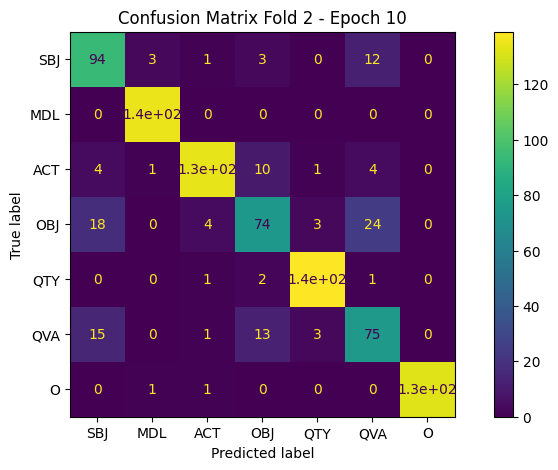

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,113.0,0.831858,0.831858,0.717557,0.770492
MDL,135.0,1.000000,1.000000,0.964286,0.981818
ACT,154.0,0.870130,0.870130,0.943662,0.905405
OBJ,123.0,0.601626,0.601626,0.725490,0.657778
QTY,143.0,0.972028,0.972028,0.952055,0.961938
QVA,107.0,0.700935,0.700935,0.646552,0.672646
O,134.0,0.985075,0.985075,1.000000,0.992481


1it [02:57, 131.32s/it]

Epoch 11 / 30


==:==:==Train==:==:==: 30it [00:02, 10.21it/s]


Average Loss Train: 0.19723680019378662


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [03:01, 131.32s/it]

Average Loss Validation: 0.10559977425469293
Time 3.6103410720825195

Epoch 12 / 30


==:==:==Train==:==:==: 30it [00:01, 18.01it/s]


Average Loss Train: 0.18110703031222025


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [03:03, 131.32s/it]

Average Loss Validation: 0.0993921160697937
Time 2.3203635215759277

Epoch 13 / 30


==:==:==Train==:==:==: 30it [00:02, 10.17it/s]


Average Loss Train: 0.1744961867729823


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [03:07, 131.32s/it]

Average Loss Validation: 0.09212726520167457
Time 3.631775140762329

Epoch 14 / 30


==:==:==Train==:==:==: 30it [00:02, 10.16it/s]


Average Loss Train: 0.17034608125686646


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [03:11, 131.32s/it]

Average Loss Validation: 0.08597415023379856
Time 3.624438524246216

Epoch 15 / 30


==:==:==Train==:==:==: 30it [00:02, 10.29it/s]


Average Loss Train: 0.16074887315432232


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.0810725407467948
Time 3.5871307849884033

Debug Amount: tensor([113., 135., 154., 123., 143., 107., 134.])


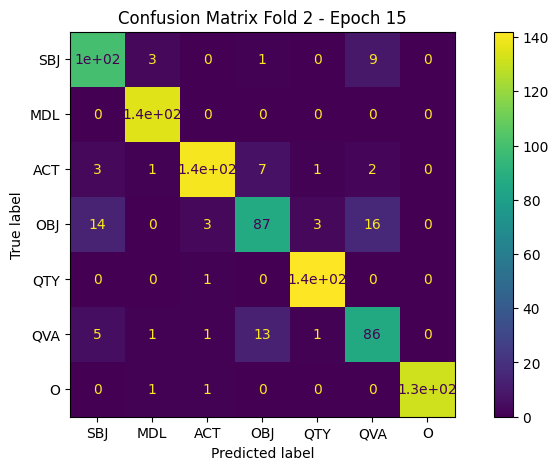

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,113.0,0.884956,0.884956,0.819672,0.851064
MDL,135.0,1.000000,1.000000,0.957447,0.978261
ACT,154.0,0.909091,0.909091,0.958904,0.933333
OBJ,123.0,0.707317,0.707317,0.805556,0.753247
QTY,143.0,0.993007,0.993007,0.965986,0.979310
QVA,107.0,0.803738,0.803738,0.761062,0.781818
O,134.0,0.985075,0.985075,1.000000,0.992481


1it [03:17, 131.32s/it]

Epoch 16 / 30


==:==:==Train==:==:==: 30it [00:02, 10.12it/s]


Average Loss Train: 0.1505287100871404


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [03:20, 131.32s/it]

Average Loss Validation: 0.07679783801237743
Time 3.634506940841675

Epoch 17 / 30


==:==:==Train==:==:==: 30it [00:02, 10.14it/s]


Average Loss Train: 0.15187879701455434


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [03:24, 131.32s/it]

Average Loss Validation: 0.07700182828638288
Time 3.6465487480163574

Epoch 18 / 30


==:==:==Train==:==:==: 30it [00:02, 10.26it/s]


Average Loss Train: 0.14617249270280203


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [03:28, 131.32s/it]

Average Loss Validation: 0.07161409325069851
Time 3.5527420043945312

Epoch 19 / 30


==:==:==Train==:==:==: 30it [00:03,  9.96it/s]


Average Loss Train: 0.14475026329358417


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [03:31, 131.32s/it]

Average Loss Validation: 0.06902737584378985
Time 3.685201406478882

Epoch 20 / 30


==:==:==Train==:==:==: 30it [00:02, 10.09it/s]


Average Loss Train: 0.13795193235079448


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.06633866329987843
Time 3.6497366428375244

Debug Amount: tensor([113., 135., 154., 123., 143., 107., 134.])


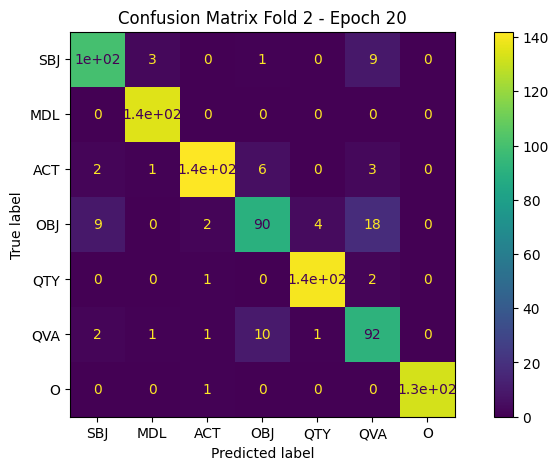

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,113.0,0.884956,0.884956,0.884956,0.884956
MDL,135.0,1.000000,1.000000,0.964286,0.981818
ACT,154.0,0.922078,0.922078,0.965986,0.943522
OBJ,123.0,0.731707,0.731707,0.841121,0.782609
QTY,143.0,0.979021,0.979021,0.965517,0.972222
QVA,107.0,0.859813,0.859813,0.741935,0.796537
O,134.0,0.992537,0.992537,1.000000,0.996255


1it [03:37, 131.32s/it]

Epoch 21 / 30


==:==:==Train==:==:==: 30it [00:02, 10.12it/s]


Average Loss Train: 0.13726264735062918


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [03:41, 131.32s/it]

Average Loss Validation: 0.06728939049773747
Time 3.6444833278656006

Epoch 22 / 30


==:==:==Train==:==:==: 30it [00:03,  9.84it/s]


Average Loss Train: 0.13709111015001932


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [03:45, 131.32s/it]

Average Loss Validation: 0.06145500640074412
Time 3.7212064266204834

Epoch 23 / 30


==:==:==Train==:==:==: 30it [00:02, 10.06it/s]


Average Loss Train: 0.12420326371987661


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [03:48, 131.32s/it]

Average Loss Validation: 0.060932889580726624
Time 3.6522703170776367

Epoch 24 / 30


==:==:==Train==:==:==: 30it [00:02, 10.16it/s]


Average Loss Train: 0.12597455978393554


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [03:52, 131.32s/it]

Average Loss Validation: 0.05944776866171095
Time 3.6299943923950195

Epoch 25 / 30


==:==:==Train==:==:==: 30it [00:02, 10.06it/s]


Average Loss Train: 0.12110112806161245


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.05715708600150214
Time 3.6342053413391113

Debug Amount: tensor([113., 135., 154., 123., 143., 107., 134.])


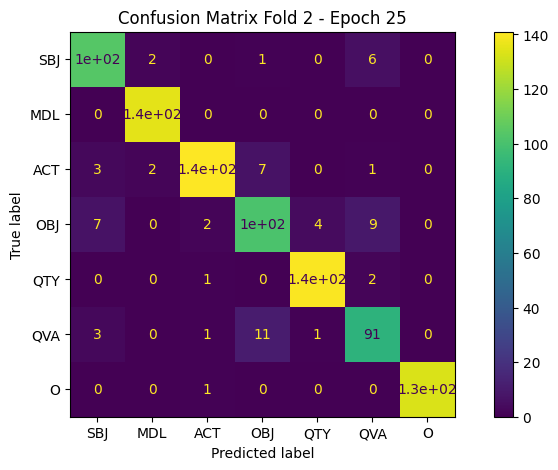

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,113.0,0.920354,0.920354,0.888889,0.904348
MDL,135.0,1.000000,1.000000,0.971223,0.985401
ACT,154.0,0.915584,0.915584,0.965753,0.940000
OBJ,123.0,0.821138,0.821138,0.841667,0.831276
QTY,143.0,0.979021,0.979021,0.965517,0.972222
QVA,107.0,0.850467,0.850467,0.834862,0.842593
O,134.0,0.992537,0.992537,1.000000,0.996255


1it [03:58, 131.32s/it]

Epoch 26 / 30


==:==:==Train==:==:==: 30it [00:02, 10.13it/s]


Average Loss Train: 0.12219329277674357


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [04:02, 131.32s/it]

Average Loss Validation: 0.05634557538562351
Time 3.6460471153259277

Epoch 27 / 30


==:==:==Train==:==:==: 30it [00:02, 10.03it/s]


Average Loss Train: 0.11877203484376271


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [04:05, 131.32s/it]

Average Loss Validation: 0.05465135474999746
Time 3.681088924407959

Epoch 28 / 30


==:==:==Train==:==:==: 30it [00:02, 10.16it/s]


Average Loss Train: 0.11551075875759124


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [04:09, 131.32s/it]

Average Loss Validation: 0.05748977594905429
Time 3.624586582183838

Epoch 29 / 30


==:==:==Train==:==:==: 30it [00:02, 10.08it/s]


Average Loss Train: 0.11045798858006796


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [04:13, 131.32s/it]

Average Loss Validation: 0.05167169041103787
Time 3.636904001235962

Epoch 30 / 30


==:==:==Train==:==:==: 30it [00:02, 10.11it/s]


Average Loss Train: 0.11083727180957795


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.05087411238087548
Time 3.6406190395355225

Debug Amount: tensor([113., 135., 154., 123., 143., 107., 134.])


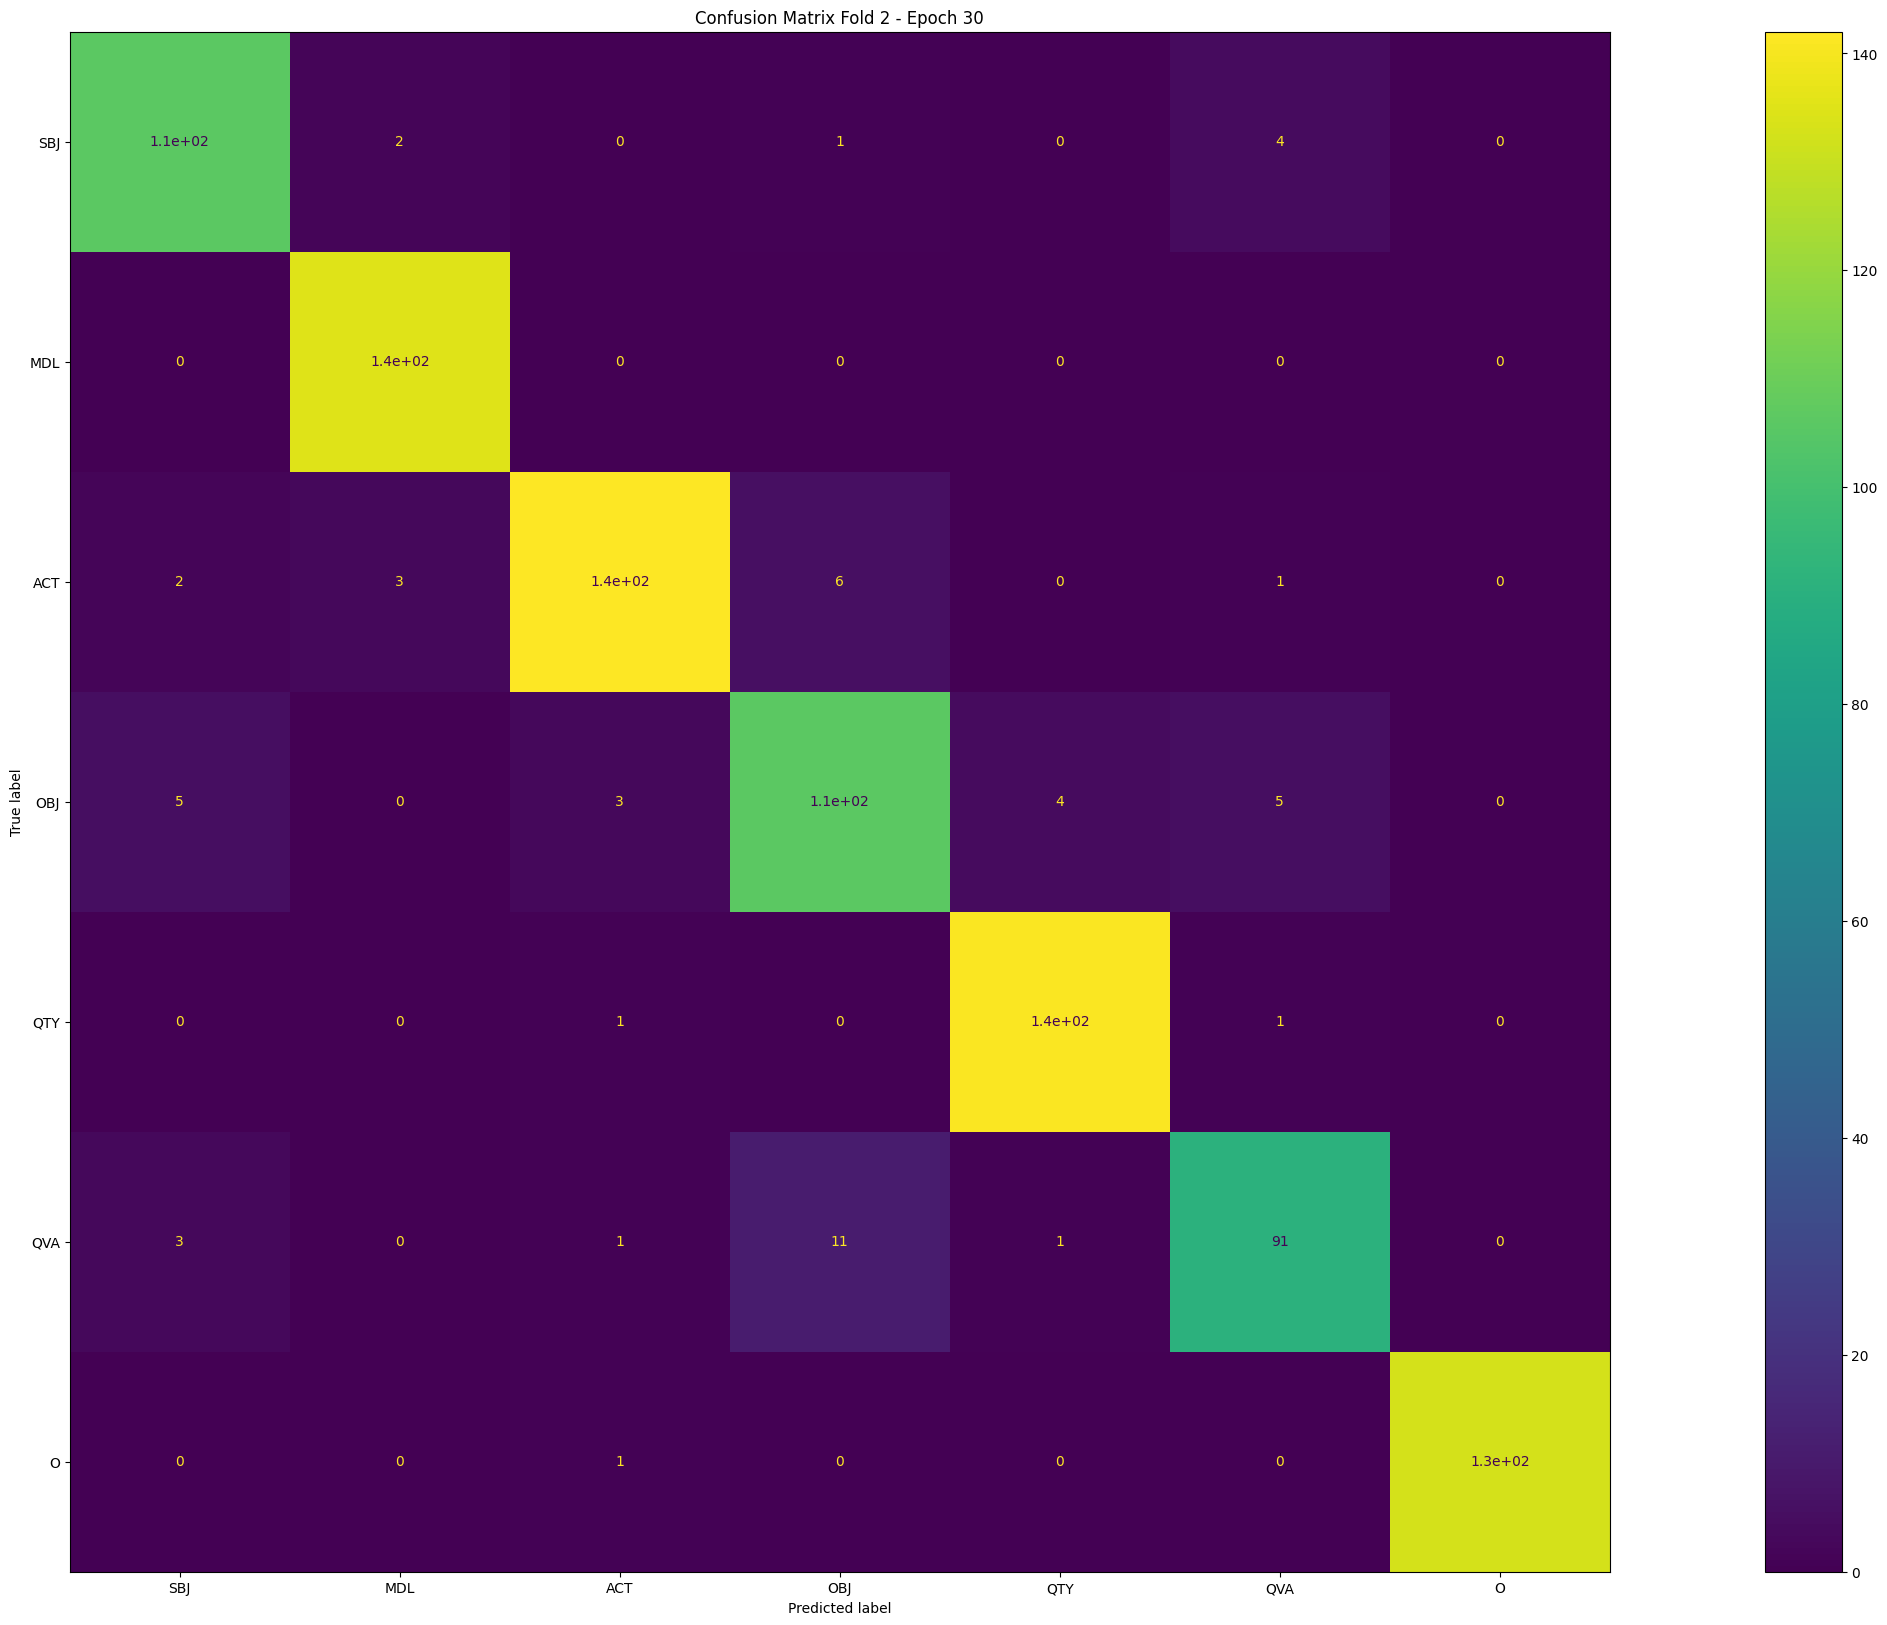

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,113.0,0.938053,0.938053,0.913793,0.925764
MDL,135.0,1.000000,1.000000,0.964286,0.981818
ACT,154.0,0.922078,0.922078,0.959459,0.940397
OBJ,123.0,0.861789,0.861789,0.854839,0.858300
QTY,143.0,0.986014,0.986014,0.965753,0.975779
QVA,107.0,0.850467,0.850467,0.892157,0.870813
O,134.0,0.992537,0.992537,1.000000,0.996255


100%|███████████████████████████████████████████| 30/30 [02:01<00:00,  4.06s/it]
2it [04:19, 129.43s/it]

=====:=====:=====:=====:===== Fold 3 =====:=====:=====:=====:=====


Some weights of BertForTokenClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2it [04:23, 129.43s/it]

Fold 3 Ready


2it [04:23, 129.43s/it]

Epoch 1 / 30


==:==:==Train==:==:==: 30it [00:02, 10.46it/s]


Average Loss Train: 0.6524539232254029


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [04:27, 129.43s/it]

Average Loss Validation: 0.5878789954715304
Time 3.544059991836548

Epoch 2 / 30


==:==:==Train==:==:==: 30it [00:02, 10.11it/s]


Average Loss Train: 0.5847136497497558


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [04:31, 129.43s/it]

Average Loss Validation: 0.49148555596669513
Time 3.665858268737793

Epoch 3 / 30


==:==:==Train==:==:==: 30it [00:03,  9.89it/s]


Average Loss Train: 0.5139466404914856


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [04:34, 129.43s/it]

Average Loss Validation: 0.4036315944459703
Time 3.7173783779144287

Epoch 4 / 30


==:==:==Train==:==:==: 30it [00:02, 10.06it/s]


Average Loss Train: 0.4506921092669169


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [04:38, 129.43s/it]

Average Loss Validation: 0.3246192998356289
Time 3.637705087661743

Epoch 5 / 30


==:==:==Train==:==:==: 30it [00:03,  9.94it/s]


Average Loss Train: 0.3885449568430583


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.2579786909951104
Time 3.652205228805542

Debug Amount: tensor([120., 141., 154., 119., 144., 116., 136.])


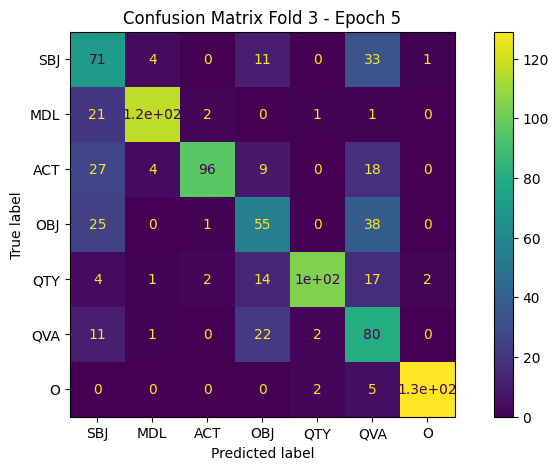

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,120.0,0.591667,0.591667,0.446541,0.508961
MDL,141.0,0.822695,0.822695,0.920635,0.868914
ACT,154.0,0.623377,0.623377,0.950495,0.752941
OBJ,119.0,0.462185,0.462185,0.495495,0.478261
QTY,144.0,0.722222,0.722222,0.954128,0.822134
QVA,116.0,0.689655,0.689655,0.416667,0.519481
O,136.0,0.948529,0.948529,0.977273,0.962687


2it [04:43, 129.43s/it]

Epoch 6 / 30


==:==:==Train==:==:==: 30it [00:02, 10.11it/s]


Average Loss Train: 0.3297757089138031


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [04:47, 129.43s/it]

Average Loss Validation: 0.20706013838450113
Time 3.595784902572632

Epoch 7 / 30


==:==:==Train==:==:==: 30it [00:02, 10.44it/s]


Average Loss Train: 0.2868055542310079


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [04:51, 129.43s/it]

Average Loss Validation: 0.17108635107676187
Time 3.545750617980957

Epoch 8 / 30


==:==:==Train==:==:==: 30it [00:02, 10.88it/s]


Average Loss Train: 0.25029219388961793


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [04:54, 129.43s/it]

Average Loss Validation: 0.14699635240766737
Time 3.4257731437683105

Epoch 9 / 30


==:==:==Train==:==:==: 30it [00:02, 10.18it/s]


Average Loss Train: 0.22397100925445557


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [04:58, 129.43s/it]

Average Loss Validation: 0.1286313666237725
Time 3.586118221282959

Epoch 10 / 30


==:==:==Train==:==:==: 30it [00:02, 10.22it/s]


Average Loss Train: 0.20382351477940877


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.11682165993584527
Time 3.5876731872558594

Debug Amount: tensor([120., 141., 154., 119., 144., 116., 136.])


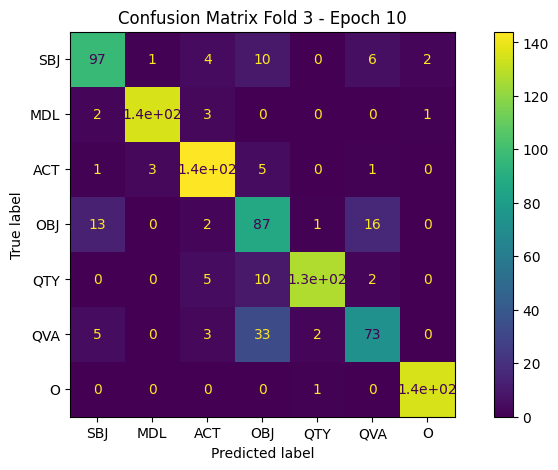

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,120.0,0.808333,0.808333,0.822034,0.815126
MDL,141.0,0.957447,0.957447,0.971223,0.964286
ACT,154.0,0.935065,0.935065,0.894410,0.914286
OBJ,119.0,0.731092,0.731092,0.600000,0.659091
QTY,144.0,0.881944,0.881944,0.969466,0.923636
QVA,116.0,0.629310,0.629310,0.744898,0.682243
O,136.0,0.992647,0.992647,0.978261,0.985401


2it [05:04, 129.43s/it]

Epoch 11 / 30


==:==:==Train==:==:==: 30it [00:02, 10.19it/s]


Average Loss Train: 0.19161755641301473


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [05:07, 129.43s/it]

Average Loss Validation: 0.10654267999860975
Time 3.6205391883850098

Epoch 12 / 30


==:==:==Train==:==:==: 30it [00:02, 10.18it/s]


Average Loss Train: 0.17899934848149618


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [05:11, 129.43s/it]

Average Loss Validation: 0.10049317611588372
Time 3.6267898082733154

Epoch 13 / 30


==:==:==Train==:==:==: 30it [00:02, 10.21it/s]


Average Loss Train: 0.1700536608695984


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [05:14, 129.43s/it]

Average Loss Validation: 0.09391836987601386
Time 3.596173048019409

Epoch 14 / 30


==:==:==Train==:==:==: 30it [00:03,  9.93it/s]


Average Loss Train: 0.16435850163300833


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [05:18, 129.43s/it]

Average Loss Validation: 0.09010161459445953
Time 3.6934525966644287

Epoch 15 / 30


==:==:==Train==:==:==: 30it [00:02, 10.03it/s]


Average Loss Train: 0.16025692423184712


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.0873497939772076
Time 3.622777223587036

Debug Amount: tensor([120., 141., 154., 119., 144., 116., 136.])


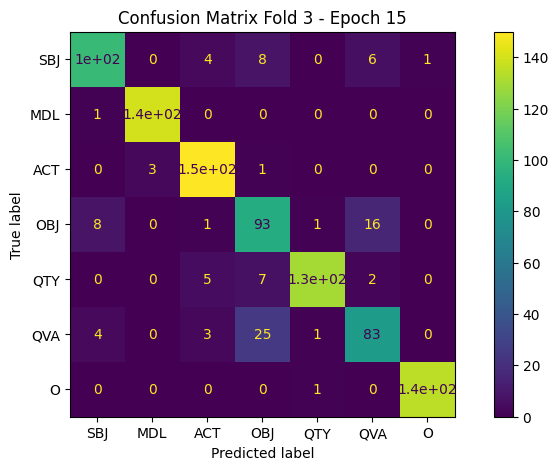

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,120.0,0.841667,0.841667,0.885965,0.863248
MDL,141.0,0.992908,0.992908,0.979021,0.985915
ACT,154.0,0.974026,0.974026,0.920245,0.946372
OBJ,119.0,0.781513,0.781513,0.694030,0.735178
QTY,144.0,0.902778,0.902778,0.977444,0.938628
QVA,116.0,0.715517,0.715517,0.775701,0.744395
O,136.0,0.992647,0.992647,0.992647,0.992647


2it [05:24, 129.43s/it]

Epoch 16 / 30


==:==:==Train==:==:==: 30it [00:02, 10.19it/s]


Average Loss Train: 0.15344819923241934


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [05:28, 129.43s/it]

Average Loss Validation: 0.0836732569668028
Time 3.6338067054748535

Epoch 17 / 30


==:==:==Train==:==:==: 30it [00:02, 10.10it/s]


Average Loss Train: 0.1463231364885966


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [05:31, 129.43s/it]

Average Loss Validation: 0.08308051029841106
Time 3.6173722743988037

Epoch 18 / 30


==:==:==Train==:==:==: 30it [00:02, 10.14it/s]


Average Loss Train: 0.14011996487776437


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [05:35, 129.43s/it]

Average Loss Validation: 0.08034677803516388
Time 3.6661183834075928

Epoch 19 / 30


==:==:==Train==:==:==: 30it [00:03,  9.95it/s]


Average Loss Train: 0.14200266500314077


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [05:39, 129.43s/it]

Average Loss Validation: 0.08022644784715441
Time 3.649698257446289

Epoch 20 / 30


==:==:==Train==:==:==: 30it [00:02, 10.08it/s]


Average Loss Train: 0.13345452745755512


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.07508725755744511
Time 3.6139843463897705

Debug Amount: tensor([120., 141., 154., 119., 144., 116., 136.])


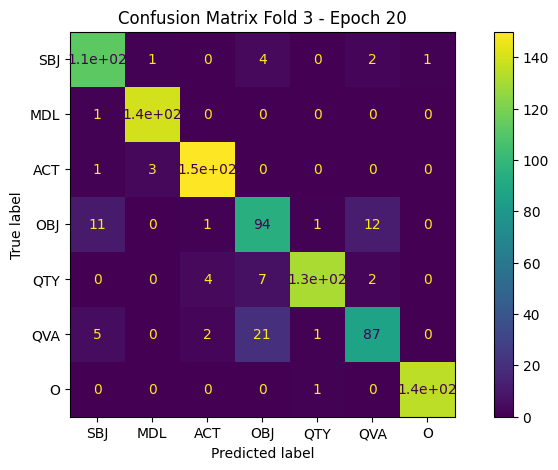

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,120.0,0.933333,0.933333,0.861538,0.896000
MDL,141.0,0.992908,0.992908,0.972222,0.982456
ACT,154.0,0.974026,0.974026,0.955414,0.964630
OBJ,119.0,0.789916,0.789916,0.746032,0.767347
QTY,144.0,0.909722,0.909722,0.977612,0.942446
QVA,116.0,0.750000,0.750000,0.844660,0.794520
O,136.0,0.992647,0.992647,0.992647,0.992647


2it [05:45, 129.43s/it]

Epoch 21 / 30


==:==:==Train==:==:==: 30it [00:02, 10.14it/s]


Average Loss Train: 0.13507472475369772


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [05:49, 129.43s/it]

Average Loss Validation: 0.0725368062655131
Time 3.635915517807007

Epoch 22 / 30


==:==:==Train==:==:==: 30it [00:02, 10.04it/s]


Average Loss Train: 0.1286342591047287


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [05:52, 129.43s/it]

Average Loss Validation: 0.07332869370778401
Time 3.671626567840576

Epoch 23 / 30


==:==:==Train==:==:==: 30it [00:02, 10.13it/s]


Average Loss Train: 0.1258641908566157


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [05:56, 129.43s/it]

Average Loss Validation: 0.0695230182674196
Time 3.646289348602295

Epoch 24 / 30


==:==:==Train==:==:==: 30it [00:03,  9.95it/s]


Average Loss Train: 0.1204160213470459


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [06:00, 129.43s/it]

Average Loss Validation: 0.06909388138188256
Time 3.659904956817627

Epoch 25 / 30


==:==:==Train==:==:==: 30it [00:03,  9.99it/s]


Average Loss Train: 0.12387078801790873


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.06829343570603265
Time 3.69327712059021

Debug Amount: tensor([120., 141., 154., 119., 144., 116., 136.])


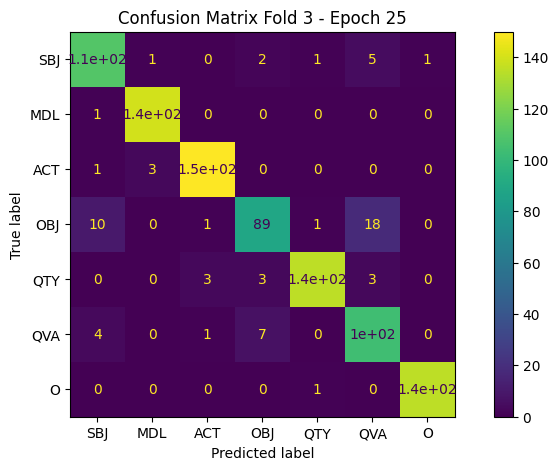

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,120.0,0.916667,0.916667,0.873016,0.894309
MDL,141.0,0.992908,0.992908,0.972222,0.982456
ACT,154.0,0.974026,0.974026,0.967742,0.970874
OBJ,119.0,0.747899,0.747899,0.881188,0.809091
QTY,144.0,0.937500,0.937500,0.978261,0.957447
QVA,116.0,0.896552,0.896552,0.800000,0.845528
O,136.0,0.992647,0.992647,0.992647,0.992647


2it [06:06, 129.43s/it]

Epoch 26 / 30


==:==:==Train==:==:==: 30it [00:03,  9.76it/s]


Average Loss Train: 0.1163845141728719


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [06:10, 129.43s/it]

Average Loss Validation: 0.06400912172264522
Time 3.7675161361694336

Epoch 27 / 30


==:==:==Train==:==:==: 30it [00:03, 10.00it/s]


Average Loss Train: 0.11163859268029531


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [06:14, 129.43s/it]

Average Loss Validation: 0.059636137551731534
Time 3.6577394008636475

Epoch 28 / 30


==:==:==Train==:==:==: 30it [00:02, 10.14it/s]


Average Loss Train: 0.1134149044752121


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [06:17, 129.43s/it]

Average Loss Validation: 0.0577523915304078
Time 3.6344943046569824

Epoch 29 / 30


==:==:==Train==:==:==: 30it [00:02, 10.27it/s]


Average Loss Train: 0.11215656797091166


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [06:21, 129.43s/it]

Average Loss Validation: 0.0576776878701316
Time 3.5987205505371094

Epoch 30 / 30


==:==:==Train==:==:==: 30it [00:02, 10.56it/s]


Average Loss Train: 0.10835942725340525


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.05803387694888645
Time 3.4849438667297363

Debug Amount: tensor([120., 141., 154., 119., 144., 116., 136.])


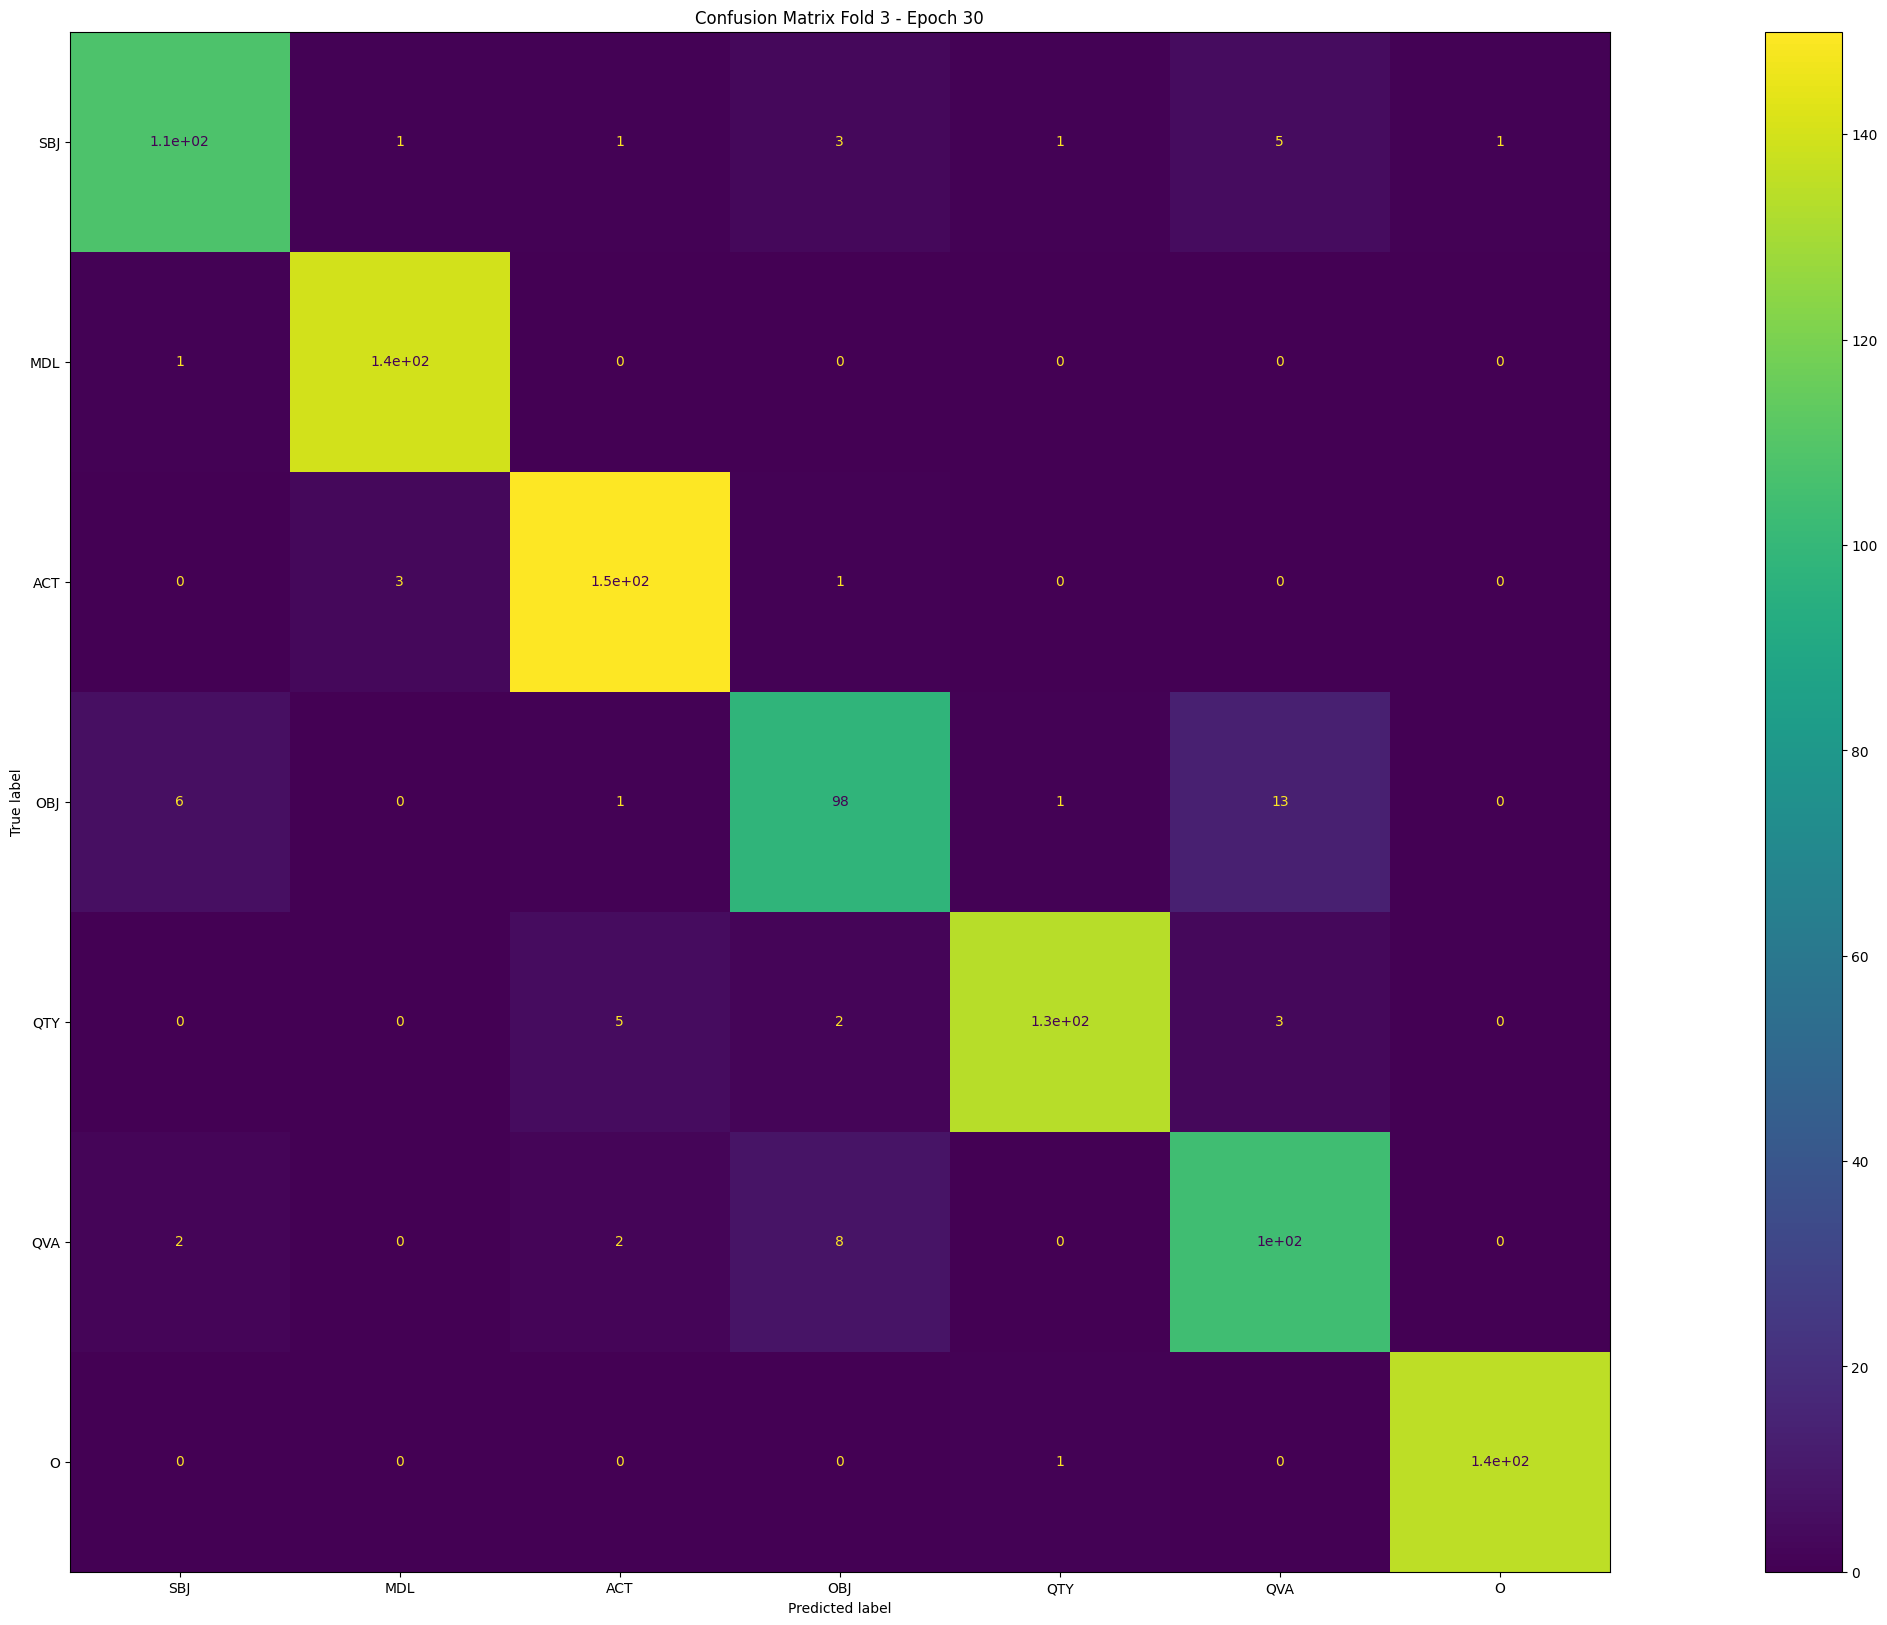

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,120.0,0.900000,0.900000,0.923077,0.911392
MDL,141.0,0.992908,0.992908,0.972222,0.982456
ACT,154.0,0.974026,0.974026,0.943396,0.958466
OBJ,119.0,0.823529,0.823529,0.875000,0.848485
QTY,144.0,0.930556,0.930556,0.978102,0.953737
QVA,116.0,0.896552,0.896552,0.832000,0.863071
O,136.0,0.992647,0.992647,0.992647,0.992647


100%|███████████████████████████████████████████| 30/30 [02:03<00:00,  4.13s/it]
3it [06:27, 128.90s/it]

=====:=====:=====:=====:===== Fold 4 =====:=====:=====:=====:=====


Some weights of BertForTokenClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
3it [06:32, 128.90s/it]

Fold 4 Ready


3it [06:32, 128.90s/it]

Epoch 1 / 30


==:==:==Train==:==:==: 30it [00:02, 10.20it/s]


Average Loss Train: 0.6543052593866984


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [06:35, 128.90s/it]

Average Loss Validation: 0.5923566023508707
Time 3.601024627685547

Epoch 2 / 30


==:==:==Train==:==:==: 30it [00:02, 10.13it/s]


Average Loss Train: 0.583403484026591


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [06:39, 128.90s/it]

Average Loss Validation: 0.5020337767071195
Time 3.6350250244140625

Epoch 3 / 30


==:==:==Train==:==:==: 30it [00:02, 10.18it/s]


Average Loss Train: 0.5159156163533528


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [06:43, 128.90s/it]

Average Loss Validation: 0.41873886850145126
Time 3.6240909099578857

Epoch 4 / 30


==:==:==Train==:==:==: 30it [00:02, 10.25it/s]


Average Loss Train: 0.4511421958605448


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [06:46, 128.90s/it]

Average Loss Validation: 0.34569476710425484
Time 3.5832583904266357

Epoch 5 / 30


==:==:==Train==:==:==: 30it [00:02, 10.10it/s]


Average Loss Train: 0.3844051480293274


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.2831006381246779
Time 3.66642689704895

Debug Amount: tensor([115., 139., 153., 117., 146., 114., 132.])


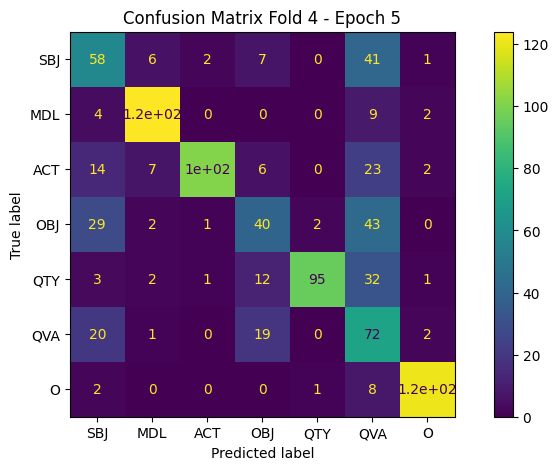

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,115.0,0.504348,0.504348,0.446154,0.473469
MDL,139.0,0.892086,0.892086,0.873239,0.882562
ACT,153.0,0.660131,0.660131,0.961905,0.782946
OBJ,117.0,0.341880,0.341880,0.476190,0.398010
QTY,146.0,0.650685,0.650685,0.969388,0.778689
QVA,114.0,0.631579,0.631579,0.315789,0.421053
O,132.0,0.916667,0.916667,0.937984,0.927203


3it [06:52, 128.90s/it]

Epoch 6 / 30


==:==:==Train==:==:==: 30it [00:02, 10.18it/s]


Average Loss Train: 0.3340508222579956


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [06:55, 128.90s/it]

Average Loss Validation: 0.23414191272523668
Time 3.6286990642547607

Epoch 7 / 30


==:==:==Train==:==:==: 30it [00:02, 10.17it/s]


Average Loss Train: 0.2859215001265208


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [06:59, 128.90s/it]

Average Loss Validation: 0.19707374109162223
Time 3.6303317546844482

Epoch 8 / 30


==:==:==Train==:==:==: 30it [00:02, 10.27it/s]


Average Loss Train: 0.2509825527667999


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [07:03, 128.90s/it]

Average Loss Validation: 0.1728413767284817
Time 3.5959653854370117

Epoch 9 / 30


==:==:==Train==:==:==: 30it [00:03,  9.91it/s]


Average Loss Train: 0.22109102408091227


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [07:06, 128.90s/it]

Average Loss Validation: 0.15332830945650736
Time 3.672787666320801

Epoch 10 / 30


==:==:==Train==:==:==: 30it [00:03,  9.99it/s]


Average Loss Train: 0.20029809375603994


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.14164665672514173
Time 3.6506245136260986

Debug Amount: tensor([115., 139., 153., 117., 146., 114., 132.])


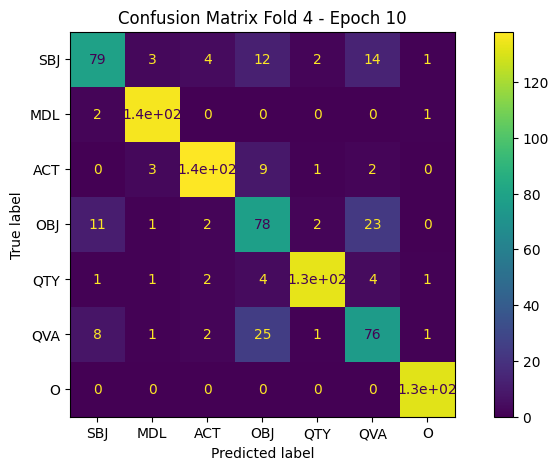

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,115.0,0.686957,0.686957,0.782178,0.731481
MDL,139.0,0.978417,0.978417,0.937931,0.957747
ACT,153.0,0.901961,0.901961,0.932432,0.916943
OBJ,117.0,0.666667,0.666667,0.609375,0.636735
QTY,146.0,0.910959,0.910959,0.956835,0.933333
QVA,114.0,0.666667,0.666667,0.638655,0.652361
O,132.0,1.000000,1.000000,0.970588,0.985075


3it [07:12, 128.90s/it]

Epoch 11 / 30


==:==:==Train==:==:==: 30it [00:03,  9.96it/s]


Average Loss Train: 0.18218208948771158


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [07:16, 128.90s/it]

Average Loss Validation: 0.1356412967046102
Time 3.680215358734131

Epoch 12 / 30


==:==:==Train==:==:==: 30it [00:03,  9.96it/s]


Average Loss Train: 0.1749157081047694


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [07:20, 128.90s/it]

Average Loss Validation: 0.12376582456959619
Time 3.6943576335906982

Epoch 13 / 30


==:==:==Train==:==:==: 30it [00:03,  9.94it/s]


Average Loss Train: 0.16358386377493542


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [07:23, 128.90s/it]

Average Loss Validation: 0.11821678611967298
Time 3.6707704067230225

Epoch 14 / 30


==:==:==Train==:==:==: 30it [00:02, 10.15it/s]


Average Loss Train: 0.15580744842688243


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [07:27, 128.90s/it]

Average Loss Validation: 0.11456585923830669
Time 3.6587939262390137

Epoch 15 / 30


==:==:==Train==:==:==: 30it [00:02, 10.09it/s]


Average Loss Train: 0.1535098264614741


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.11040885084205204
Time 3.6313018798828125

Debug Amount: tensor([115., 139., 153., 117., 146., 114., 132.])


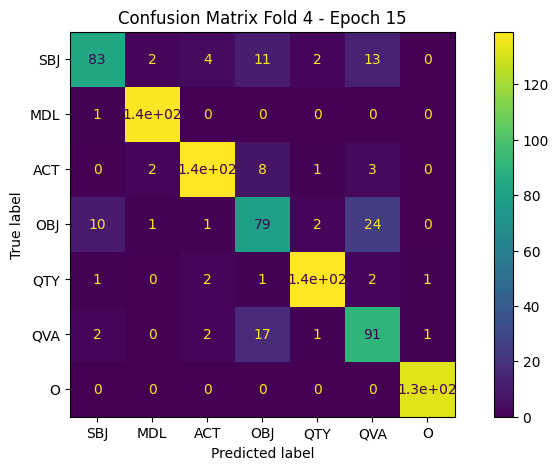

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,115.0,0.721739,0.721739,0.855670,0.783019
MDL,139.0,0.992806,0.992806,0.965035,0.978723
ACT,153.0,0.908497,0.908497,0.939189,0.923588
OBJ,117.0,0.675214,0.675214,0.681035,0.678112
QTY,146.0,0.952055,0.952055,0.958621,0.955326
QVA,114.0,0.798246,0.798246,0.684211,0.736842
O,132.0,1.000000,1.000000,0.985075,0.992481


3it [07:33, 128.90s/it]

Epoch 16 / 30


==:==:==Train==:==:==: 30it [00:02, 10.19it/s]


Average Loss Train: 0.14345207611719768


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [07:37, 128.90s/it]

Average Loss Validation: 0.110119233528773
Time 3.622662305831909

Epoch 17 / 30


==:==:==Train==:==:==: 30it [00:02, 10.06it/s]


Average Loss Train: 0.1421450396378835


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [07:40, 128.90s/it]

Average Loss Validation: 0.1008309092786577
Time 3.6590452194213867

Epoch 18 / 30


==:==:==Train==:==:==: 30it [00:02, 10.02it/s]


Average Loss Train: 0.1367741992076238


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [07:44, 128.90s/it]

Average Loss Validation: 0.10040642155541314
Time 3.6641643047332764

Epoch 19 / 30


==:==:==Train==:==:==: 30it [00:03,  9.89it/s]


Average Loss Train: 0.1358950932820638


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [07:48, 128.90s/it]

Average Loss Validation: 0.09762856695387098
Time 3.6815075874328613

Epoch 20 / 30


==:==:==Train==:==:==: 30it [00:02, 10.15it/s]


Average Loss Train: 0.1239587406317393


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.09702868262926738
Time 3.630112409591675

Debug Amount: tensor([115., 139., 153., 117., 146., 114., 132.])


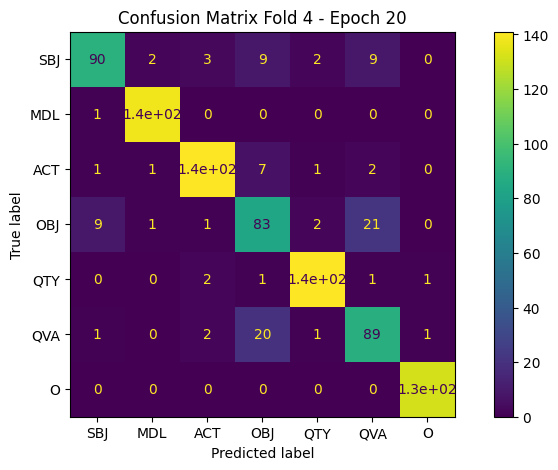

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,115.0,0.782609,0.782609,0.882353,0.829493
MDL,139.0,0.992806,0.992806,0.971831,0.982206
ACT,153.0,0.921569,0.921569,0.946309,0.933775
OBJ,117.0,0.709402,0.709402,0.691667,0.700422
QTY,146.0,0.965753,0.965753,0.959184,0.962457
QVA,114.0,0.780702,0.780702,0.729508,0.754237
O,132.0,1.000000,1.000000,0.985075,0.992481


3it [07:54, 128.90s/it]

Epoch 21 / 30


==:==:==Train==:==:==: 30it [00:02, 10.14it/s]


Average Loss Train: 0.1226458470026652


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [07:58, 128.90s/it]

Average Loss Validation: 0.0954730792178048
Time 3.6591689586639404

Epoch 22 / 30


==:==:==Train==:==:==: 30it [00:03,  9.66it/s]


Average Loss Train: 0.1174880713224411


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [08:01, 128.90s/it]

Average Loss Validation: 0.095422410302692
Time 3.7945291996002197

Epoch 23 / 30


==:==:==Train==:==:==: 30it [00:03,  9.91it/s]


Average Loss Train: 0.1193763275941213


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [08:05, 128.90s/it]

Average Loss Validation: 0.09339328275786506
Time 3.7142844200134277

Epoch 24 / 30


==:==:==Train==:==:==: 30it [00:02, 10.11it/s]


Average Loss Train: 0.1199058473110199


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [08:09, 128.90s/it]

Average Loss Validation: 0.09243176215224796
Time 3.631481409072876

Epoch 25 / 30


==:==:==Train==:==:==: 30it [00:03,  9.84it/s]


Average Loss Train: 0.11286439696947734


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.09022035201390584
Time 3.742964267730713

Debug Amount: tensor([115., 139., 153., 117., 146., 114., 132.])


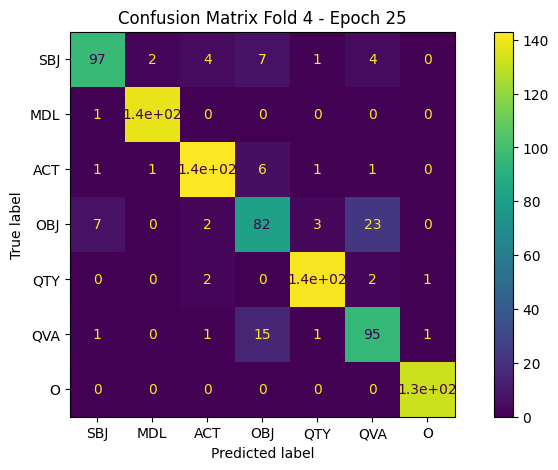

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,115.0,0.843478,0.843478,0.906542,0.873874
MDL,139.0,0.992806,0.992806,0.978723,0.985714
ACT,153.0,0.934641,0.934641,0.940789,0.937705
OBJ,117.0,0.700855,0.700855,0.745455,0.722467
QTY,146.0,0.965753,0.965753,0.959184,0.962457
QVA,114.0,0.833333,0.833333,0.760000,0.794979
O,132.0,1.000000,1.000000,0.985075,0.992481


3it [08:15, 128.90s/it]

Epoch 26 / 30


==:==:==Train==:==:==: 30it [00:03,  9.91it/s]


Average Loss Train: 0.10999009311199189


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [08:19, 128.90s/it]

Average Loss Validation: 0.0872996532254749
Time 3.6896543502807617

Epoch 27 / 30


==:==:==Train==:==:==: 30it [00:02, 10.18it/s]


Average Loss Train: 0.10923168311516444


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [08:22, 128.90s/it]

Average Loss Validation: 0.08568470345603095
Time 3.5944979190826416

Epoch 28 / 30


==:==:==Train==:==:==: 30it [00:02, 10.15it/s]


Average Loss Train: 0.10604537030061086


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [08:26, 128.90s/it]

Average Loss Validation: 0.0843351466788186
Time 3.6358768939971924

Epoch 29 / 30


==:==:==Train==:==:==: 30it [00:02, 10.04it/s]


Average Loss Train: 0.10118638773759206


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [08:30, 128.90s/it]

Average Loss Validation: 0.08487938344478607
Time 3.6475563049316406

Epoch 30 / 30


==:==:==Train==:==:==: 30it [00:03,  9.99it/s]


Average Loss Train: 0.1016449083884557


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.08446893261538611
Time 3.66317081451416

Debug Amount: tensor([115., 139., 153., 117., 146., 114., 132.])


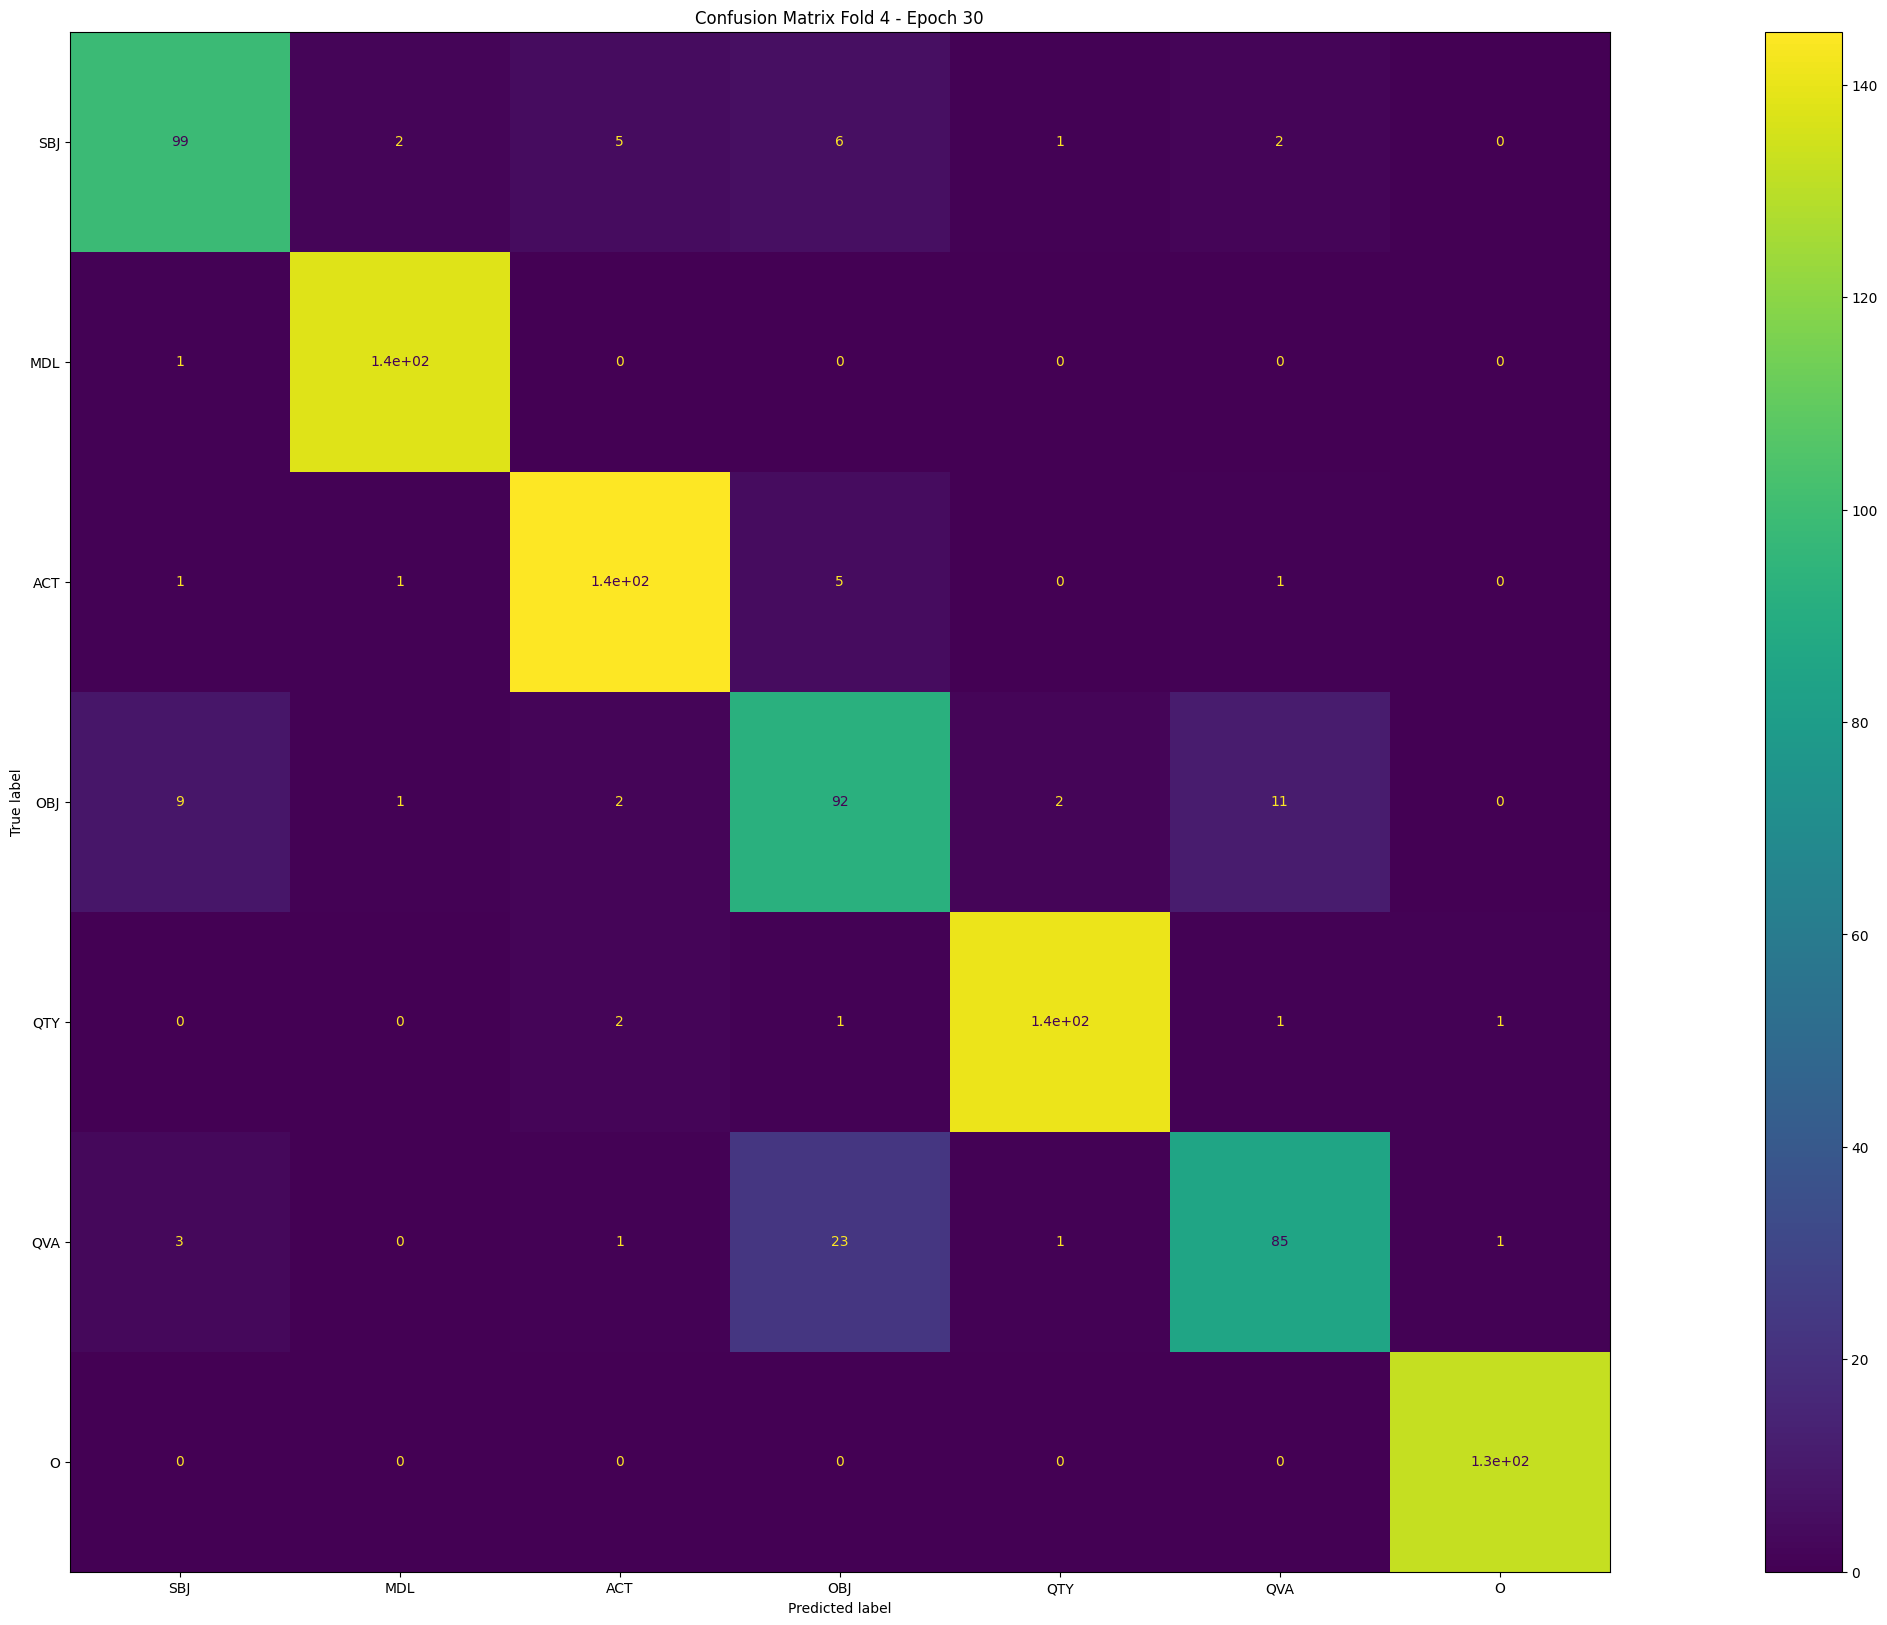

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,115.0,0.860870,0.860870,0.876106,0.868421
MDL,139.0,0.992806,0.992806,0.971831,0.982206
ACT,153.0,0.947712,0.947712,0.935484,0.941558
OBJ,117.0,0.786325,0.786325,0.724409,0.754098
QTY,146.0,0.965753,0.965753,0.972414,0.969072
QVA,114.0,0.745614,0.745614,0.850000,0.794393
O,132.0,1.000000,1.000000,0.985075,0.992481


100%|███████████████████████████████████████████| 30/30 [02:04<00:00,  4.15s/it]
4it [08:36, 129.01s/it]

=====:=====:=====:=====:===== Fold 5 =====:=====:=====:=====:=====


Some weights of BertForTokenClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
4it [08:42, 129.01s/it]

Fold 5 Ready


4it [08:42, 129.01s/it]

Epoch 1 / 30


==:==:==Train==:==:==: 30it [00:02, 10.15it/s]


Average Loss Train: 0.6431831995646159


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [08:46, 129.01s/it]

Average Loss Validation: 0.5719481706619263
Time 3.625180244445801

Epoch 2 / 30


==:==:==Train==:==:==: 30it [00:02, 10.38it/s]


Average Loss Train: 0.5726786971092224


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [08:49, 129.01s/it]

Average Loss Validation: 0.48527071211073136
Time 3.571200370788574

Epoch 3 / 30


==:==:==Train==:==:==: 30it [00:02, 10.14it/s]


Average Loss Train: 0.5075029333432516


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [08:53, 129.01s/it]

Average Loss Validation: 0.40384927060869
Time 3.606764554977417

Epoch 4 / 30


==:==:==Train==:==:==: 30it [00:02, 10.23it/s]


Average Loss Train: 0.4465114076932271


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [08:57, 129.01s/it]

Average Loss Validation: 0.33348125881618923
Time 3.6042418479919434

Epoch 5 / 30


==:==:==Train==:==:==: 30it [00:02, 10.16it/s]


Average Loss Train: 0.3870731830596924


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.2737811671362983
Time 3.616314649581909

Debug Amount: tensor([119., 140., 156., 108., 145., 114., 148.])


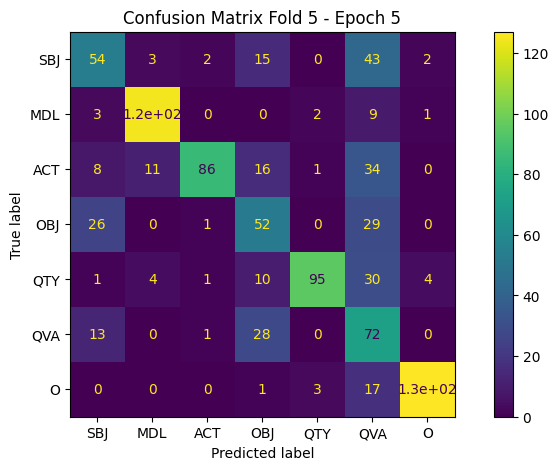

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,119.0,0.453782,0.453782,0.514286,0.482143
MDL,140.0,0.892857,0.892857,0.874126,0.883392
ACT,156.0,0.551282,0.551282,0.945055,0.696356
OBJ,108.0,0.481481,0.481481,0.426230,0.452174
QTY,145.0,0.655172,0.655172,0.940594,0.772358
QVA,114.0,0.631579,0.631579,0.307692,0.413793
O,148.0,0.858108,0.858108,0.947761,0.900709


4it [09:02, 129.01s/it]

Epoch 6 / 30


==:==:==Train==:==:==: 30it [00:02, 10.21it/s]


Average Loss Train: 0.33411011695861814


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [09:06, 129.01s/it]

Average Loss Validation: 0.22371072239345974
Time 3.6005051136016846

Epoch 7 / 30


==:==:==Train==:==:==: 30it [00:02, 10.11it/s]


Average Loss Train: 0.28905519247055056


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [09:10, 129.01s/it]

Average Loss Validation: 0.18885810176531473
Time 3.644411087036133

Epoch 8 / 30


==:==:==Train==:==:==: 30it [00:02, 10.24it/s]


Average Loss Train: 0.2558363179365794


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [09:13, 129.01s/it]

Average Loss Validation: 0.1623167163795895
Time 3.628795623779297

Epoch 9 / 30


==:==:==Train==:==:==: 30it [00:02, 10.11it/s]


Average Loss Train: 0.22822165091832478


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [09:17, 129.01s/it]

Average Loss Validation: 0.14425057172775269
Time 3.637847423553467

Epoch 10 / 30


==:==:==Train==:==:==: 30it [00:02, 10.15it/s]


Average Loss Train: 0.21307952404022218


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.13316393891970316
Time 3.6091971397399902

Debug Amount: tensor([119., 140., 156., 108., 145., 114., 148.])


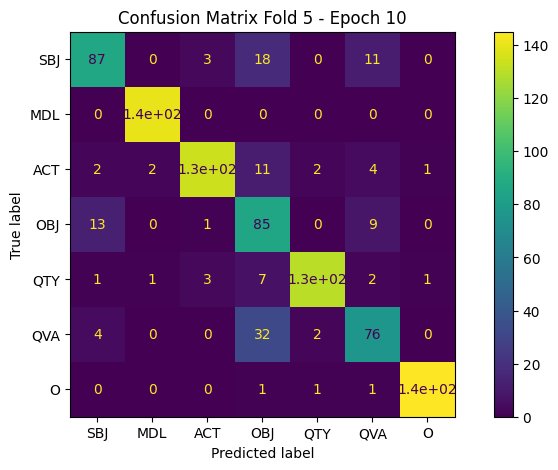

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,119.0,0.731092,0.731092,0.813084,0.769912
MDL,140.0,1.000000,1.000000,0.979021,0.989399
ACT,156.0,0.858974,0.858974,0.950355,0.902357
OBJ,108.0,0.787037,0.787037,0.551948,0.648855
QTY,145.0,0.896552,0.896552,0.962963,0.928571
QVA,114.0,0.666667,0.666667,0.737864,0.700461
O,148.0,0.979730,0.979730,0.986395,0.983051


4it [09:23, 129.01s/it]

Epoch 11 / 30


==:==:==Train==:==:==: 30it [00:02, 10.11it/s]


Average Loss Train: 0.19253166317939757


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [09:27, 129.01s/it]

Average Loss Validation: 0.12110146880149841
Time 3.6284544467926025

Epoch 12 / 30


==:==:==Train==:==:==: 30it [00:02, 10.18it/s]


Average Loss Train: 0.1791416585445404


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [09:30, 129.01s/it]

Average Loss Validation: 0.11227019959025913
Time 3.6136770248413086

Epoch 13 / 30


==:==:==Train==:==:==: 30it [00:02, 10.22it/s]


Average Loss Train: 0.17420693437258403


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [09:34, 129.01s/it]

Average Loss Validation: 0.11702422632111444
Time 3.592808246612549

Epoch 14 / 30


==:==:==Train==:==:==: 30it [00:02, 10.15it/s]


Average Loss Train: 0.16178765495618183


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [09:37, 129.01s/it]

Average Loss Validation: 0.1012699885500802
Time 3.603440046310425

Epoch 15 / 30


==:==:==Train==:==:==: 30it [00:02, 10.14it/s]


Average Loss Train: 0.1541913996140162


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.09822784198655023
Time 3.64811372756958

Debug Amount: tensor([119., 140., 156., 108., 145., 114., 148.])


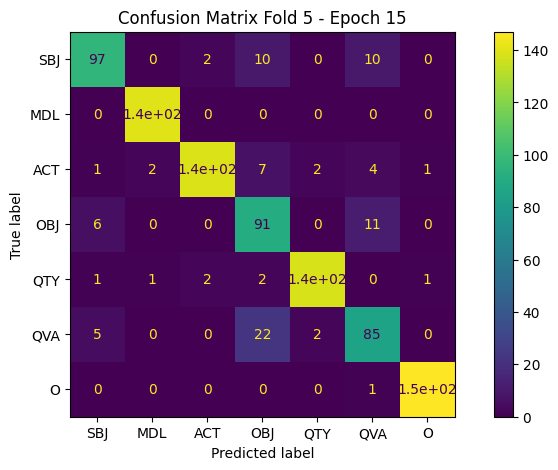

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,119.0,0.815126,0.815126,0.881818,0.847162
MDL,140.0,1.000000,1.000000,0.979021,0.989399
ACT,156.0,0.891026,0.891026,0.972028,0.929766
OBJ,108.0,0.842593,0.842593,0.689394,0.758333
QTY,145.0,0.951724,0.951724,0.971831,0.961672
QVA,114.0,0.745614,0.745614,0.765766,0.755556
O,148.0,0.993243,0.993243,0.986577,0.989899


4it [09:43, 129.01s/it]

Epoch 16 / 30


==:==:==Train==:==:==: 30it [00:02, 10.21it/s]


Average Loss Train: 0.15100918213526407


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [09:47, 129.01s/it]

Average Loss Validation: 0.09832379718621571
Time 3.6113665103912354

Epoch 17 / 30


==:==:==Train==:==:==: 30it [00:02, 10.08it/s]


Average Loss Train: 0.14419227838516235


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [09:51, 129.01s/it]

Average Loss Validation: 0.09924906988938649
Time 3.6238930225372314

Epoch 18 / 30


==:==:==Train==:==:==: 30it [00:01, 16.23it/s]


Average Loss Train: 0.13421716690063476


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [09:53, 129.01s/it]

Average Loss Validation: 0.09029880828327602
Time 2.3010246753692627

Epoch 19 / 30


==:==:==Train==:==:==: 30it [00:02, 10.09it/s]


Average Loss Train: 0.1311061958471934


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [09:57, 129.01s/it]

Average Loss Validation: 0.08968540529410045
Time 3.6476807594299316

Epoch 20 / 30


==:==:==Train==:==:==: 30it [00:02, 10.16it/s]


Average Loss Train: 0.13189307848612467


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.09001212649875218
Time 3.589467763900757

Debug Amount: tensor([119., 140., 156., 108., 145., 114., 148.])


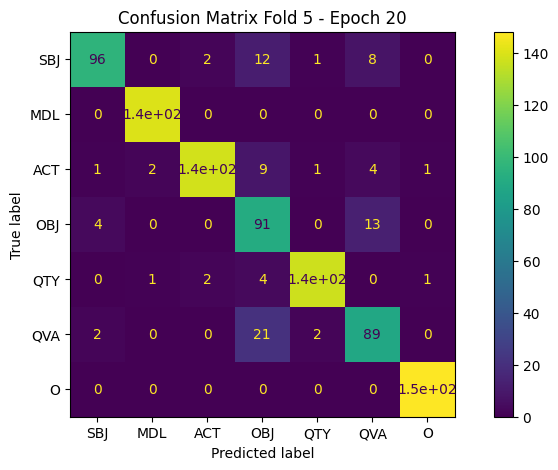

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,119.0,0.806723,0.806723,0.932039,0.864865
MDL,140.0,1.000000,1.000000,0.979021,0.989399
ACT,156.0,0.884615,0.884615,0.971831,0.926175
OBJ,108.0,0.842593,0.842593,0.664234,0.742857
QTY,145.0,0.944828,0.944828,0.971631,0.958042
QVA,114.0,0.780702,0.780702,0.780702,0.780702
O,148.0,1.000000,1.000000,0.986667,0.993289


4it [10:03, 129.01s/it]

Epoch 21 / 30


==:==:==Train==:==:==: 30it [00:02, 10.23it/s]


Average Loss Train: 0.1256249556938807


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [10:06, 129.01s/it]

Average Loss Validation: 0.0879305750131607
Time 3.58830189704895

Epoch 22 / 30


==:==:==Train==:==:==: 30it [00:02, 10.21it/s]


Average Loss Train: 0.1258605460325877


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [10:10, 129.01s/it]

Average Loss Validation: 0.08665042618910472
Time 3.5837669372558594

Epoch 23 / 30


==:==:==Train==:==:==: 30it [00:02, 10.22it/s]


Average Loss Train: 0.1207646389802297


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [10:14, 129.01s/it]

Average Loss Validation: 0.0847298072444068
Time 3.612175941467285

Epoch 24 / 30


==:==:==Train==:==:==: 30it [00:03,  9.36it/s]


Average Loss Train: 0.12345316807428995


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [10:17, 129.01s/it]

Average Loss Validation: 0.08096016612317827
Time 3.9053337574005127

Epoch 25 / 30


==:==:==Train==:==:==: 30it [00:02, 10.05it/s]


Average Loss Train: 0.11561945180098215


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.0797755436764823
Time 3.637458562850952

Debug Amount: tensor([119., 140., 156., 108., 145., 114., 148.])


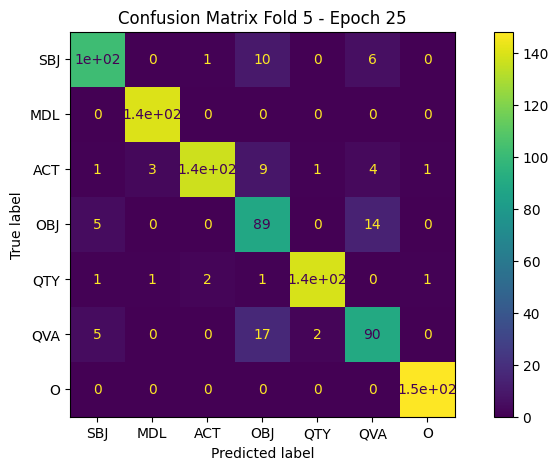

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,119.0,0.857143,0.857143,0.894737,0.875537
MDL,140.0,1.000000,1.000000,0.972222,0.985915
ACT,156.0,0.878205,0.878205,0.978571,0.925676
OBJ,108.0,0.824074,0.824074,0.706349,0.760684
QTY,145.0,0.958621,0.958621,0.978873,0.968641
QVA,114.0,0.789474,0.789474,0.789474,0.789474
O,148.0,1.000000,1.000000,0.986667,0.993289


4it [10:24, 129.01s/it]

Epoch 26 / 30


==:==:==Train==:==:==: 30it [00:02, 10.35it/s]


Average Loss Train: 0.11408934195836386


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [10:27, 129.01s/it]

Average Loss Validation: 0.08261182573106554
Time 3.584102153778076

Epoch 27 / 30


==:==:==Train==:==:==: 30it [00:02, 10.11it/s]


Average Loss Train: 0.11106895506381989


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [10:31, 129.01s/it]

Average Loss Validation: 0.0810625520017412
Time 3.6454927921295166

Epoch 28 / 30


==:==:==Train==:==:==: 30it [00:02, 10.05it/s]


Average Loss Train: 0.10868938267230988


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [10:34, 129.01s/it]

Average Loss Validation: 0.07802715400854747
Time 3.611206531524658

Epoch 29 / 30


==:==:==Train==:==:==: 30it [00:02, 10.21it/s]


Average Loss Train: 0.10720668335755666


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [10:38, 129.01s/it]

Average Loss Validation: 0.07812879979610443
Time 3.613447427749634

Epoch 30 / 30


==:==:==Train==:==:==: 30it [00:02, 10.11it/s]


Average Loss Train: 0.1025731990734736


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.0791627201769087
Time 3.641900062561035

Debug Amount: tensor([119., 140., 156., 108., 145., 114., 148.])


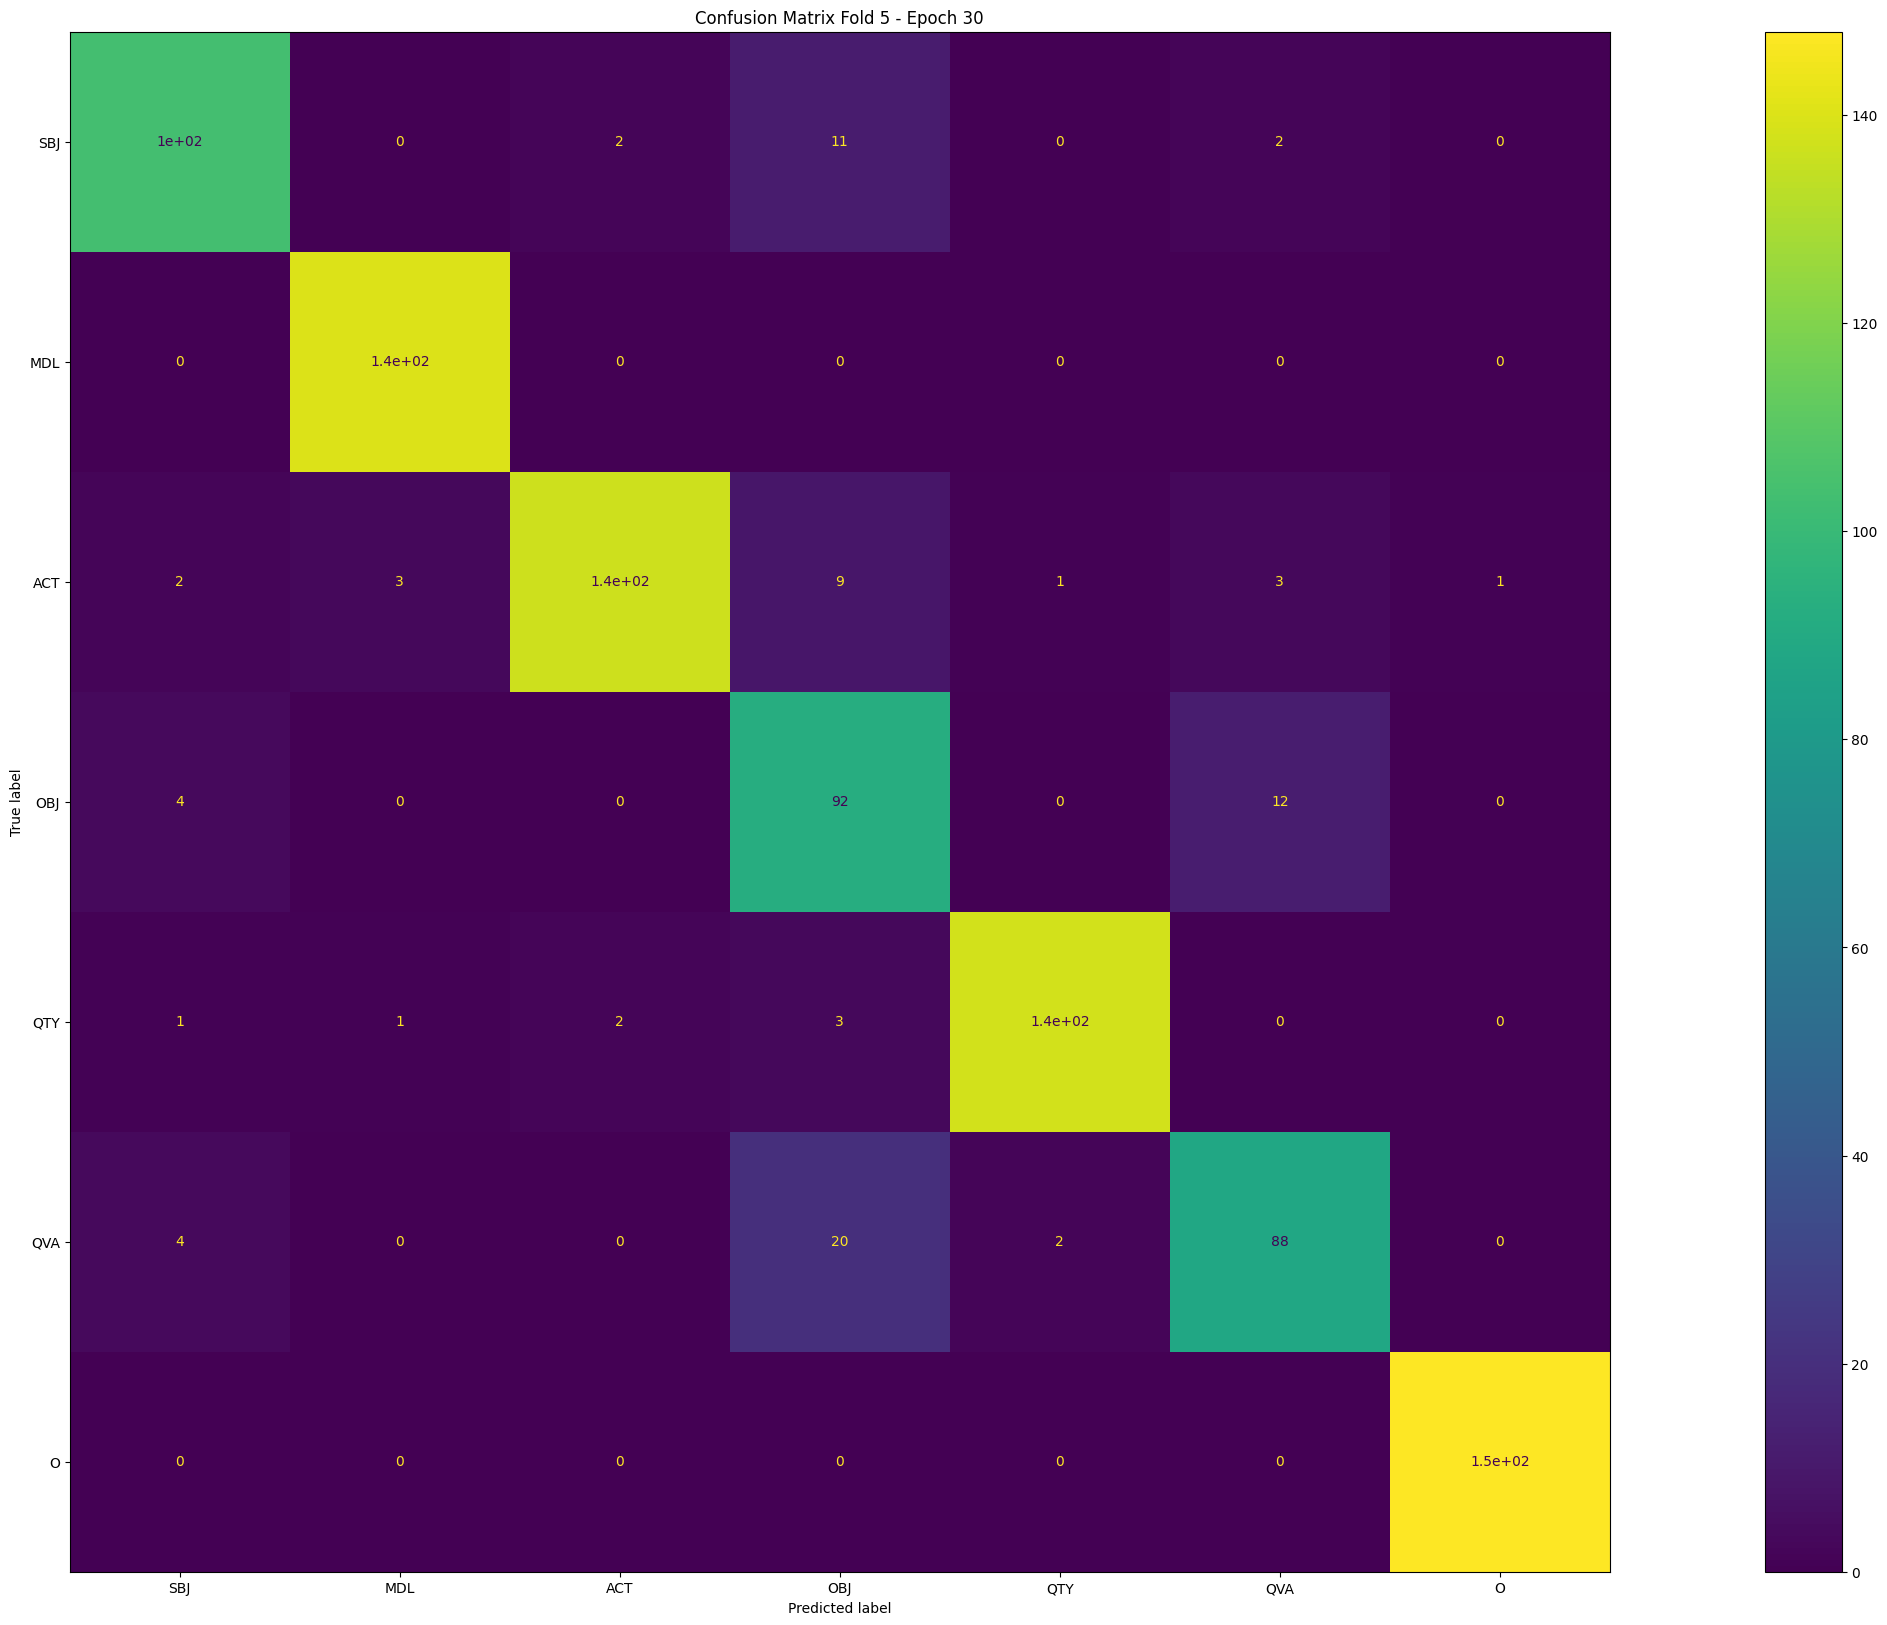

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,119.0,0.873950,0.873950,0.904348,0.888889
MDL,140.0,1.000000,1.000000,0.972222,0.985915
ACT,156.0,0.878205,0.878205,0.971631,0.922559
OBJ,108.0,0.851852,0.851852,0.681481,0.757202
QTY,145.0,0.951724,0.951724,0.978723,0.965035
QVA,114.0,0.771930,0.771930,0.838095,0.803653
O,148.0,1.000000,1.000000,0.993289,0.996633


100%|███████████████████████████████████████████| 30/30 [02:02<00:00,  4.08s/it]
5it [10:45, 129.03s/it]


In [28]:
import time
torch.manual_seed(12345)

# training image classification

LEARNING_RATE = 5e-5
EPOCH = 30

model.to(DEVICE)

training_losses = [[] for i in range(5)]
validation_losses = [[] for i in range(5)]

kf = KFold(n_splits=5)

# Load before training + validing
for fold_i, (train_index, val_index) in enumerate(tqdm(kf.split(np.zeros(len(qa_dataset_train))), position=0, leave=True)):
  tqdm.write(f"=====:=====:=====:=====:===== Fold {fold_i + 1} =====:=====:=====:=====:=====")

  # Subset dataset for train and val
  train_dataset = Subset(qa_dataset_train, train_index)
  valid_dataset = Subset(qa_dataset_train, val_index)

  # train_semantic_dataset = Subset(qa_dataset_train_semantic, train_semantic_index)
  # valid_semantic_dataset = Subset(qa_dataset_train_semantic, val_semantic_index)

  train_size = len(train_dataset)
  valid_size = len(valid_dataset)
  # train_semantic_size = len(train_semantic_dataset)
  # valid_semantic_size = len(valid_semantic_dataset)

  train_instances = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_class)
  valid_instances = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)

  # train_semantic_instances = DataLoader(train_semantic_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_class)
  # valid_semantic_instances = DataLoader(valid_semantic_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)

  model = AutoModelForTokenClassification.from_pretrained("indolem/indobert-base-uncased", label2id=label2id, id2label=id2label)
  model.to(DEVICE)

  # optimizer
  optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)

  tqdm.write(f'Fold {fold_i + 1} Ready')

  for epoch_i in tqdm(range(0, EPOCH), position=0, leave=True):
    start = time.time()
    tqdm.write(f"Epoch {epoch_i + 1} / {EPOCH}")

    # Freeze all layers and fcl
    for param in model.parameters():
        param.requires_grad = False
    for param in model.bert.encoder.layer[11].parameters():
        param.requires_grad = True
    for param in model.classifier.parameters():
        param.requires_grad = True

    # Reset the total loss for this epoch.
    tr_loss = 0

    # Put the model into training mode.
    model.train()

    # Untuk setiap data di training data
    train_total_data = 0
    train_pbar = tqdm(desc="==:==:==Train==:==:==", position=0, leave=True)
    for data in train_instances:

      # Mendapatkan output dari model
      train_total_data += len(data)

      input, attention, gold = data
      input = input.to(DEVICE)
      attention = attention.to(DEVICE)
      gold = gold.to(DEVICE)
      # pred = model(input)

      pred = model(input, attention_mask=attention).logits
      # pred = torch.argmax(logits, dim=2)

      # Categorical Cross-Entropy --- Loss Function
      loss = loss_func(pred.permute(0, 2, 1), gold)

      # Agar gradient tidak menumpuk; ini diperlukan sebelum
      # menghitung gradient dengan loss.backward()
      optimizer.zero_grad()

      # hitung gradient
      loss.backward()

      # update parameter
      optimizer.step()

      # akumulasi loss dalam 1 epoch
      tr_loss += loss.item()

      train_pbar.update(len(data))

    # rata-rata loss dalam 1 epoch
    avg_loss = tr_loss / train_total_data

    training_losses[fold_i].append(avg_loss)

    train_pbar.write(f"Average Loss Train: {avg_loss}")

    train_pbar.close()

    ### Uji coba di Validation Data

    # model eval, agar layer seperti dropout yang menghasilkan
    # sesuai yang random tidak digunakan
    model.eval()

    val_loss = 0
    pred_labels = []
    true_labels = []

    # Untuk setiap batch di validation data
    valid_total_data = 0
    valid_pbar = tqdm(desc="==:==:==Valid==:==:==", position=0, leave=True)
    for data in valid_instances:

      # jangan track gradient! ini sedang evaluasi, bukan training
      with torch.no_grad():

        valid_total_data += len(data)

        # Mendapatkan output dari model
        input, attention, gold = data
        input = input.to(DEVICE)
        attention = attention.to(DEVICE)
        gold = gold.to(DEVICE)
        pred = model(input, attention_mask=attention).logits

        # Categorical Cross-Entropy --- Loss Function
        loss = loss_func(pred.permute(0, 2, 1), gold)

        # akumulasi loss di validation set
        val_loss += loss.item()

        # valid_pbar.update(len(data))


    # average loss
    avg_val_loss = val_loss / valid_total_data

    validation_losses[fold_i].append(avg_val_loss)

    valid_pbar.write(f"Average Loss Validation: {avg_val_loss}")

    end = time.time()
    valid_pbar.write("Time " + str(end-start))
    valid_pbar.write("")
    valid_pbar.close()

    # accuracy
    # pred_labels = torch.stack(pred_labels).numpy()
    # true_labels = torch.stack(true_labels).numpy()
    # val_accuracy = np.sum(pred_labels == true_labels) / len(pred_labels)
    # print(f"Accuracy di validation data: {val_accuracy}")


    if (epoch_i + 1) % 5 == 0:
      nb_classes = 7

      conf_matrix = torch.zeros(nb_classes, nb_classes)
      for i, data in enumerate(valid_instances):
        with torch.no_grad():
          input, attention, gold = data
          input = input.to(DEVICE)
          attention = input.to(DEVICE)
          gold = gold.to(DEVICE)

          logits = model(input).logits
          pred = torch.argmax(logits, dim=2)
          # _, gold = torch.max(gold, 1)
          # _, pred = torch.max(pred, 1)
          # for t, p in zip(gold.view(-1), pred.view(-1)):
          #   conf_matrix[t.long(), p.long()] += 1

          conf_matrix = confusion_matrix(pred, gold, conf_matrix)

      amt, acc, prec, rec, f1 = evaluation_metric(conf_matrix)
      data_conf = {
          'Amount of Data': amt,
          'Accuracy': acc,
          'Precision': prec,
          'Recall': rec,
          'F One': f1
      }


      fig, ax = _, _
      if (epoch_i + 1) != EPOCH:
        fig, ax = plt.subplots(figsize=(10, 5))
      else:
        fig, ax = plt.subplots(figsize=(40, 20))

      display_labels = ['SBJ', 'MDL', 'ACT', 'OBJ', 'QTY', 'QVA', 'O']
      disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix.detach().cpu().numpy(), display_labels=display_labels)
      disp.plot(ax=ax)
      plt.title(f"Confusion Matrix Fold {fold_i + 1} - Epoch {epoch_i + 1}")
      plt.show()

      disp_df = pd.DataFrame(data=data_conf,
                            index=display_labels, columns=['Amount of Data', 'Accuracy', 'Precision', 'Recall', 'F One'])
      display(disp_df)

      # for i, template_index in enumerate(display_labels):
      #   print(f"Evaluation for {template_index}:")
      #   print(f"Amount of Data: {amt[i]}")
      #   print(f"Accuracy: {acc[i]}")
      #   print(f"Precision: {prec[i]}")
      #   print(f"Recall: {rec[i]}")
      #   print(f"F One: {f1[i]}")
      #   print()

      model.to("cpu")

      save_path = 'model_semantic/ner_i_checkpoint/fold_' + str(fold_i)
      if not os.path.exists(save_path):
        os.makedirs(save_path)
      model_class_path = os.path.join(save_path, "indobert_ner_semantic_checkpoint_" + str(epoch_i) +".pth")
      torch.save(model, model_class_path)

      model.to(DEVICE)

### Visualize

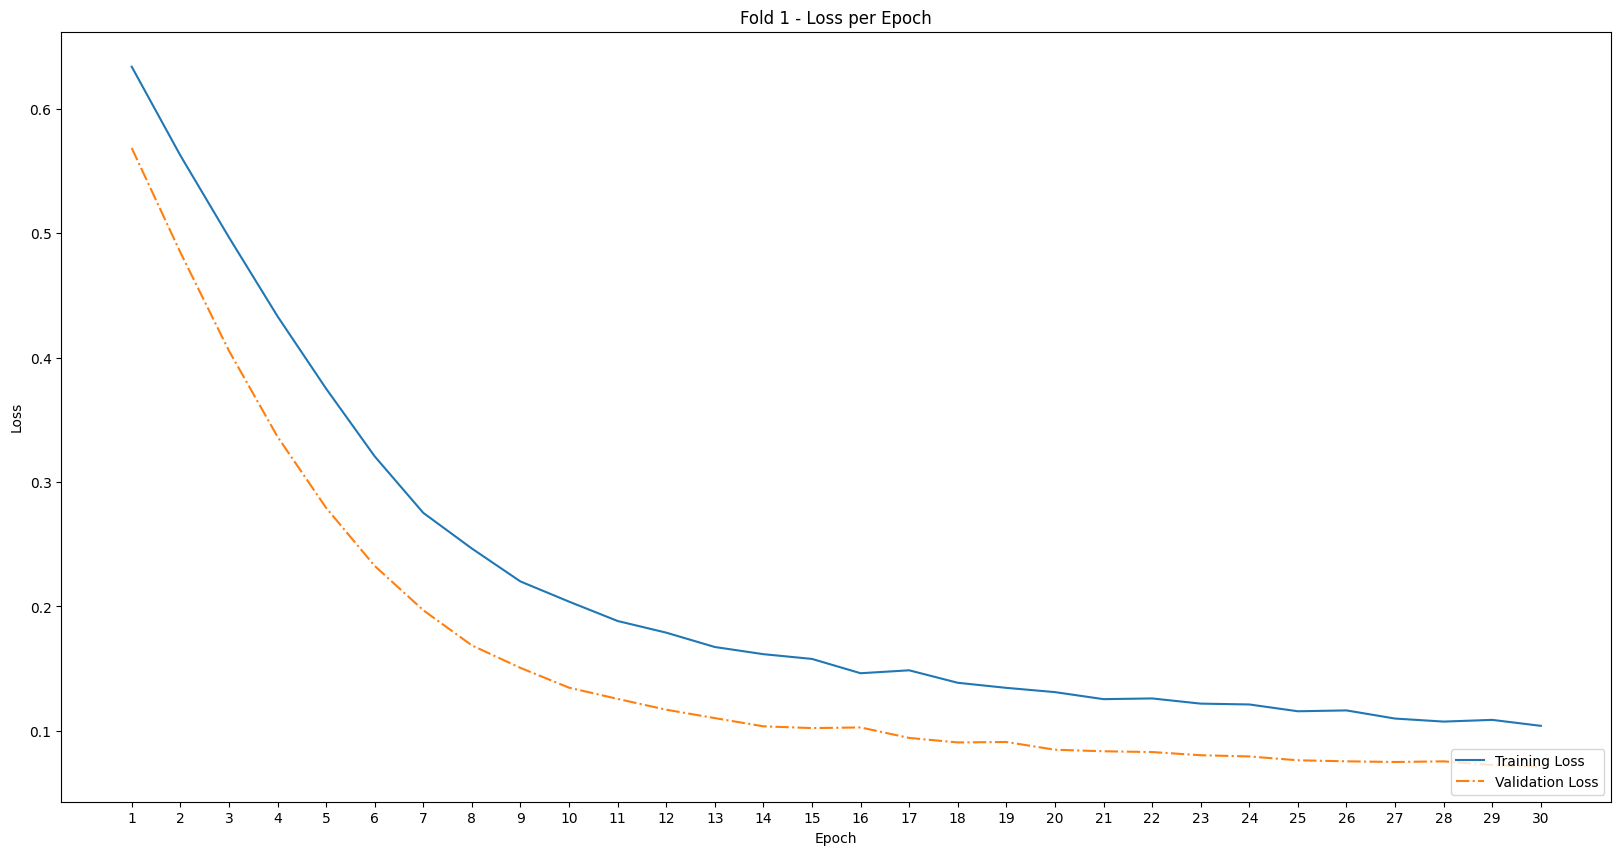

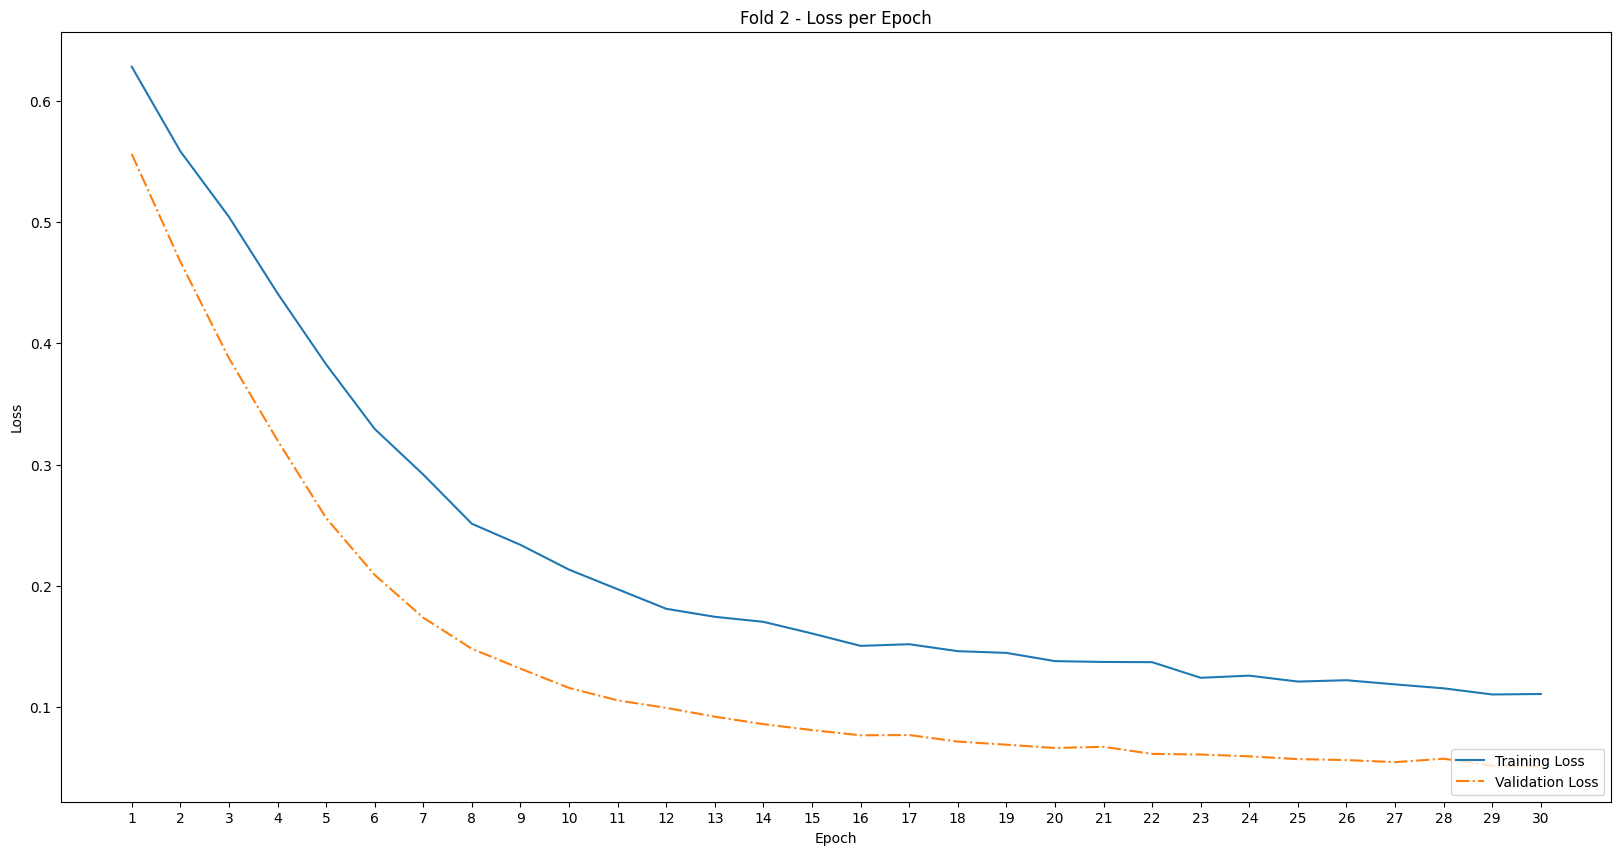

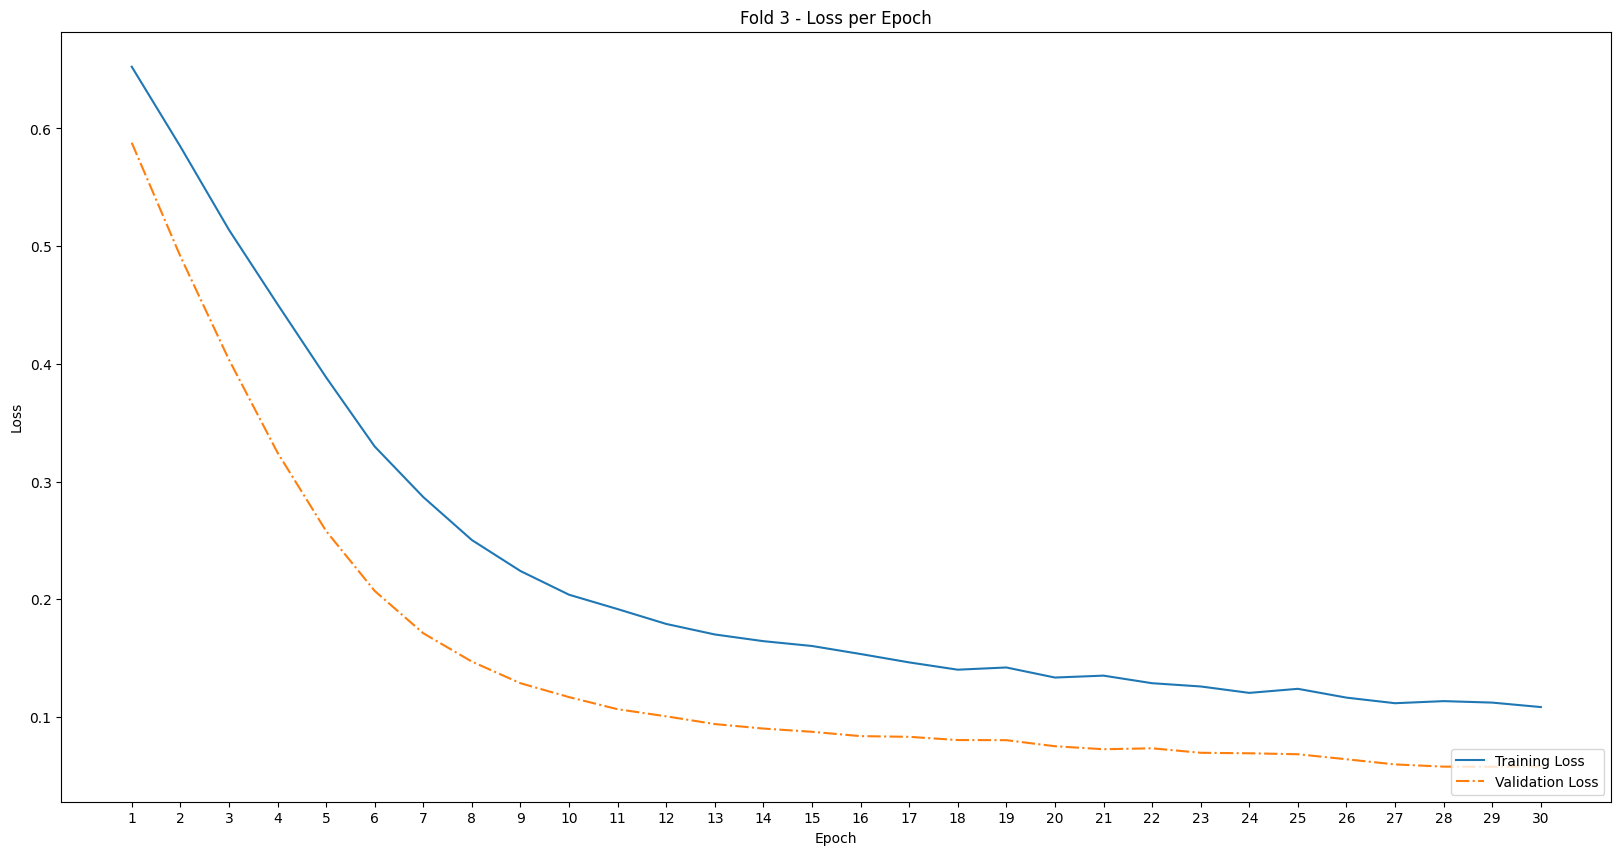

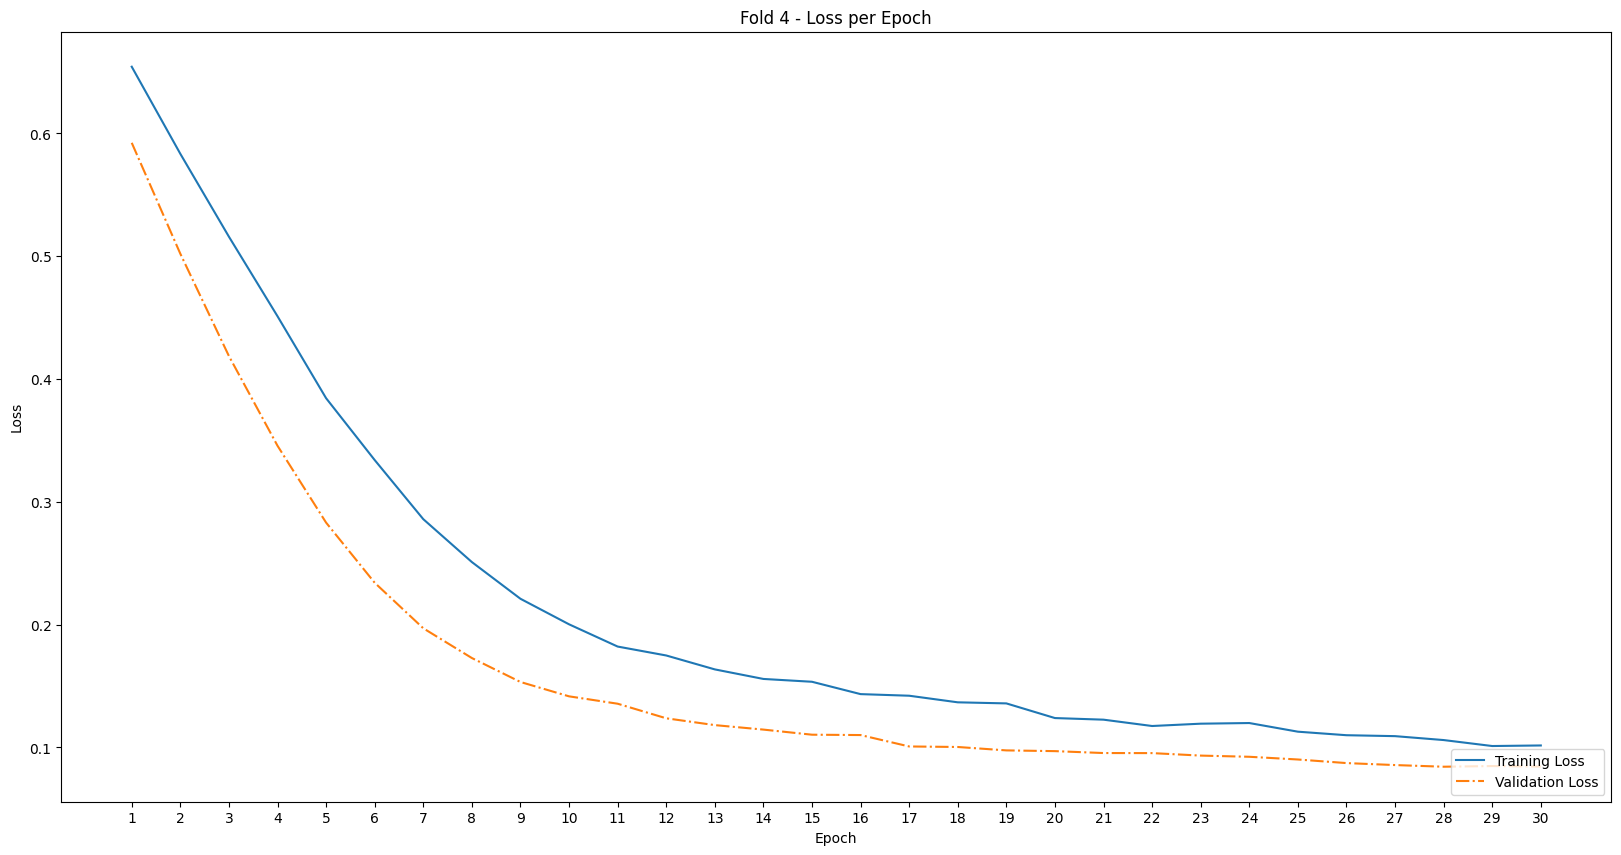

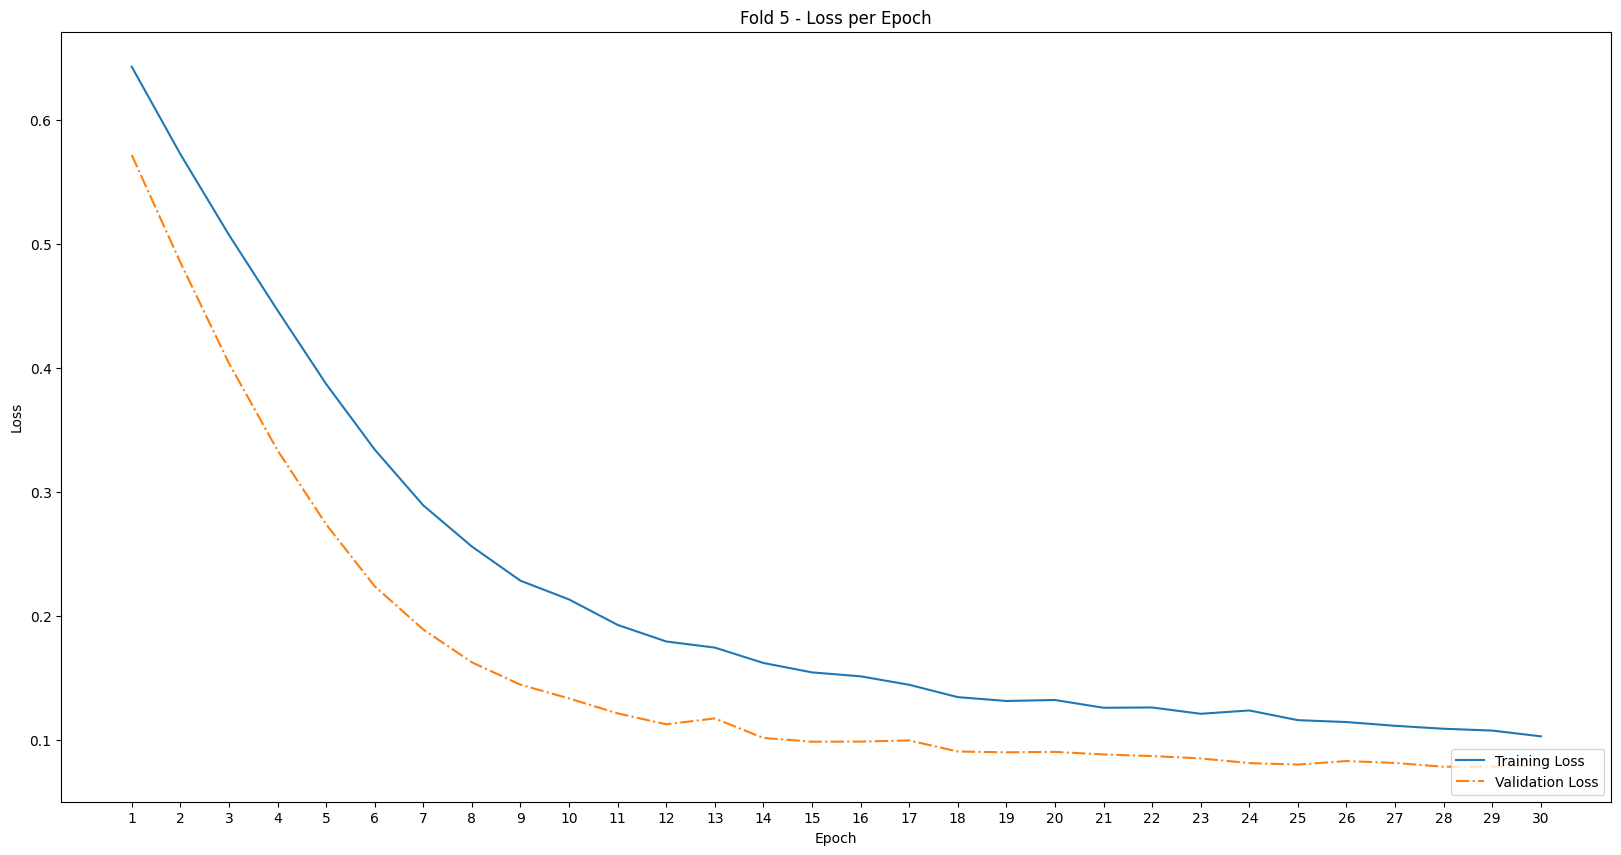

In [30]:
for i in range(5):
  x = np.arange(1, 31)
  y_train_loss = np.asarray(training_losses[i], dtype=np.float32)
  y_val_loss = np.asarray(validation_losses[i], dtype=np.float32)

  plt.figure(figsize=(20,10))

  plt.plot(x, y_train_loss[0:30])
  plt.plot(x, y_val_loss[0:30], '-.')

  plt.xticks(np.arange(min(x), max(x)+1, 1.0))
  plt.legend(["Training Loss", "Validation Loss"], loc="lower right")

  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title(f'Fold {i + 1} - Loss per Epoch')
  plt.show()

# Testing

Debug Amount: tensor([143., 169., 191., 139., 185., 157., 169.])

Average loss di testing data: 0.0029069625270304257


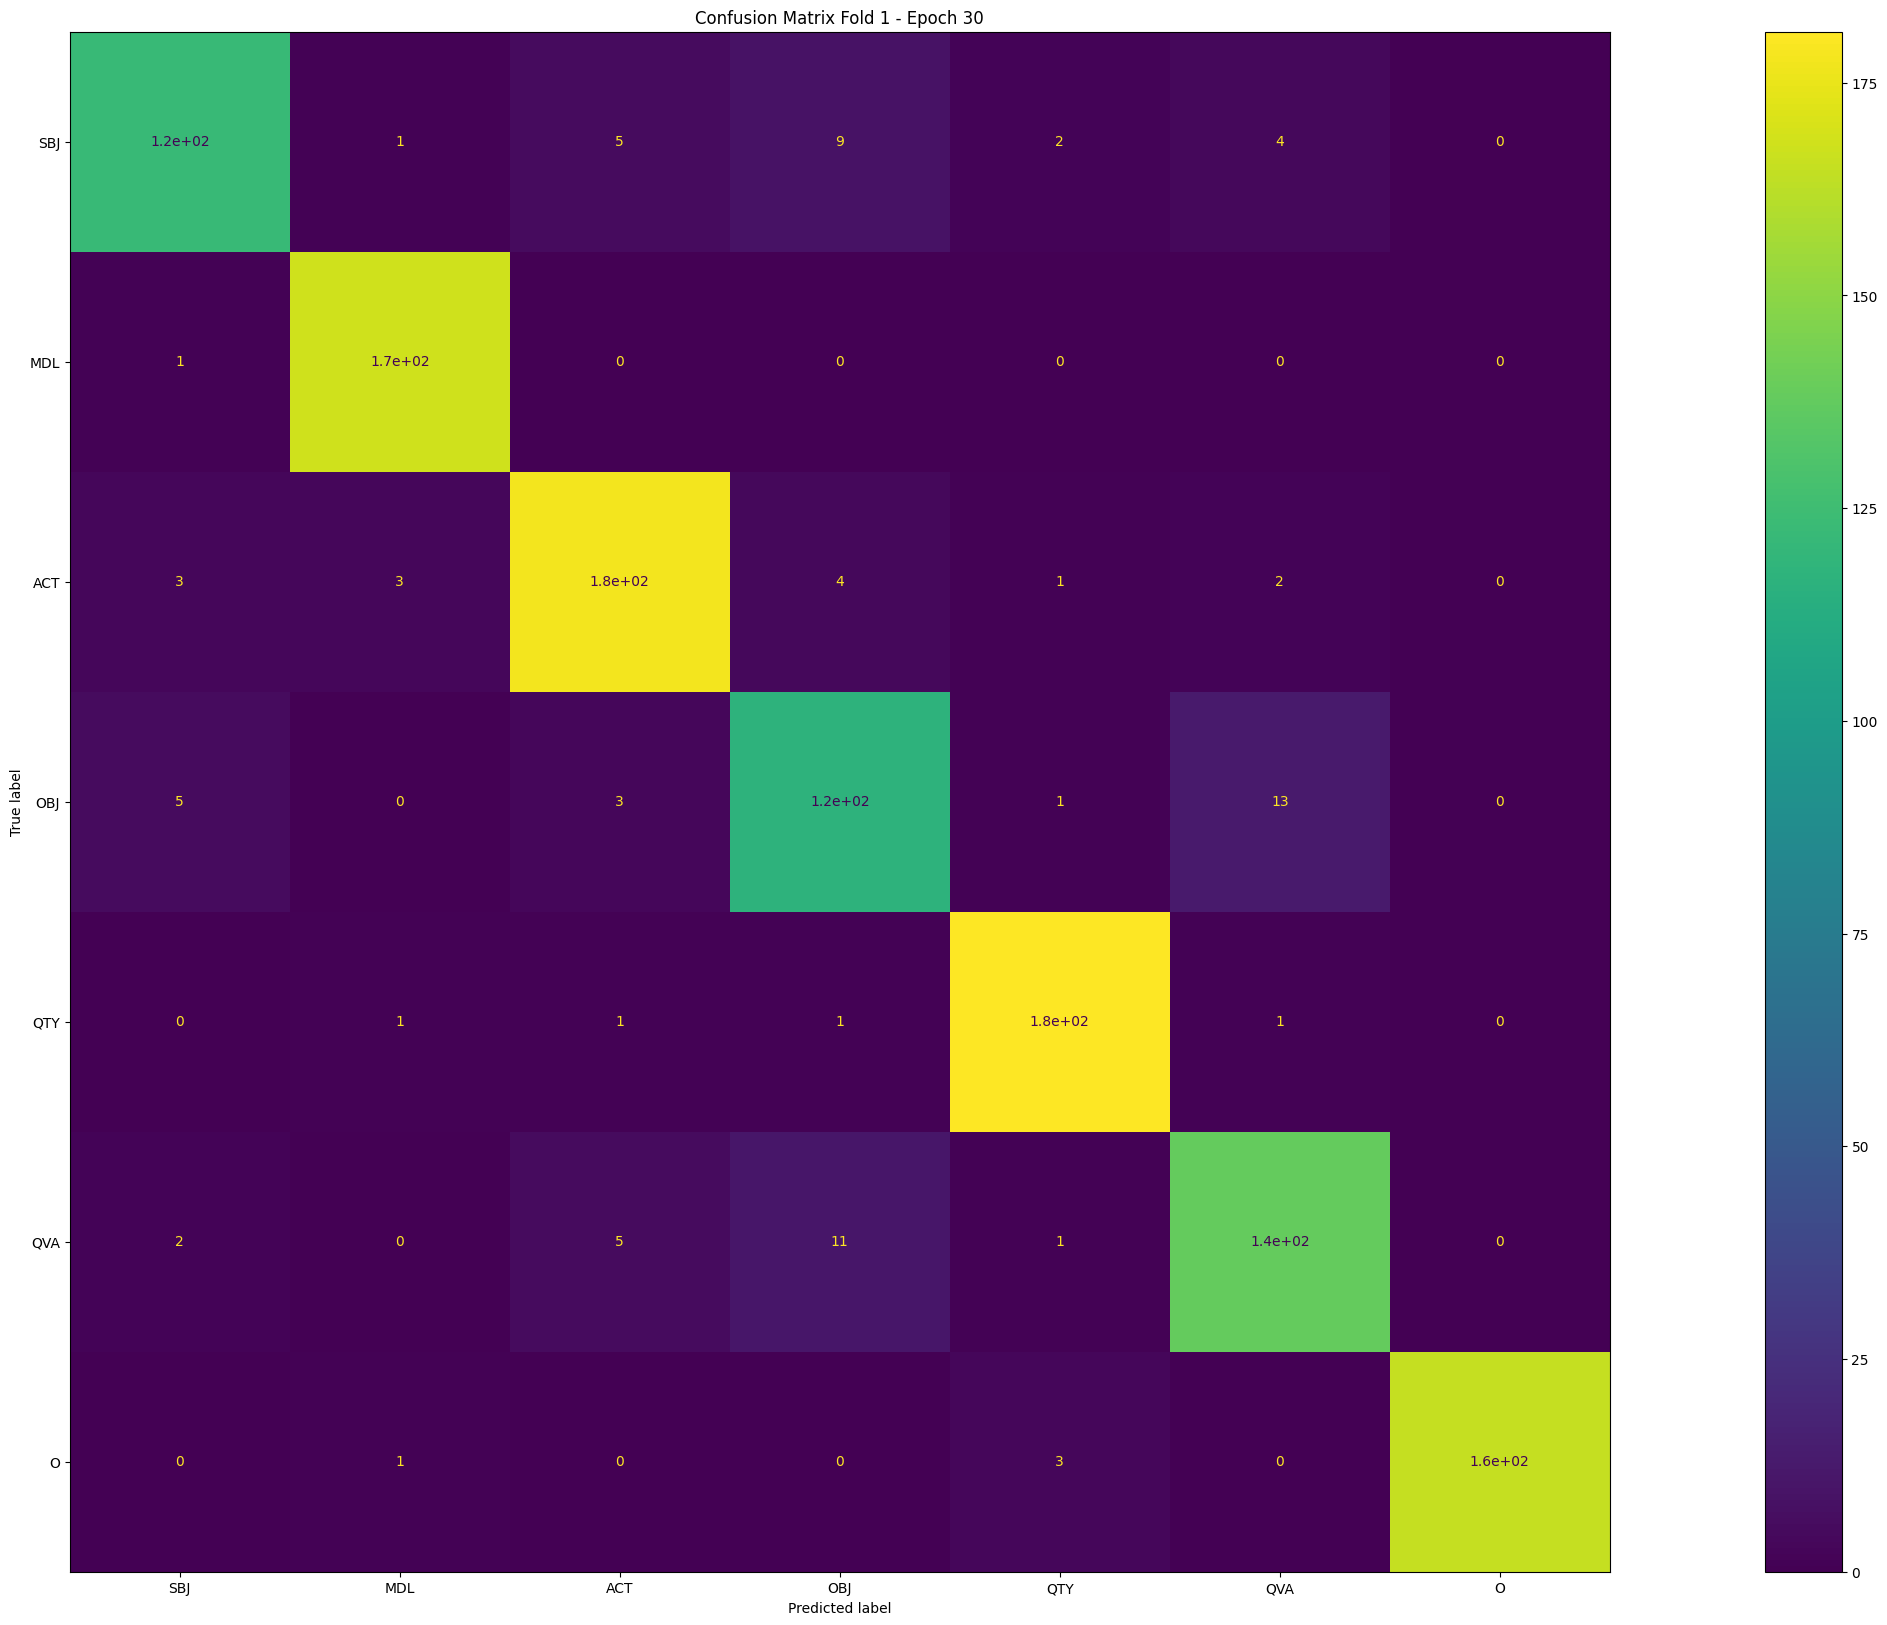

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,143.0,0.853147,0.853147,0.917293,0.884058
MDL,169.0,0.994083,0.994083,0.965517,0.979592
ACT,191.0,0.931937,0.931937,0.927083,0.929504
OBJ,139.0,0.841727,0.841727,0.823944,0.832740
QTY,185.0,0.978378,0.978378,0.957672,0.967914
QVA,157.0,0.878981,0.878981,0.873418,0.876190
O,169.0,0.976331,0.976331,1.000000,0.988024


Debug Amount: tensor([143., 169., 191., 139., 185., 157., 169.])

Average loss di testing data: 0.003087328912700034


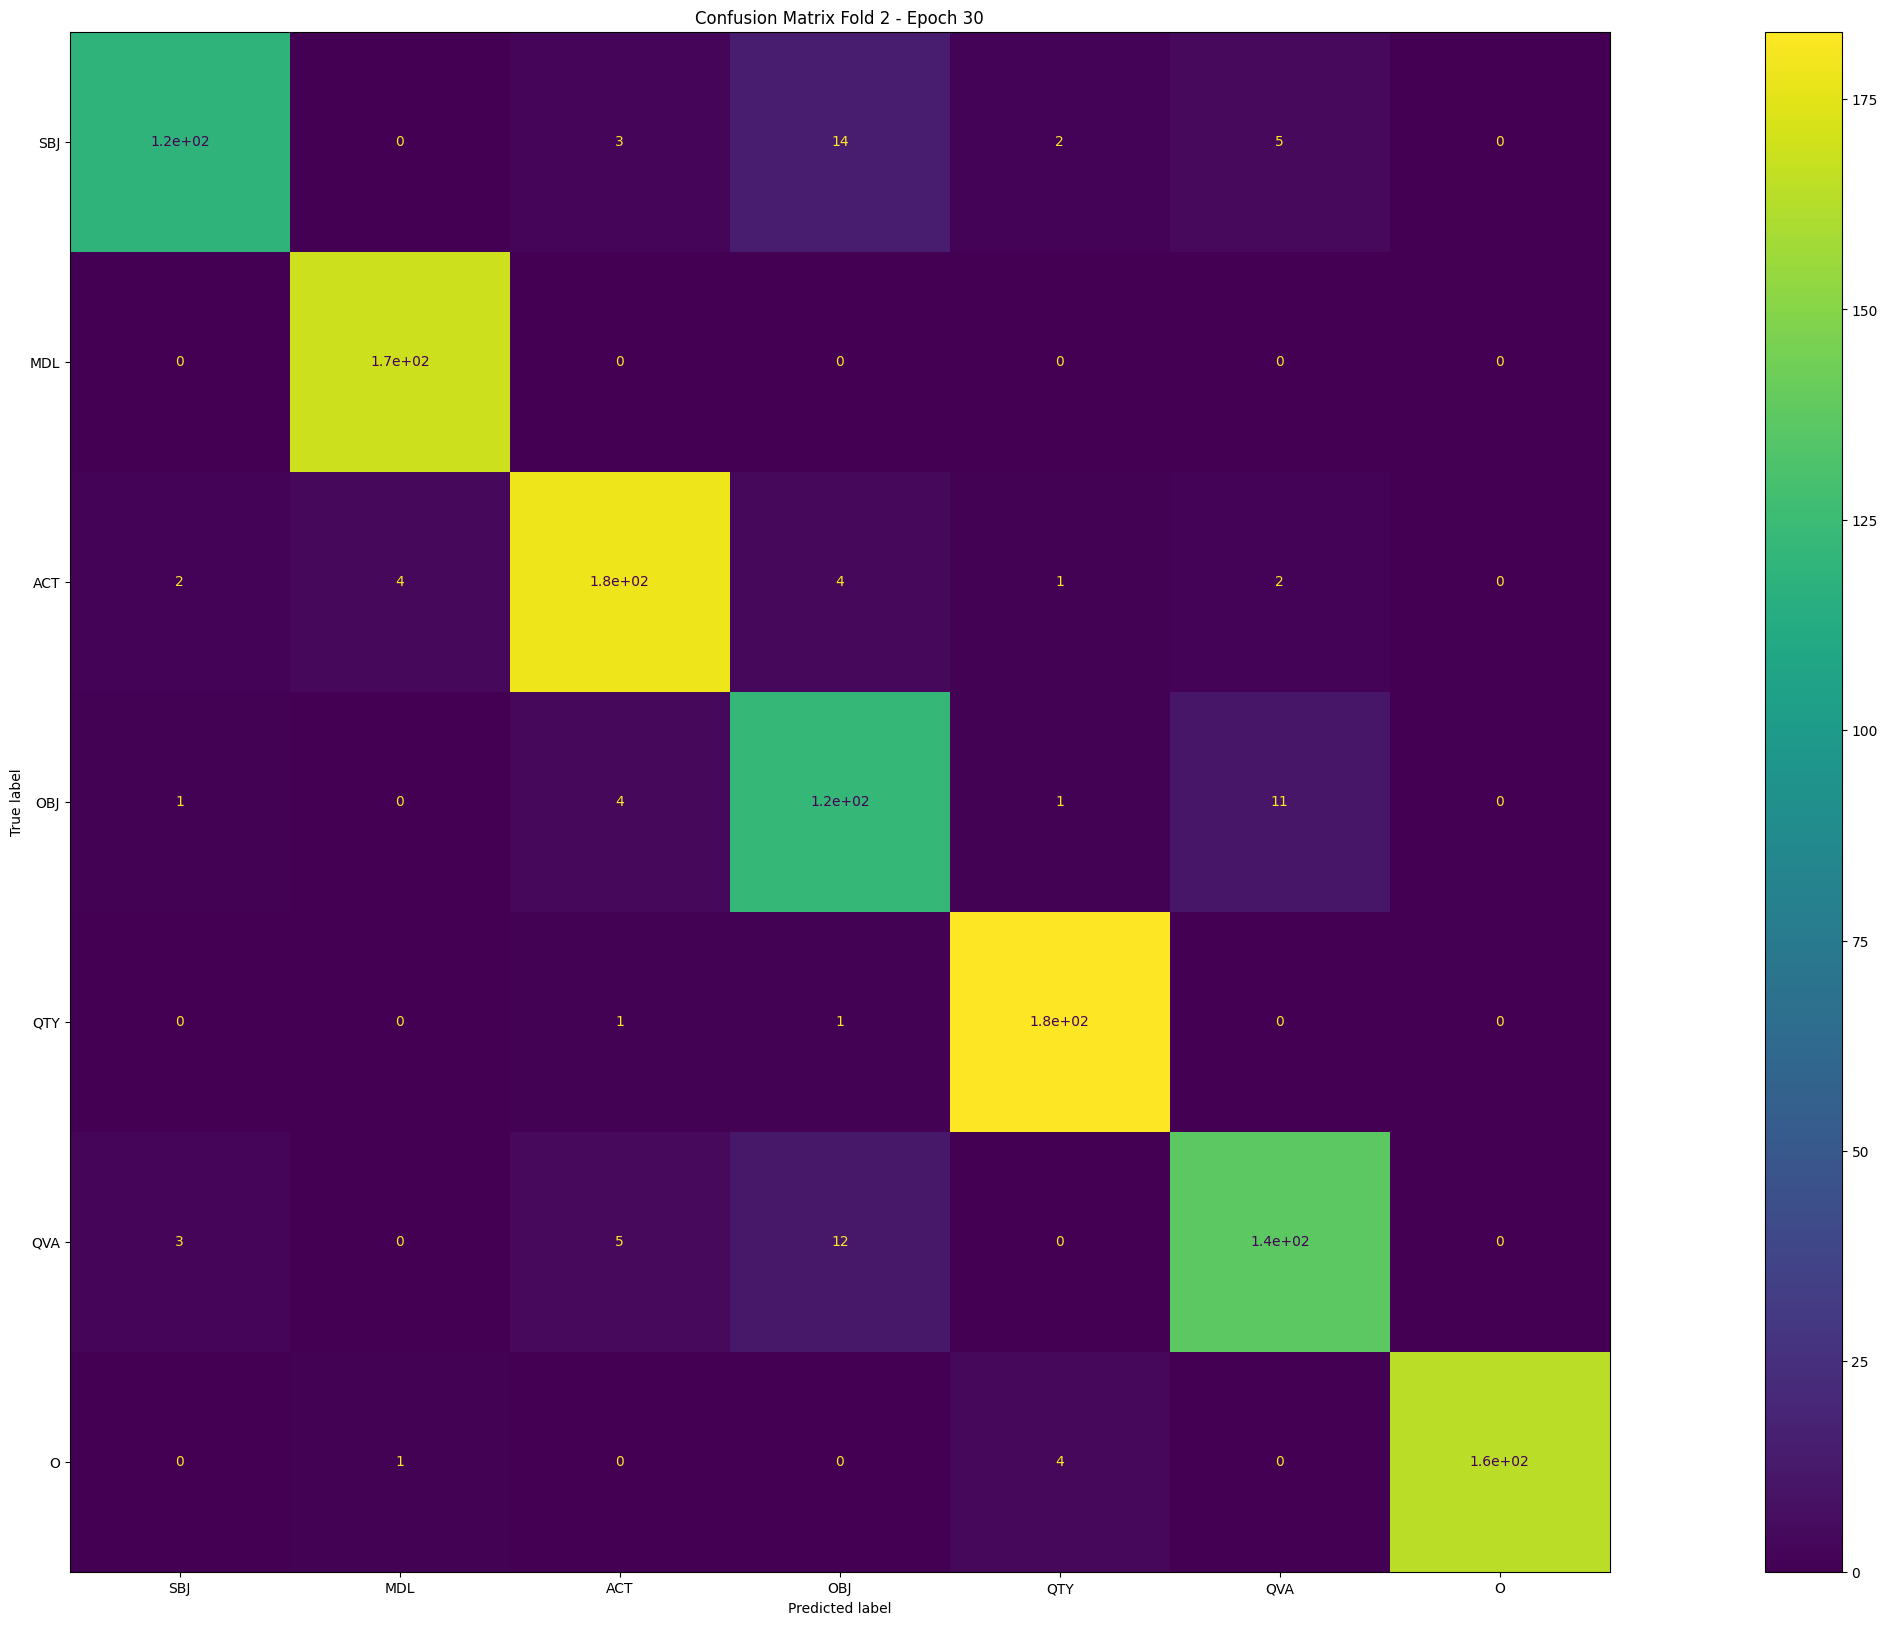

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,143.0,0.832168,0.832168,0.952000,0.888060
MDL,169.0,1.000000,1.000000,0.971264,0.985423
ACT,191.0,0.931937,0.931937,0.931937,0.931937
OBJ,139.0,0.877698,0.877698,0.797386,0.835616
QTY,185.0,0.989189,0.989189,0.958115,0.973404
QVA,157.0,0.872611,0.872611,0.883871,0.878205
O,169.0,0.970414,0.970414,1.000000,0.984985


Debug Amount: tensor([143., 169., 191., 139., 185., 157., 169.])

Average loss di testing data: 0.0030577217097057722


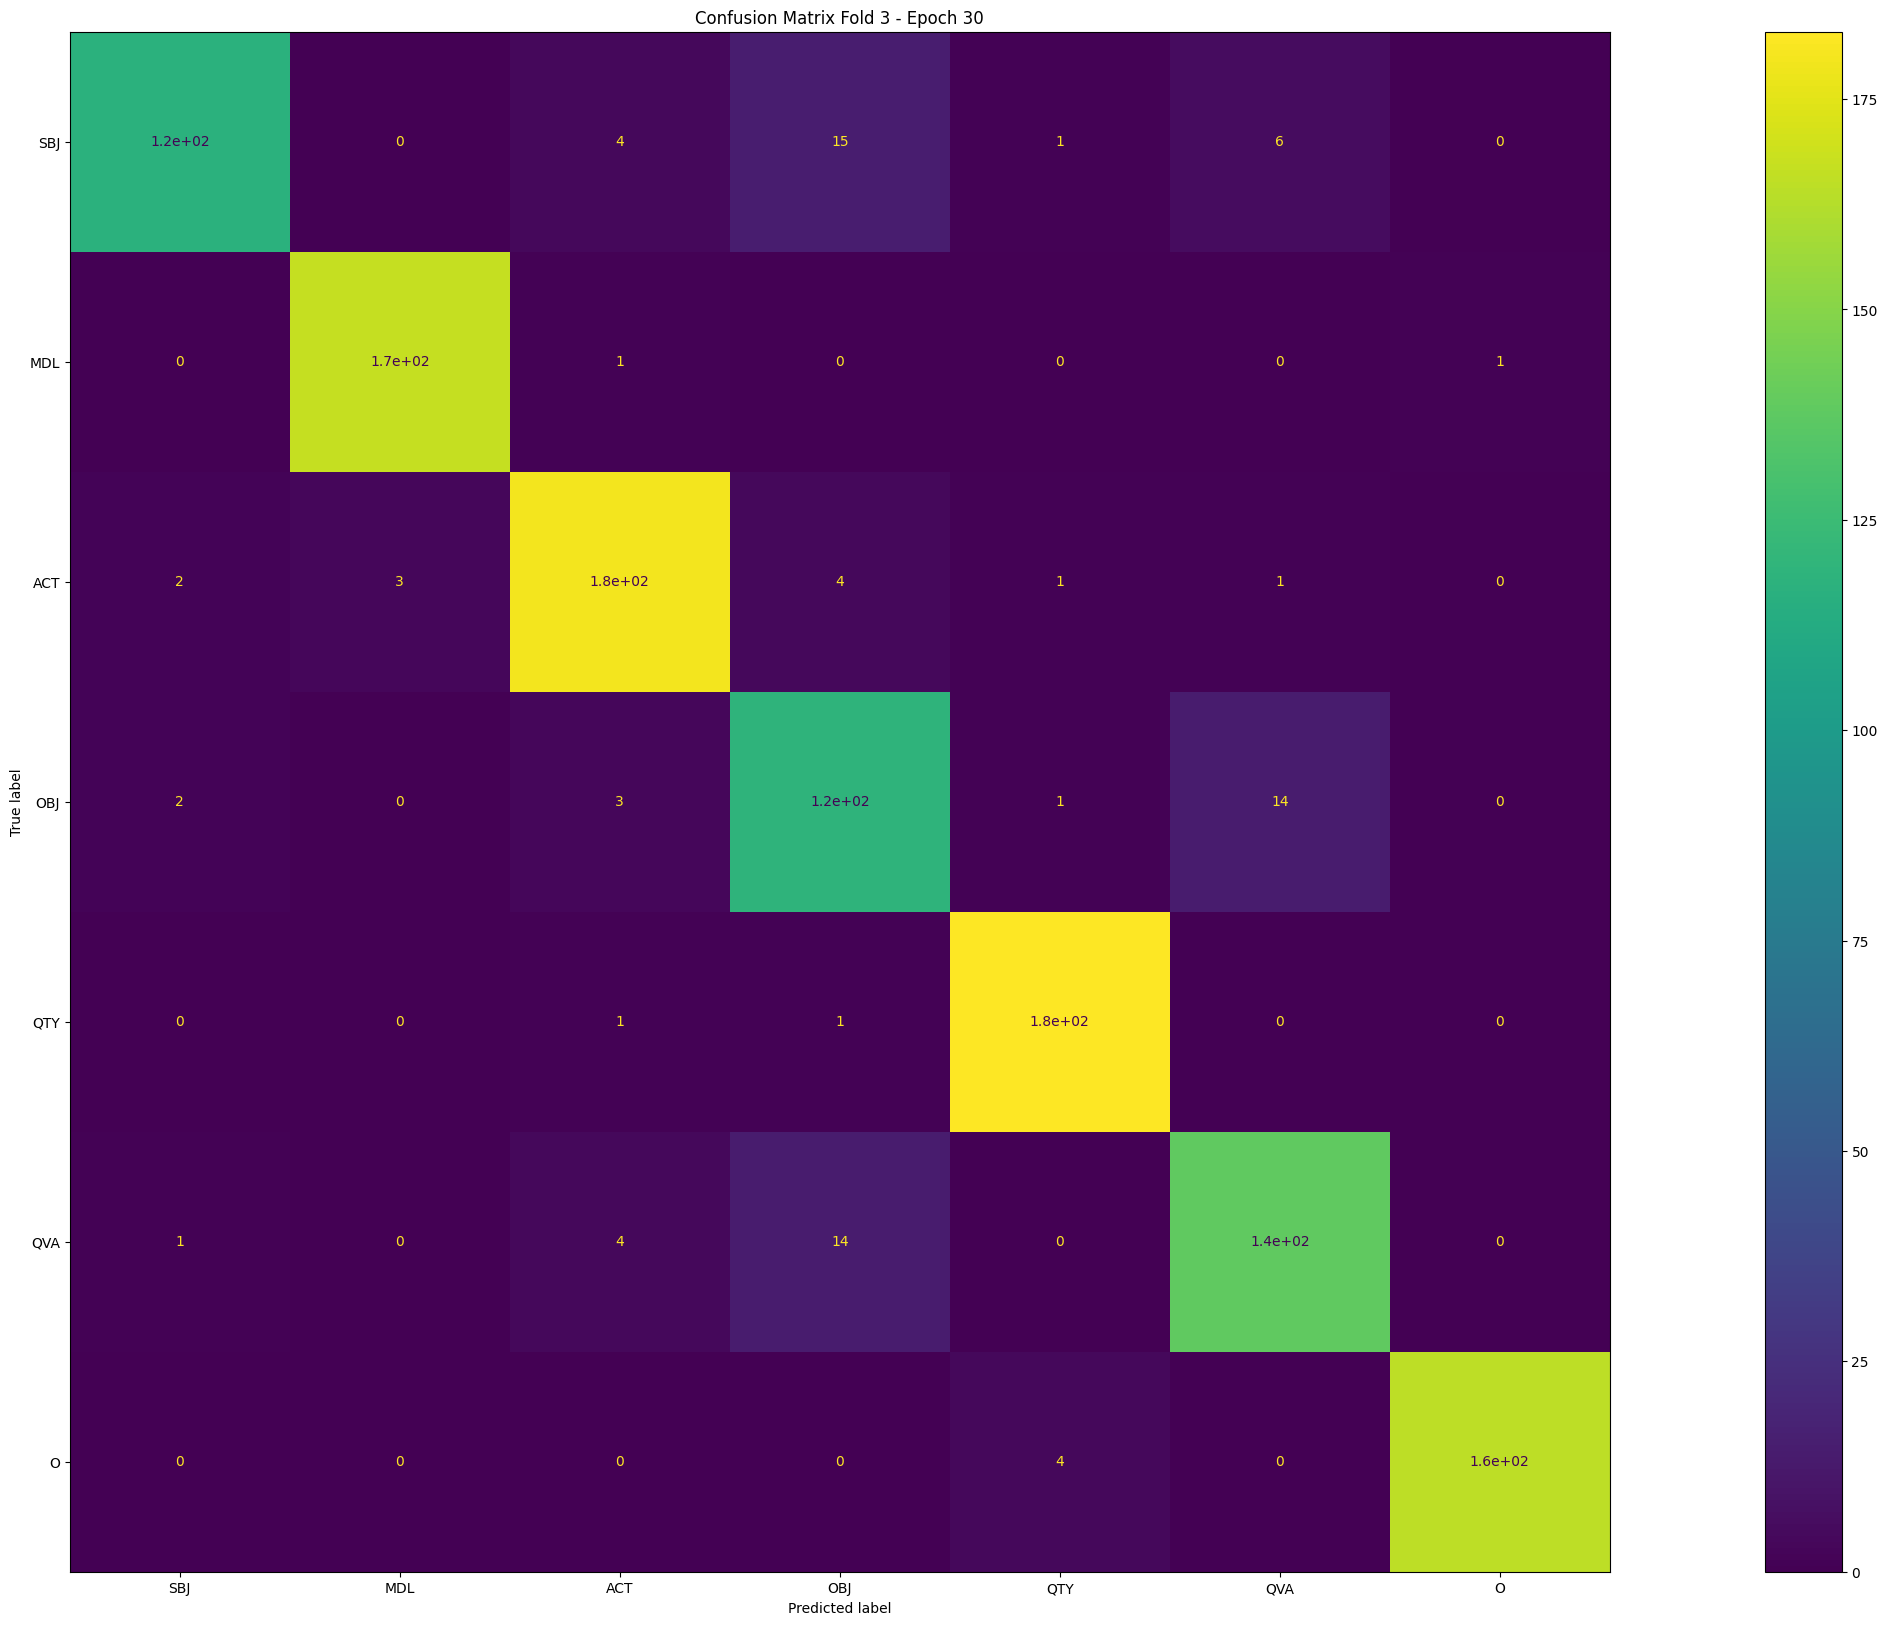

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,143.0,0.818182,0.818182,0.959016,0.883019
MDL,169.0,0.988166,0.988166,0.982353,0.985251
ACT,191.0,0.942408,0.942408,0.932642,0.937500
OBJ,139.0,0.856115,0.856115,0.777778,0.815069
QTY,185.0,0.989189,0.989189,0.963158,0.976000
QVA,157.0,0.878981,0.878981,0.867925,0.873418
O,169.0,0.976331,0.976331,0.993976,0.985075


Debug Amount: tensor([143., 169., 191., 139., 185., 157., 169.])

Average loss di testing data: 0.003218684521021019


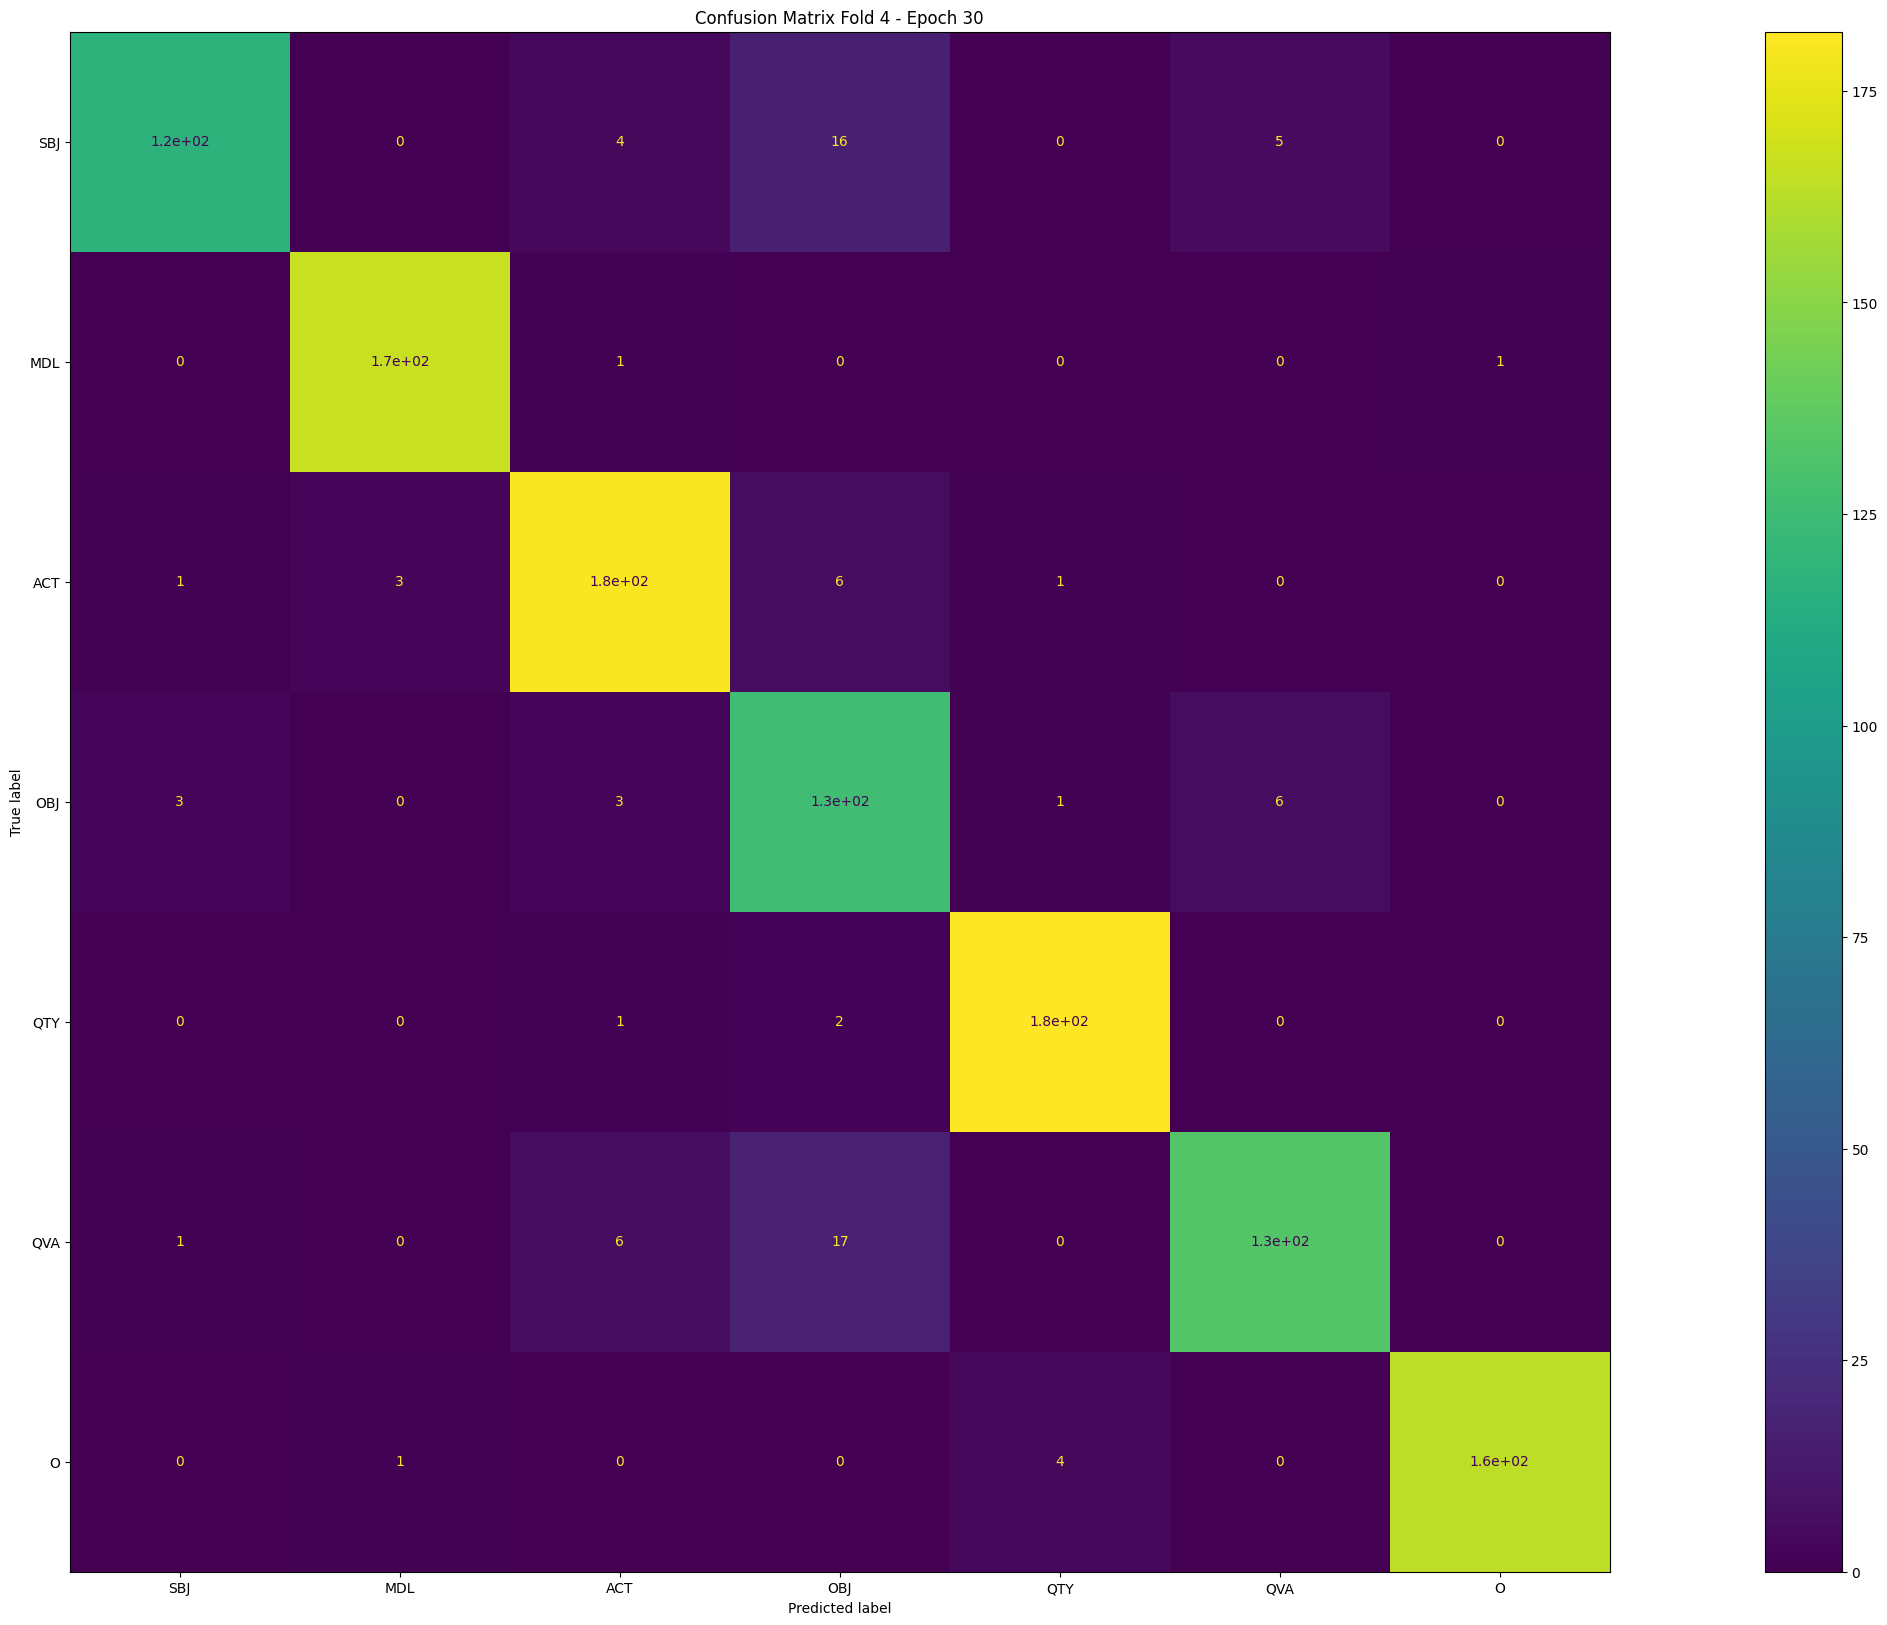

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,143.0,0.825175,0.825175,0.959350,0.887218
MDL,169.0,0.988166,0.988166,0.976608,0.982353
ACT,191.0,0.942408,0.942408,0.923077,0.932642
OBJ,139.0,0.906475,0.906475,0.754491,0.823529
QTY,185.0,0.983784,0.983784,0.968085,0.975871
QVA,157.0,0.847134,0.847134,0.923611,0.883721
O,169.0,0.970414,0.970414,0.993939,0.982036


Debug Amount: tensor([143., 169., 191., 139., 185., 157., 169.])

Average loss di testing data: 0.003155879715350286


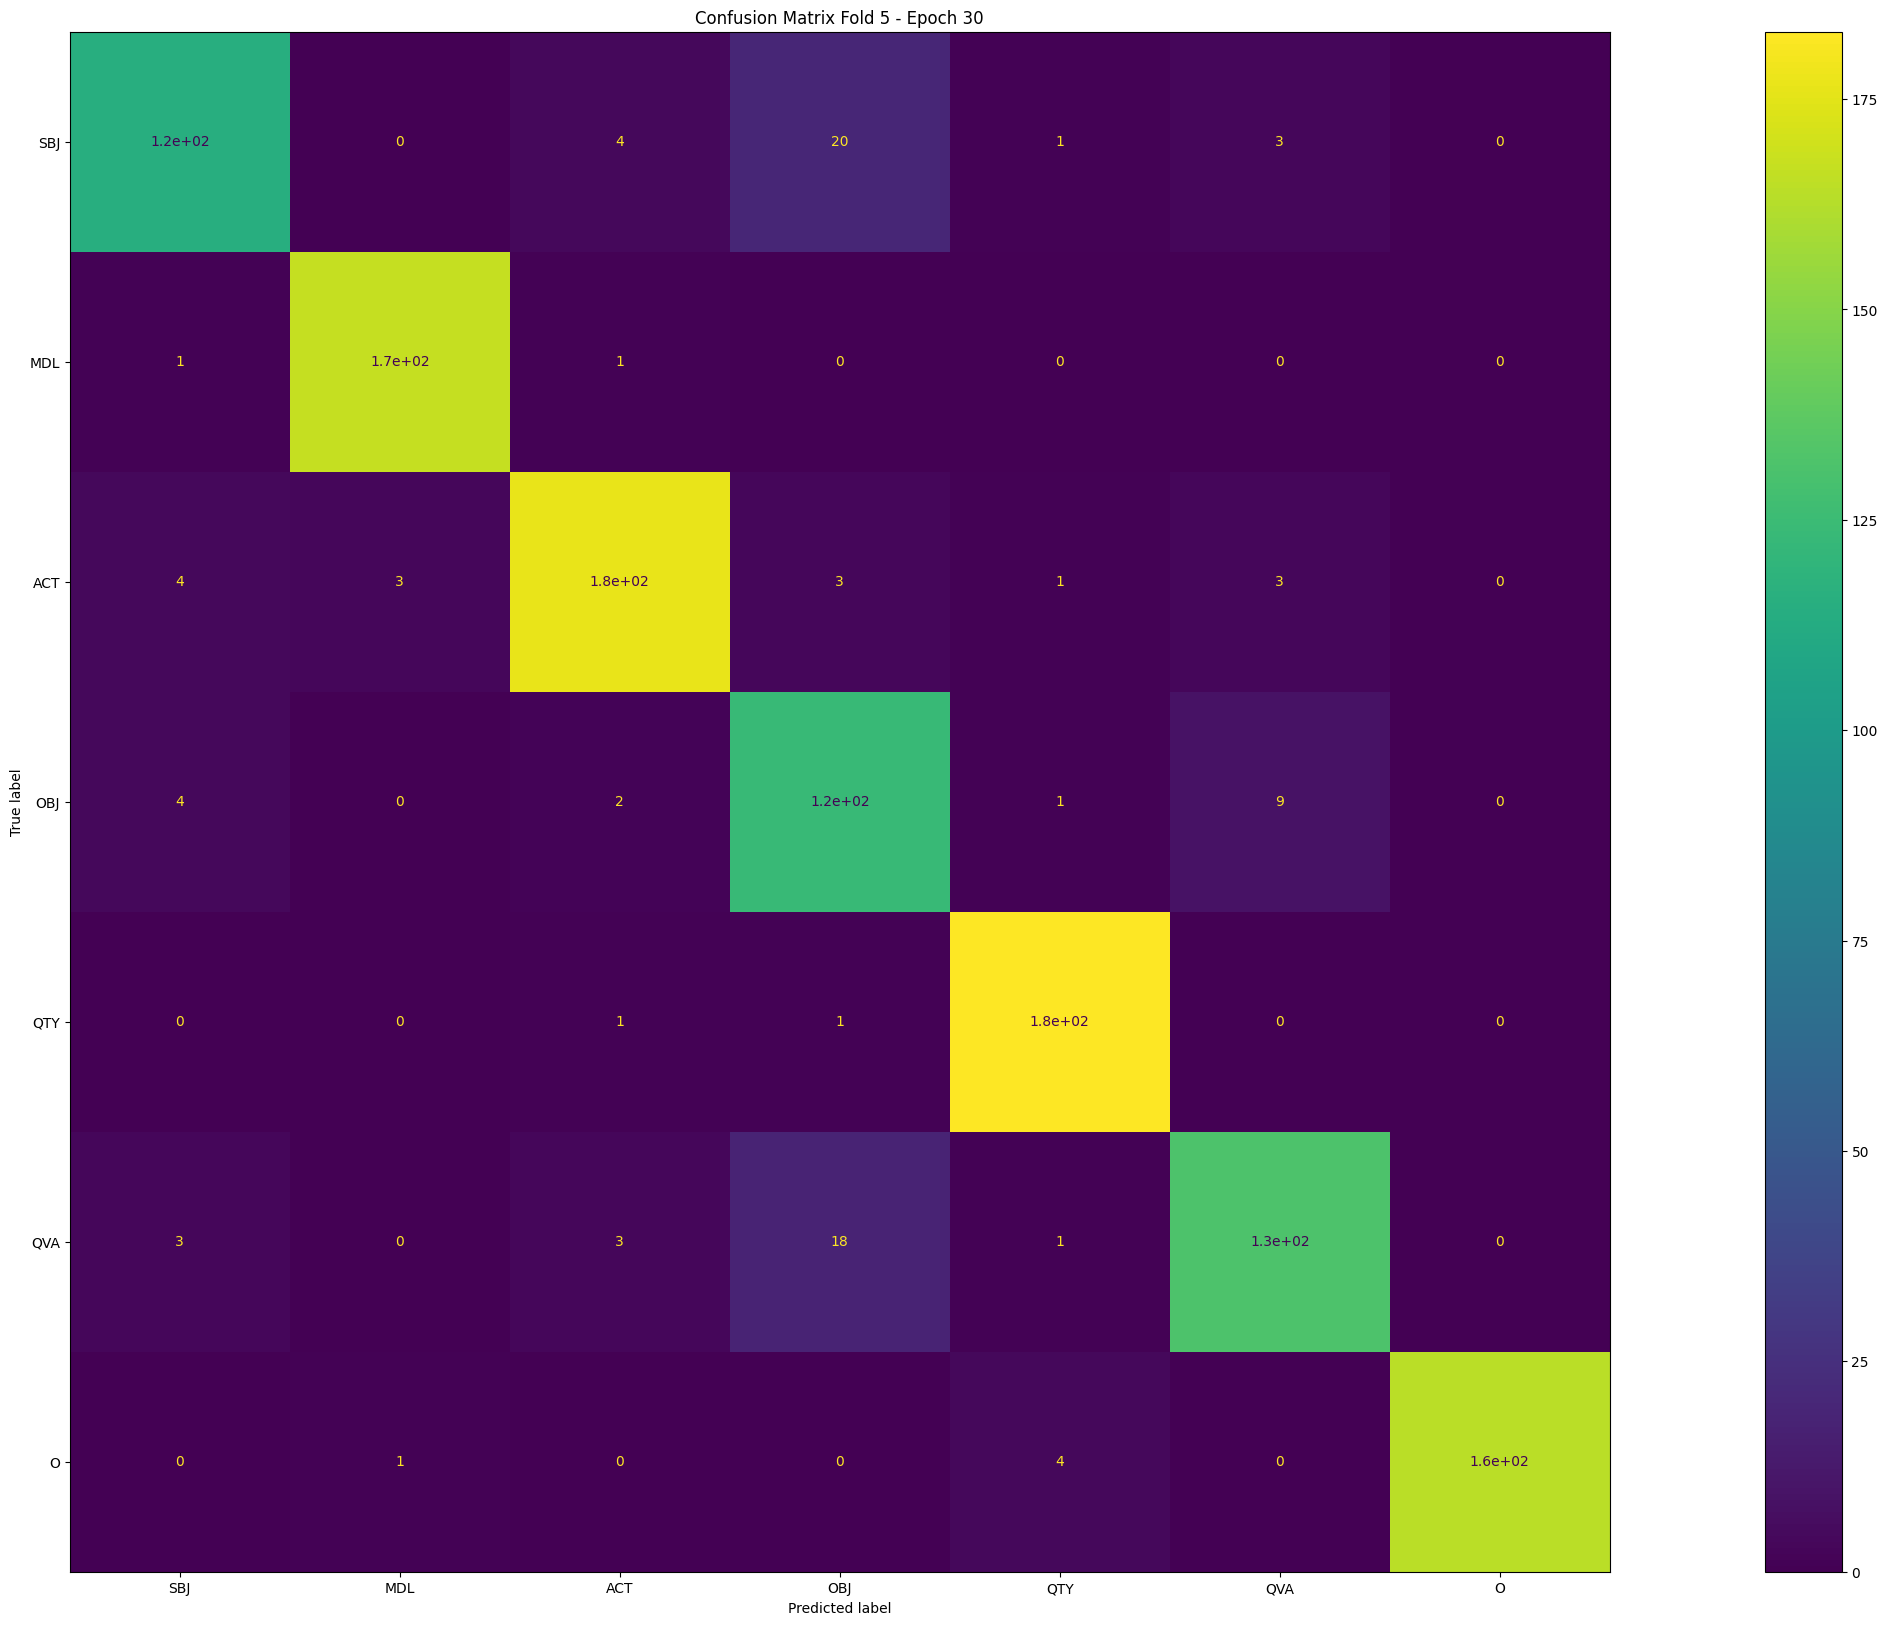

,Amount of Data,Accuracy,Precision,Recall,F One
SBJ,143.0,0.804196,0.804196,0.905512,0.851852
MDL,169.0,0.988166,0.988166,0.976608,0.982353
ACT,191.0,0.926702,0.926702,0.941489,0.934037
OBJ,139.0,0.884892,0.884892,0.745455,0.809211
QTY,185.0,0.989189,0.989189,0.958115,0.973404
QVA,157.0,0.840764,0.840764,0.897959,0.868421
O,169.0,0.970414,0.970414,1.000000,0.984985


In [36]:
true_recaps = [[] for i in range(5)]
false_recaps = [[] for i in range(5)]

for fold_i in range(5):

  tr_loss = 0

  save_path = 'model_semantic/ner_i_checkpoint/fold_' + str(fold_i)
  model_class_path = os.path.join(save_path, "indobert_ner_semantic_checkpoint_29.pth")
  model = torch.load(model_class_path)

  model.to(DEVICE)

  model.eval()

  nb_classes = 7

  conf_matrix = torch.zeros(nb_classes, nb_classes)
  # Untuk setiap data di training data
  for data in test_instances:

    with torch.no_grad():
      # Mendapatkan output dari model
      input, attention, gold = data
      input = input.to(DEVICE)
      attention = attention.to(DEVICE)
      gold = gold.to(DEVICE)
      logits = model(input, attention_mask=attention).logits
      pred = torch.argmax(logits, dim=2)

      # Categorical Cross-Entropy --- Loss Function
      loss = loss_func(logits.permute(0, 2, 1), gold)
      # _, pred = torch.max(pred, 1)
        # for t, p in zip(gold.view(-1), pred.view(-1)):
        #   confusion_matrix[t.long(), p.long()] += 1

      # akumulasi loss dalam 1 epoch
      tr_loss += loss.item()

      conf_matrix = confusion_matrix(pred, gold, conf_matrix)

      for input_recap, gold_recap, pred_recap in zip(input.to('cpu'), gold.to('cpu'), pred.to('cpu')):
        input_recap_sentence = tokenizer.decode(input_recap)
        # _, gold_idx = torch.max(gold_recap, 0)
        # _, pred_idx = torch.max(pred_recap, 0)
        if torch.equal(gold_recap, pred_recap):
          true_recaps[fold_i].append((input_recap_sentence, gold_recap, pred_recap))
        else:
          false_recaps[fold_i].append((input_recap_sentence, gold_recap, pred_recap))

  amt, acc, prec, rec, f1 = evaluation_metric(conf_matrix)
  data_conf = {
          'Amount of Data': amt,
          'Accuracy': acc,
          'Precision': prec,
          'Recall': rec,
          'F One': f1
      }

  # rata-rata loss dalam 1 epoch
  avg_loss = tr_loss / test_size
  # accuracy = confusion_matrix.diag()/confusion_matrix.sum(1)

  print("")
  print(f"Average loss di testing data: {avg_loss}")

  fig, ax = plt.subplots(figsize=(40, 20))

  display_labels = ['SBJ', 'MDL', 'ACT', 'OBJ', 'QTY', 'QVA', 'O']
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix.detach().cpu().numpy(), display_labels=display_labels)
  disp.plot(ax=ax)
  plt.title(f"Confusion Matrix Fold {fold_i + 1} - Epoch 30")

  plt.show()

  disp_df = pd.DataFrame(data=data_conf,
                          index=display_labels, columns=['Amount of Data', 'Accuracy', 'Precision', 'Recall', 'F One'])
  display(disp_df)

In [33]:
save_path = 'model_semantic/ner_i_checkpoint/fold_1'
model_class_path = os.path.join(save_path, "indobert_ner_semantic_checkpoint_29.pth")
model = torch.load(model_class_path)

# bert_class = model_class

save_path = 'model/ner/'
!mkdir -p model/ner/
model_class_path = os.path.join(save_path, "indobert_ner_i_semantic"+".pth")

model.to('cpu')
torch.save(model, model_class_path)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [37]:
df_true_recaps = pd.DataFrame(true_recaps[1], columns=['question', 'true_label', 'pred_label'])

save_path = 'semantic/dataset/'
if not os.path.exists(save_path):
  os.makedirs(save_path)
df_true_recaps.to_csv('semantic/dataset/indobert_ner_i_true_recaps.csv', index=False)

In [38]:
df_false_recaps = pd.DataFrame(false_recaps[1], columns=['question', 'true_label', 'pred_label'])

save_path = 'semantic/dataset/'
if not os.path.exists(save_path):
  os.makedirs(save_path)
df_false_recaps.to_csv('semantic/dataset/indobert_ner_i_false_recaps.csv', index=False)